<a href="https://colab.research.google.com/github/MariiaKalinina/Elasticity/blob/main/Permeability_from_TC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
from math import *
from scipy import integrate
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from scipy.integrate import dblquad

import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import matplotlib.colors

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
csfont = {'fontname':'Times New Roman'}

In [2]:
!pip install GitPython
from git import Repo
# !git clone https://github.com/MariiaKalinina/Elasticity.git
!git clone https://github.com/MariiaKalinina/Elasticity.git NewElasticity_v1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.9 MB/s eta 0:00:00
Cloning into 'NewElasticity_v1'...
remote: Enumerating objects: 434, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 434 (delta 143), reused 87 (delta 87), pack-reused 265
Receiving objects: 100% (434/434), 35.87 MiB | 11.07 MiB/s, done.
Resolving deltas: 100% (280/280), done.


In [ ]:
path_to_ser = Path('/content/NewElasticity_v1/Tver_ver1.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='All properties_data', skiprows=0)

NameError: name 'Path' is not defined

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
data = df_ues.copy()
data.drop('#', axis=1, inplace=True)

In [ ]:
data.dropna(subset=['AR thermal'], inplace=True)

In [ ]:
data[:10]

In [ ]:
df_ues['Permeability'].min(), df_ues['Permeability'].max()

(0.0169466, 2393.99)

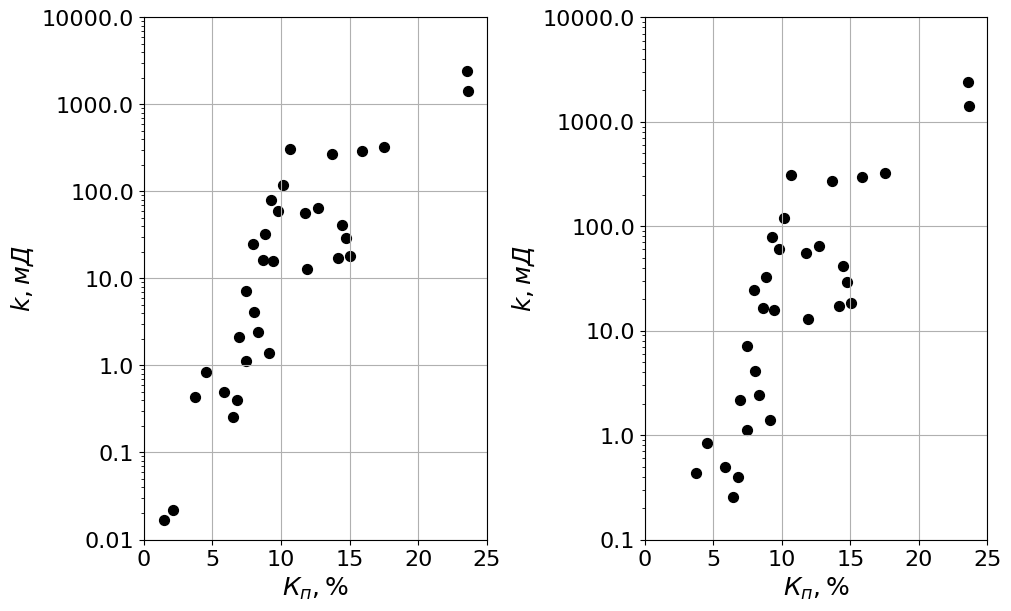

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
# layout='constrained'
# fig.tight_layout(pad=0.001000)
axs = fig.subplots(1, 2,  sharex=False)

ticks_size, label_size = 16, 18

        ### Porosity VS Permeability (all samples)
x_value, y_value = "Porosity,%", "Permeability"

  ### INPUT DATA
axs[0].scatter(df_ues[x_value], df_ues[y_value], color='Black', s=50)
axs[0].set_xscale("linear")
axs[0].set_xlabel("$К_{п}, $"+"$\%$", fontsize=label_size, fontweight='bold')
axs[0].set_xlim([0, 25])
axs[0].set_xticks(np.arange(0, 26, 5))
axs[0].set_xticklabels(np.arange(0, 26, 5), fontsize=ticks_size)
axs[0].set_yscale('log', base=10)
axs[0].grid(which='major', axis='both', linestyle='-')

axs[0].set_yscale('log')
axs[0].set_ylabel('${k}, мД$', fontsize=label_size, fontweight='bold')
axs[0].set_ylim([10**-2, 10**4])
axs[0].set_yticks(np.logspace(-2, 4, num=7))
axs[0].set_yticklabels(np.logspace(-2, 4, num=7), fontsize=ticks_size)



  ### INPUT DATA - 2
axs[1].scatter(df_ues[x_value], df_ues[y_value], color='Black', s=50)
axs[1].set_xscale("linear")
axs[1].set_xlabel("$К_{п}, $"+"$\%$", fontsize=label_size, fontweight='bold')
axs[1].set_xlim([0, 25])
axs[1].set_xticks(np.arange(0, 26, 5))
axs[1].set_xticklabels(np.arange(0, 26, 5), fontsize=ticks_size)
axs[1].set_yscale('log', base=10)
axs[1].grid(which='major', axis='both', linestyle='-')

axs[1].set_yscale('log')
axs[1].set_ylabel('${k}, мД$', fontsize=label_size, fontweight='bold')
axs[1].set_ylim([10**-1, 10**4])
axs[1].set_yticks(np.logspace(-1, 4, num=6))
axs[1].set_yticklabels(np.logspace(-1, 4, num=6), fontsize=ticks_size)


plt.show()

Границы ХШ

In [12]:
def Upper_Hashin_Strikman(phi, lam):
    L0 = max(lam)
    f = 1 / 3  # Границы ХШ - частный случай ОСП, тело сравние - мин.матрица=верхняя граница; флюид=нижняя граница.
                # Все включения только сферические АО=1, F деполяризации 1/3
    HS_comp1, HS_comp2 = [], []

    for i, j in zip(phi, lam):
        termc_3 = i * j / (L0 * (1-f)+j * f)
        termz_3 = i / (L0 * (1-f)+j * f)

        termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
        termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

        termc_all = (termc_3+2 * termc_12) / 3
        termz_all = (termz_3+2 * termz_12) / 3

        t16 = termc_all
        t15 = termz_all

        HS_comp1.append(t16)  # параллельная компонента ТС
        HS_comp2.append(t15)  # перпендикулярная компонента ТС
    i = 0
    for k in HS_comp1:
        i += k
    j = 0
    for k in HS_comp2:
        j += k

    L_eff = i / j
    # print('TC Upper Hashin-Strikman:', L_eff)
    return L_eff


def Lower_Hashin_Strikman(phi, lam):
    L0 = min(lam)
    f = 1 / 3  # Границы ХШ - частный случай ОСП, тело сравние - мин.матрица=верхняя граница; флюид=нижняя граница.
                # Все включения только сферические АО=1, F деполяризации 1/3
    HS_comp1, HS_comp2 = [], []

    for i, j in zip(phi, lam):
        termc_3 = i * j / (L0 * (1-f)+j * f)
        termz_3 = i / (L0 * (1-f)+j * f)

        termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
        termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

        termc_all = (termc_3+2 * termc_12) / 3
        termz_all = (termz_3+2 * termz_12) / 3

        t16 = termc_all
        t15 = termz_all

        HS_comp1.append(t16)  # параллельная компонента ТС
        HS_comp2.append(t15)  # перпендикулярная компонента ТС
    i = 0
    for k in HS_comp1:
        i += k
    j = 0
    for k in HS_comp2:
        j += k

    L_eff = i / j
    return L_eff

def Average_Hashin_Strikman(phi, lam):
    return np.mean([Lower_Hashin_Strikman(phi, lam), Upper_Hashin_Strikman(phi, lam)])

# Self-consistent (GSA)

ОСП - теплопроводность, проницаемость

In [10]:
def effective_tc(conc, alpha_shape, lam):

    x0=0

    phi = conc

    #------------------depolarization factor calculation-----
    def depolarizaton(alpha):
        if alpha < 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(t2-1)
            t5 = np.arctan(t4)
            t8 = t4 ** 2
            form = t2 * (t4-t5) / t8 / t4
            return form
        elif alpha > 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(1-t2)
            t6 = np.log(1+t4)
            t9 = np.log(1-t4)
            t13 = t4 ** 2
            form = t2 * (t6 / 2-t9 / 2-t4) / t13 / t4
            return form
        elif alpha == 1:
            form = 1 / 3
            return form


    depolar_F = []
    for i in alpha_shape:
        depolar_F.append(depolarizaton(i))

    L0 = lam[0]

    def raschet(L0):

        parall_comp, perpen_comp = [], []
#         print('Тело сравнения', L0)

        for i, j, f in zip(phi, lam, depolar_F):

#             print('Каждая комопонента')
#             print(i, j, f)

            termc_3 = i * j / (L0 * (1-f)+j * f)
            termz_3 = i / (L0 * (1-f)+j * f)

            termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
            termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

            termc_all = (termc_3+2 * termc_12) / 3
            termz_all = (termz_3+2 * termz_12) / 3

            t16 = termc_all # числитель
            t15 = termz_all # Знаменатель

#             print('ТС матрицы', j)
#             print('t16:' , t16)
#             print('t15:' , t15)

            parall_comp.append(t16)  # числитель формулы (матрица, флюид)
            perpen_comp.append(t15)  # знаменатель формулы (матрица, флюид)

#         print('Параллельный компоненты ТС', parall_comp)
#         print('Перпендикулярные компоненты ТС', perpen_comp)

        L_eff = np.sum(parall_comp) / np.sum(perpen_comp)
#         print('TC eff: ', L_eff, end='\n\n')
        return L_eff

    x0 = L0
    L0 = raschet(x0)
    it_f = 1
    while abs(x0-L0) >= 10 **-6:
        x0 = L0
        L0 = raschet(x0)
        it_f += 1

#     print('Количество итераций: ', it_f, end='\n\n')
    return L0
#     print('Эффективное значение TC_eff:', raschet(L0))


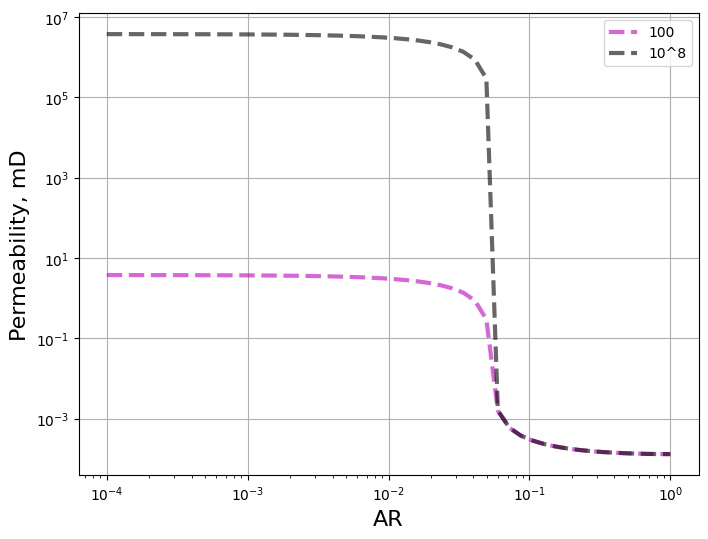

In [ ]:
ar_inclusion_list = np.logspace(-4, 0, num=50, base=10)
porosity = 0.08

calculation_perm_1, calculation_perm_2 =[], []

for ar_inclusion in ar_inclusion_list:
  conc = [1-porosity, porosity]
  alpha_shape = [1, ar_inclusion]
  calculation_perm_1.append(effective_tc(conc, alpha_shape, [10**-4, 10**2]))
  calculation_perm_2.append(effective_tc(conc, alpha_shape, [10**-4, 10**8]))

fig, axs = plt.subplots(figsize=(8, 6))
axs.plot(ar_inclusion_list, calculation_perm_1, 'm--', lw=3, alpha=0.6, label='100')
axs.plot(ar_inclusion_list, calculation_perm_2, 'k--', lw=3, alpha=0.6, label='10^8')
axs.set_yscale('log', base=10)
axs.set_xscale('log', base=10)
axs.set_ylabel('Permeability, mD', fontsize=16)
axs.set_xlabel('AR', fontsize=16)
axs.grid(which='major', axis='both', linestyle='-')
axs.legend(loc='best', fontsize='medium')

Анализ чувствительности «Матричная» проницаемость к АО пор (оценка по диапазону АО, инвертированному по теплопроводности: 0.07-0.28)

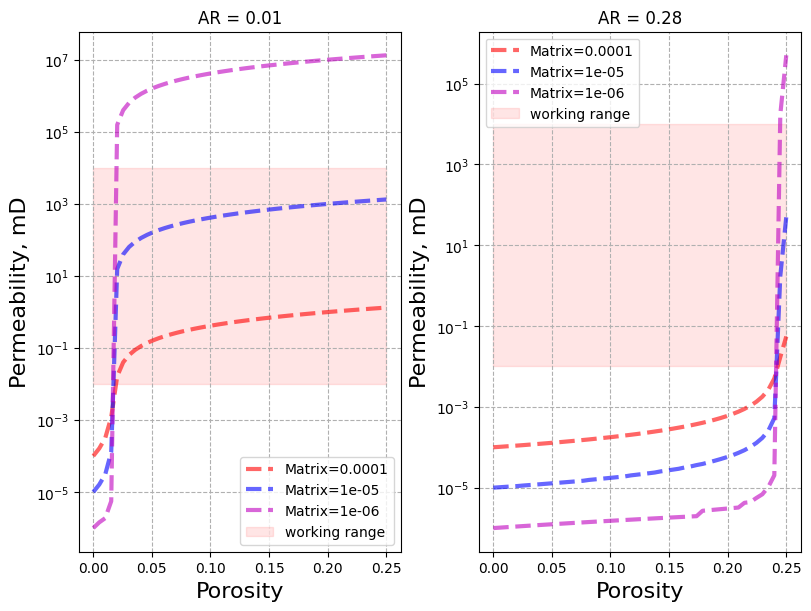

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(8, 6))
axs = fig5.subplots(1, 2, sharex=True)

porosity = np.linspace(0, 0.25, 50)

ar_list = [0.01, 0.28]

for ax, ar_fluid in zip(axs, ar_list):

    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    por = porosity

    alpha_shape = [1, ar_fluid]

    mlam = [10**-4, 10]
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc(conc, alpha_shape, mlam))
    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label=f'Matrix={mlam[0]}')

    mlam = [10**-5, 10**4]
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc(conc, alpha_shape, mlam))
    ax.plot(por, tc_eff_water2, 'b--', lw=3, alpha=0.6, label=f'Matrix={mlam[0]}')

    mlam = [10**-6, 10**8]
    for i in por:
        conc = [1-i, i]
        tc_eff_oil2.append(effective_tc(conc, alpha_shape, mlam))
    ax.plot(por, tc_eff_oil2, 'm--', lw=3, alpha=0.6, label=f'Matrix={mlam[0]}')

    ax.fill_between(porosity, [10**4] * len(porosity), [10**-2] * len(porosity), color='r', alpha=.1, label='working range')

    ax.set_yscale('log', base=10)
    # ax.set_ylim([10**-2, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    ax.set_ylabel('Permeability, mD', fontsize=16)
    ax.set_xlabel('Porosity', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    ax.legend(loc='best', fontsize='medium')
    # ax.set_xlim([0, 0.25])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    ax.set_title(f'AR = {ar_fluid}')

plt.show()

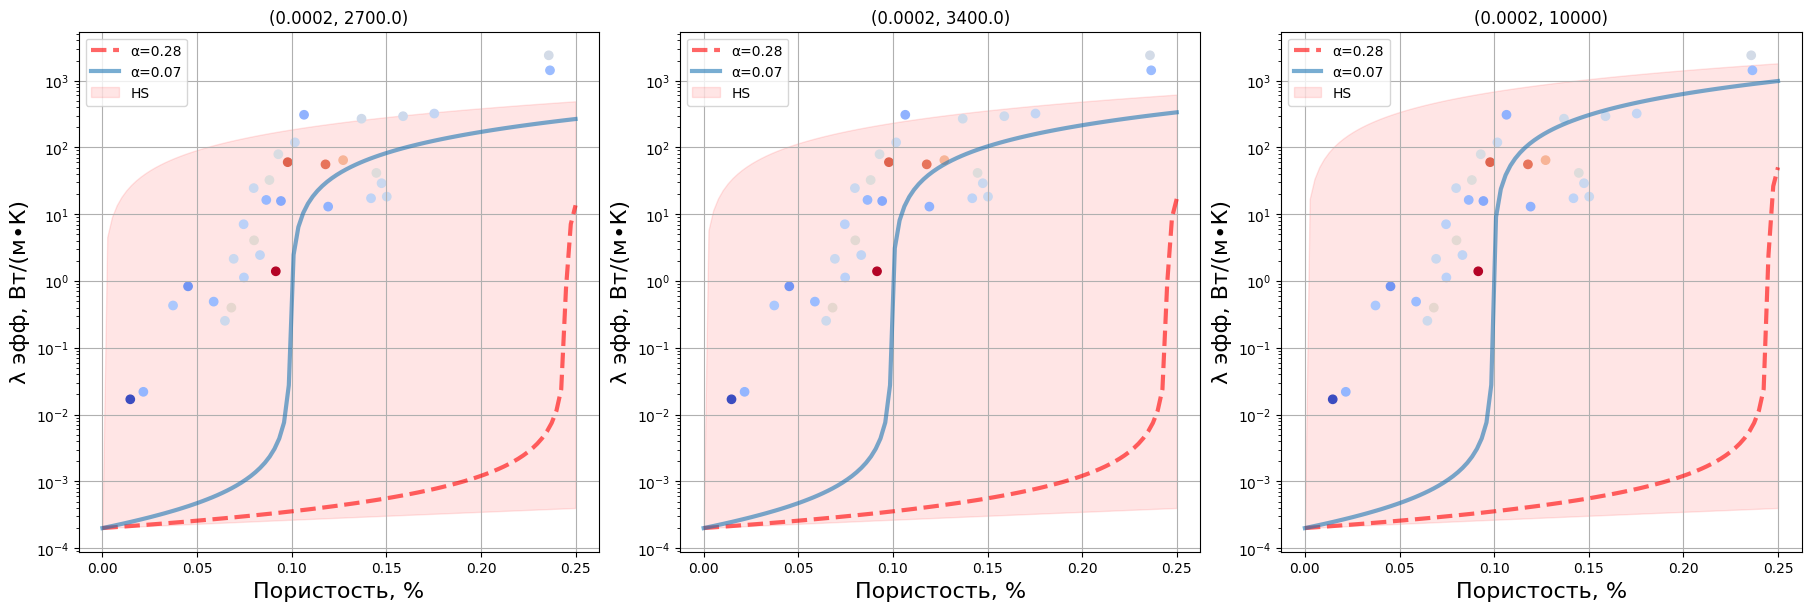

In [ ]:

fig5 = plt.figure(layout='constrained', figsize=(18, 6))
axs = fig5.subplots(1, 3, sharex=True)

porosity = np.linspace(0, 0.25, 100)

mtrx_perm=2*10**-4

# matrix_lam = [(3.03, fluid_lam), (3.45, fluid_lam), (3.97, fluid_lam)] # из уравнения регрессии
matrix_lam = [(mtrx_perm, 2.7*1000),
              (mtrx_perm, 3.4*1000),
              (mtrx_perm, 10**4)]

for ax, mlam in zip(axs, matrix_lam):

    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    ar1, ar2 = [], []
    por = porosity

    alpha_shape = [1, 0.28]
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc(conc, alpha_shape, mlam))

    alpha_shape = [1, 0.07]
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc(conc, alpha_shape, mlam))


    tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []

    for i in porosity:
        conc = [1-i, i]

        tc_hs_up.append(Upper_Hashin_Strikman(conc, mlam))
        tc_hs_dw.append(Lower_Hashin_Strikman(conc, mlam))

    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label='α=0.28')
    ax.plot(por, tc_eff_water2, lw=3, alpha=0.6, label='α=0.07')


    ax.fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')

    ax.set_ylabel('λ эфф, Вт/(м∙К)', fontsize=16)
    ax.set_xlabel('Пористость, %', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    # ax.set_xlim([0, 0.25])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    # Experemental scatter
    ax.set_yscale('log', base=10)
    # ax.set_ylim([10**-2, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    colors = data['AR thermal']  # Assuming 'permeability' contains values to map colors
    ax.scatter(data["Porosity,%"]/100, data["Permeability"], c=colors, cmap='coolwarm', marker='o')

    ax.legend(loc='best', fontsize='medium')
    ax.set_title(f'{mlam}')

plt.show()

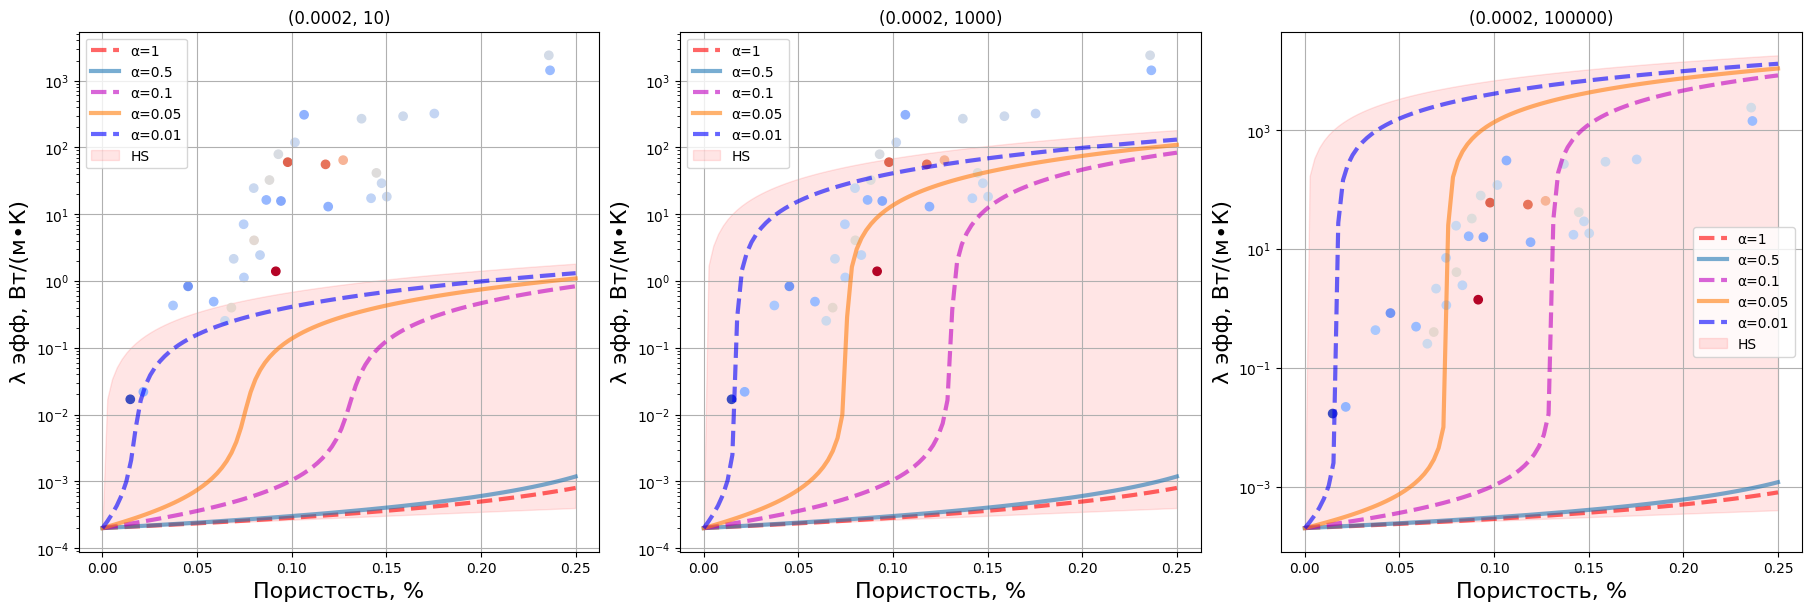

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(18, 6))
axs = fig5.subplots(1, 3, sharex=True)

porosity = np.linspace(0, 0.25, 100)

mtrx_perm=2*10**-4

# matrix_lam = [(3.03, fluid_lam), (3.45, fluid_lam), (3.97, fluid_lam)] # из уравнения регрессии
matrix_lam = [(mtrx_perm, 10**1),
              (mtrx_perm, 10**3),
              (mtrx_perm, 10**5)]

for ax, mlam in zip(axs, matrix_lam):

    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    ar1, ar2 = [], []
    por = porosity

    alpha_shape = [1, 1]
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc(conc, alpha_shape, mlam))

    alpha_shape = [1, 0.5]
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc(conc, alpha_shape, mlam))


    alpha_shape = [1, 0.1]
    for i in por:
        conc = [1-i, i]
        tc_eff_oil2.append(effective_tc(conc, alpha_shape, mlam))

    alpha_shape = [1, 0.05]
    for i in por:
        conc = [1-i, i]
        ar1.append(effective_tc(conc, alpha_shape, mlam))

    alpha_shape = [1, 0.01]
    for i in por:
        conc = [1-i, i]
        ar2.append(effective_tc(conc, alpha_shape, mlam))

    tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []

    for i in porosity:
        conc = [1-i, i]

        tc_hs_up.append(Upper_Hashin_Strikman(conc, mlam))
        tc_hs_dw.append(Lower_Hashin_Strikman(conc, mlam))

    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label='α=1')
    ax.plot(por, tc_eff_water2, lw=3, alpha=0.6, label='α=0.5')
    ax.plot(por, tc_eff_oil2, 'm--', lw=3, alpha=0.6, label='α=0.1')
    ax.plot(por, ar1, lw=3, alpha=0.6, label='α=0.05')
    ax.plot(por, ar2,'b--', lw=3, alpha=0.6, label='α=0.01')




    ax.fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')

    ax.set_ylabel('λ эфф, Вт/(м∙К)', fontsize=16)
    ax.set_xlabel('Пористость, %', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    # ax.set_xlim([0, 0.25])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    # Experemental scatter
    ax.set_yscale('log', base=10)
    # ax.set_ylim([10**-2, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    colors = data['AR thermal']  # Assuming 'permeability' contains values to map colors
    ax.scatter(data["Porosity,%"]/100, data["Permeability"], c=colors, cmap='coolwarm', marker='o')

    ax.legend(loc='best', fontsize='medium')
    ax.set_title(f'{mlam}')

plt.show()

Решение обратной задачи

In [ ]:
idx = 0
porosity = data["Porosity,%"][idx]/100
exp_permeability = data["Permeability"][idx]
ar_pore_initial = data['AR thermal'][idx]
ar_pore = data['AR thermal'][idx]/3
mtrx_perm = 2*10**-4

In [ ]:
porosity, exp_permeability, ar_pore, ar_pore_initial

(0.045249, 0.832741, 0.022227, 0.066681)

In [ ]:
fluid_perm_list = np.logspace(1, 5, num=40, base=10)

calculation_perm =[]

for fluid_comp_perm in fluid_perm_list:
  conc = [1-porosity, porosity]
  alpha_shape = [1, ar_pore]
  components = [mtrx_perm, fluid_comp_perm]
  calculation_perm.append(effective_tc(conc, alpha_shape, components))

In [ ]:

results = pd.DataFrame()
results['Fluid perm'] = fluid_perm_list
results['Calculatioin perm'] = calculation_perm

results['Diff'] = results['Calculatioin perm'].apply(lambda x: abs(np.round((x-exp_permeability)/exp_permeability*100, 2)))

In [ ]:
results = results.sort_values(by=f'Diff')

In [ ]:
results[:3]

Fluid perm  Calculatioin perm   Diff
13  215.443469           0.928042  11.44
12  170.125428           0.733142  11.96
11  134.339933           0.579238  30.44

### Вывод

## Анализ чувствительности
Рассматривая диапазон изменения проницаемости (k) от $10^{-2}$ до $10^{4}$ мД, изменения $k_{matrix}$ не влияют на эффективное значение, поэтому используем одно фиксированное значение $k_{matrix}$=0.0002 мД из уравнения регресиии "Пористость - Пронициемость".

$k_{fluid}$ в большей степени влияет на эффективное значение, однако начиная с $k_{fluid}$ > $10^{6}$, эффективное значение для $AR_{thermal}$: 0.07 - 0.28 не изменяется. Поэтому рассматриваем $k_{fluid}$ в диапазоне от $10^{0}$ до $10^{6}$ мД.

Рассчитать эффективную проницаемость с использованием $AR_{thermal}$: 0.07 - 0.28 не удалось. Если смотреть на анализ чувствительности, то видно, что кривые для разных $AR_{thermal}$ не попадают на экспериментальные значениея проницаемости. Однако, если занизить систематически $AR_{thermal}$ в 3 раза и больше (т.е. $AR_{thermal}$: 0.01 - 0.05), то можно получить приемлемые решения (погрешность 10%) для эффективного k.

Можно ли вообще использовать модель ОСП? Очень странное поведение модели: уменьшение эффективной проницаемости с увеличением АО, при этом на маленьких АО, эффективная проницаемость растет

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

In [ ]:
data_ml = data[['Porosity,%', 'AR thermal', 'TC air','TC oil', 'TC 6', 'TC 60', 'TC 180', 'Permeability']]
data_ml.dropna(inplace=True)

target = data_ml ['Permeability']

<ipython-input-23-35f8357ce9db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml.dropna(inplace=True)


In [ ]:
### BEGIN Solution (do not delete this comment)
X, y = data_ml.iloc[:, :-1], target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0xC0FFEE)
### END Solution (do not delete this comment)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features =list(X.columns)

X_train[features] = scaler.fit_transform(X_train[list(features)])
X_test[features] = scaler.fit_transform(X_test[list(features)])

In [ ]:
### BEGIN Solution

lin_reg = []

MODELS = {
    "Linear Regression": LinearRegression(),
    "Ridge regression" : Ridge(),
    "DecisionTree" : DecisionTreeRegressor()
}

for name, model in MODELS.items():
  clf = model.fit(X_train,y_train)

  y_pred = clf.predict(X_train)
  print(f'Trian RMSL {name}: {mse(y_train, y_pred):.2f}')

  if name=='Linear Regression':
    y_pred = clf.predict(X_test)
    lin_reg = y_pred

  y_pred = clf.predict(X_test)
  print(f'Test RMSL {name}: {mse(y_test, y_pred):.2f}', end='\n\n')

### END Solution

Trian RMSL Linear Regression: 2390.56
Test RMSL Linear Regression: 633942.79

Trian RMSL Ridge regression: 3105.12
Test RMSL Ridge regression: 682398.18

Trian RMSL DecisionTree: 0.00
Test RMSL DecisionTree: 601346.13



In [ ]:
clf = LinearRegression().fit(X_train,y_train)
lin = clf.predict(X)

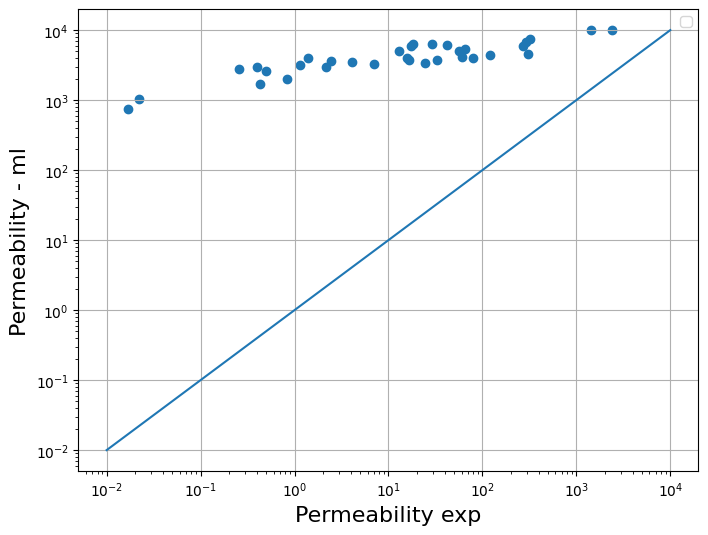

In [ ]:
fig, axs = plt.subplots(figsize=(8, 6))
axs.scatter(target, lin)
axs.plot([10**-2, 10**4], [10**-2, 10**4])
axs.set_yscale('log', base=10)
axs.set_xscale('log', base=10)
axs.set_ylabel('Permeability - ml', fontsize=16)
axs.set_xlabel('Permeability exp', fontsize=16)
axs.grid(which='major', axis='both', linestyle='-')
axs.legend(loc='best', fontsize='medium')

# f-модель

In [11]:
def effective_tc_f(conc, alpha_shape, lam, f):

    x0=0

    phi = conc

    #------------------depolarization factor calculation-----
    def depolarizaton(alpha):
        if alpha < 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(t2-1)
            t5 = np.arctan(t4)
            t8 = t4 ** 2
            form = t2 * (t4-t5) / t8 / t4
            return form
        elif alpha > 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(1-t2)
            t6 = np.log(1+t4)
            t9 = np.log(1-t4)
            t13 = t4 ** 2
            form = t2 * (t6 / 2-t9 / 2-t4) / t13 / t4
            return form
        elif alpha == 1:
            form = 1 / 3
            return form


    depolar_F = []
    for i in alpha_shape:
        depolar_F.append(depolarizaton(i))

    L0 = lam[0]*(1-f) + lam[1]*f

    parall_comp, perpen_comp = [], []
#         print('Тело сравнения', L0)

    for i, j, f in zip(phi, lam, depolar_F):

#             print('Каждая комопонента')
#             print(i, j, f)

        termc_3 = i * j / (L0 * (1-f)+j * f)
        termz_3 = i / (L0 * (1-f)+j * f)

        termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
        termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

        termc_all = (termc_3+2 * termc_12) / 3
        termz_all = (termz_3+2 * termz_12) / 3

        t16 = termc_all # числитель
        t15 = termz_all # Знаменатель

#             print('ТС матрицы', j)
#             print('t16:' , t16)
#             print('t15:' , t15)

        parall_comp.append(t16)  # числитель формулы (матрица, флюид)
        perpen_comp.append(t15)  # знаменатель формулы (матрица, флюид)

#         print('Параллельный компоненты ТС', parall_comp)
#         print('Перпендикулярные компоненты ТС', perpen_comp)

    L_eff = np.sum(parall_comp) / np.sum(perpen_comp)
#         print('TC eff: ', L_eff, end='\n\n')
    return L_eff

### Plot "Porosity - Thermal conductivity with dependecence from f'

In [ ]:
N, n = 100, 6

for f in np.linspace(0, 1, n):

  eff_tc = []

  for porosity in np.linspace(0, 0.1, N):

    conc = [1-porosity, porosity]
    alpha_shape = [1, 10**-2]
    # mlam = [4.00*10**-2, 18.7]
    mlam = [1.82*10**-3, 1.06]

    eff_tc.append(effective_tc_f(conc, alpha_shape, mlam, f))

  plt.plot(np.linspace(0, 1, N),  eff_tc, label=f"{np.round(f, 1)}")
  plt.legend()
plt.xlim(0,1)
# plt.ylim(0,3)
plt.yscale('log')
plt.grid()
plt.xlabel('porosity')
plt.ylabel('conductivity, Sm*m')
plt.title('Porosity - Resestivity with dependecence from f')


Text(0.5, 1.0, 'Porosity - Thermal conductivity with dependecence from f')

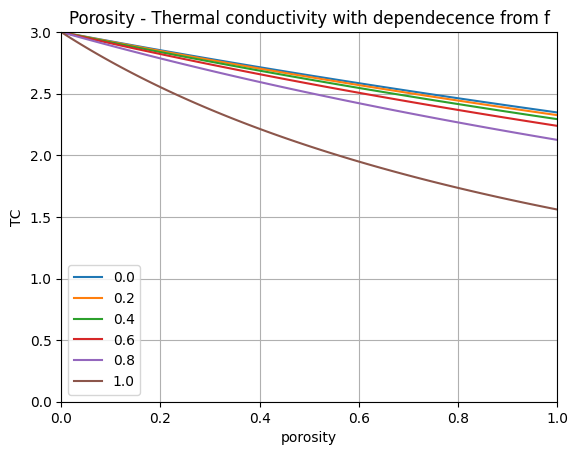

In [ ]:
N, n = 100, 6

for f in np.linspace(0, 1, n):

  eff_tc = []

  for porosity in np.linspace(0, 0.1, N):

    conc = [1-porosity, porosity]
    alpha_shape = [1, 10**-1]
    mlam = [3, 0.12]

    eff_tc.append(effective_tc_f(conc, alpha_shape, mlam, f))

  plt.plot(np.linspace(0, 1, N),  eff_tc, label=f"{np.round(f, 1)}")
  plt.legend()
plt.xlim(0,1)
plt.ylim(0,3)
plt.xlabel('porosity')
plt.ylabel('TC')
plt.grid()
plt.title('Porosity - Thermal conductivity with dependecence from f')


In [ ]:
conc = [1-0.045249, 0.045249]
alpha_shape = [1, 0.04862601580065353]
lam = [3.0975, 0.025]
f = 0.3684210526315789

effective_tc_f(conc, alpha_shape, lam, f)

2.4558010598757014

In [ ]:
3/np.linspace(10**-2, 10**2, 10)

array([3.00000000e+02, 2.69784173e-01, 1.34952767e-01, 8.99820036e-02,
       6.74915636e-02, 5.39956803e-02, 4.49977501e-02, 3.85703266e-02,
       3.37495781e-02, 3.00000000e-02])

In [ ]:
3/0.025, 3/0.12, 3/0.60

(120.0, 25.0, 5.0)

Text(0.5, 1.0, 'Porosity - Thermal conductivity with dependecence from f, Ar=0.0001, e=238.73241463784305')

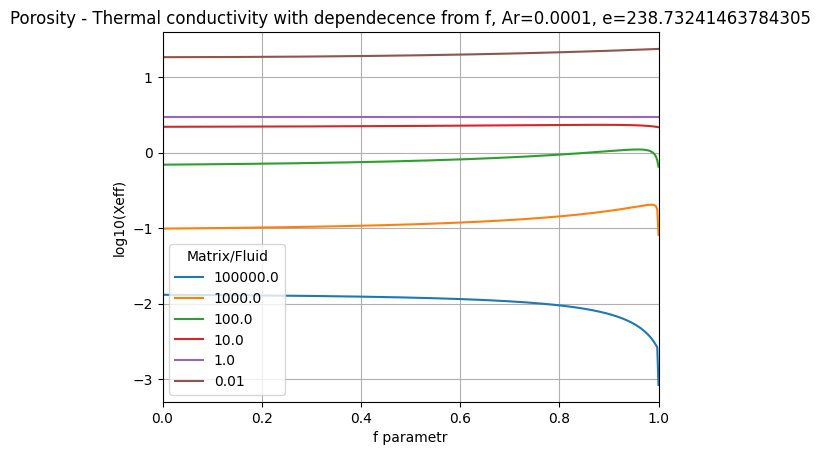

In [ ]:
N, n = 4, 400

matrix = 3
fluid = [3*10**-5, 3*10**-3, 0.03, 3*10**-1, 3*10**0, 3*10**2]
porosity = 10/100
ar = 10**-4
e=3*porosity/(4*pi*ar)

for fluid_comp in fluid:

  eff_tc = []
  m2fluid = []

  for f in np.logspace(-1, 0, n, base=10):

    conc = [1-porosity, porosity]
    alpha_shape = [1, ar]
    mlam = [matrix, fluid_comp]

    eff_tc.append(effective_tc_f(conc, alpha_shape, mlam, f))
    m2fluid.append(matrix/fluid_comp)

  plt.plot(np.linspace(0, 1, n),  np.log10(eff_tc), label=f"{np.round(matrix/fluid_comp, 3)}")
  plt.legend(title='Matrix/Fluid')
plt.xlim(0,1)
# plt.ylim(0,1)
plt.ylabel('log10(Xeff)')
plt.xlabel('f parametr')
plt.grid()
plt.title(f'Porosity - Thermal conductivity with dependecence from f, Ar={alpha_shape[1]}, e={e}')

In [ ]:
K_water, Mu_water, p_water = 2.25, 10**-20, 1.04 ### water
K_air, Mu_air, p_air = 10**-6, 10**-6, 1.22 ### air
K_oil, Mu_oil, p_oil = 1, 10**-12, 1.04

density_air, density_water, density_oil = p_air, p_water, p_oil

K_air_mtrx, Mu_air_mtrx = 53.91373366666666, 27.232519
K_water_mtrx, Mu_water_mtrx = 63.66756566666667, 28.624375

In [ ]:
K_air_mtrx/K_air, Mu_air_mtrx/Mu_air

(53913733.666666664, 27232519.0)

In [ ]:
K_water_mtrx/K_water, Mu_water_mtrx/Mu_water

(28.29669585185185, 2.8624375000000003e+21)

In [ ]:
lam_6, lam_60, lam_180 = 1.060, 8.42, 18.87
lam_mtrx_6, lam_mtrx_60, lam_mtrx_180 = 1.82*10**-3, 1.43*10**-2, 4.00*10**-2

In [ ]:
lam_mtrx_6/lam_6, lam_mtrx_60/lam_60, lam_mtrx_180/lam_180, lam_6/lam_mtrx_6, lam_180/lam_mtrx_180

(0.0017169811320754717,
 0.0016983372921615203,
 0.0021197668256491787,
 582.4175824175825,
 471.75)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

# Assuming x, y, z are your data arrays
x = np.linspace(0, 1, 100)
y = np.logspace(-4, 0, 100, base=10)
z = 3 * x / (4 * np.pi * y)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points as a surface
surf = ax.plot_trisurf(x, y, z, cmap='viridis', linewidth=0.2)

# Set labels and title
ax.set_xlabel('Porosity')
ax.set_ylabel('log(AR)')
ax.set_zlabel('e')



# Adjust viewing angle
# ax.view_init(azim=40)

plt.show()

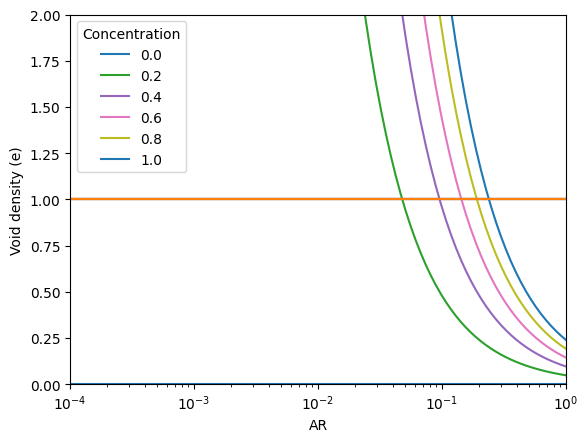

In [ ]:
for porosity in np.linspace(0, 1, 6):

  e_list = []

  for ar in np.logspace(-4, 0, 100, base=10):
      e = 3 * porosity / (4 * np.pi * ar)
      e_list.append(e)

  plt.plot(np.logspace(-4, 0, 100, base=10), e_list, label=f'{np.round(porosity, 2)}')
  plt.plot((10**-4, 10**0), (1, 1))
  plt.xscale('log')
  plt.ylim(0,2)
  plt.xlim(10**-4, 10**0)

  plt.xlabel('AR')
  plt.ylabel('Void density (e)')
  plt.legend(title='Concentration')

In [ ]:
# for porosity in np.linspace(0, 0.25, 3):
for porosity in [0.05, 0.1, 0.15, 0.2, 0.25]:

  e_list = []

  for ar in np.logspace(-4, 0, 100, base=10):
      e = 3 * porosity / (4 * np.pi * ar)
      e_list.append(e)

  plt.plot(np.logspace(-4, 0, 100, base=10), e_list, label=f'{porosity}')
  plt.plot((10**-4, 10**0), (1, 1))
  plt.xscale('log')
  plt.ylim(0,2)
  plt.xlim(10**-4, 10**0)

  plt.xlabel('AR')
  plt.ylabel('Void density (e)')
  plt.legend()

### Sensetive study

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(8, 6))
axs = fig5.subplots(1, 2, sharex=True)

porosity = np.linspace(0, 0.25, 50)

ar = 0.13
lam_matrix = 10**-4

lam_fluid=[10**2, 10**4]

for ax, l_fluid in zip(axs,lam_fluid):

    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    list1, list2, list3 = [], [], []
    por = porosity

    alpha_shape = [1, ar]

    mlam = [lam_matrix, l_fluid]

    f=0.05
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label=f'f={f}')

    f=0.1
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, tc_eff_water2, 'b--', lw=3, alpha=0.6, label=f'f={f}')

    f=0.15
    for i in por:
        conc = [1-i, i]
        tc_eff_oil2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, tc_eff_oil2, 'm--', lw=3, alpha=0.6, label=f'f={f}')


    f=0.2
    for i in por:
        conc = [1-i, i]
        list1.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, list1, lw=3, alpha=0.6, label=f'f={f}')


    f=0.4
    for i in por:
        conc = [1-i, i]
        list2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, list2, lw=3, alpha=0.6, label=f'f={f}')


    f=0.6
    for i in por:
        conc = [1-i, i]
        list3.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, list3, lw=3, alpha=0.6, label=f'f={f}')

    ax.fill_between(porosity, [10**4] * len(porosity), [10**-2] * len(porosity), color='r', alpha=.1, label='working range')

    ax.set_yscale('log', base=10)
    ax.set_ylim([10**-2, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    ax.set_ylabel('Permeability, mD', fontsize=16)
    ax.set_xlabel('Porosity', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    ax.legend(loc='best', fontsize='medium')
    # ax.set_xlim([0, 0.25])
    ax.set_ylim([10**0, 10**4])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    ax.set_title(f'ki fluid = {l_fluid}, AR=0.13')

plt.show()

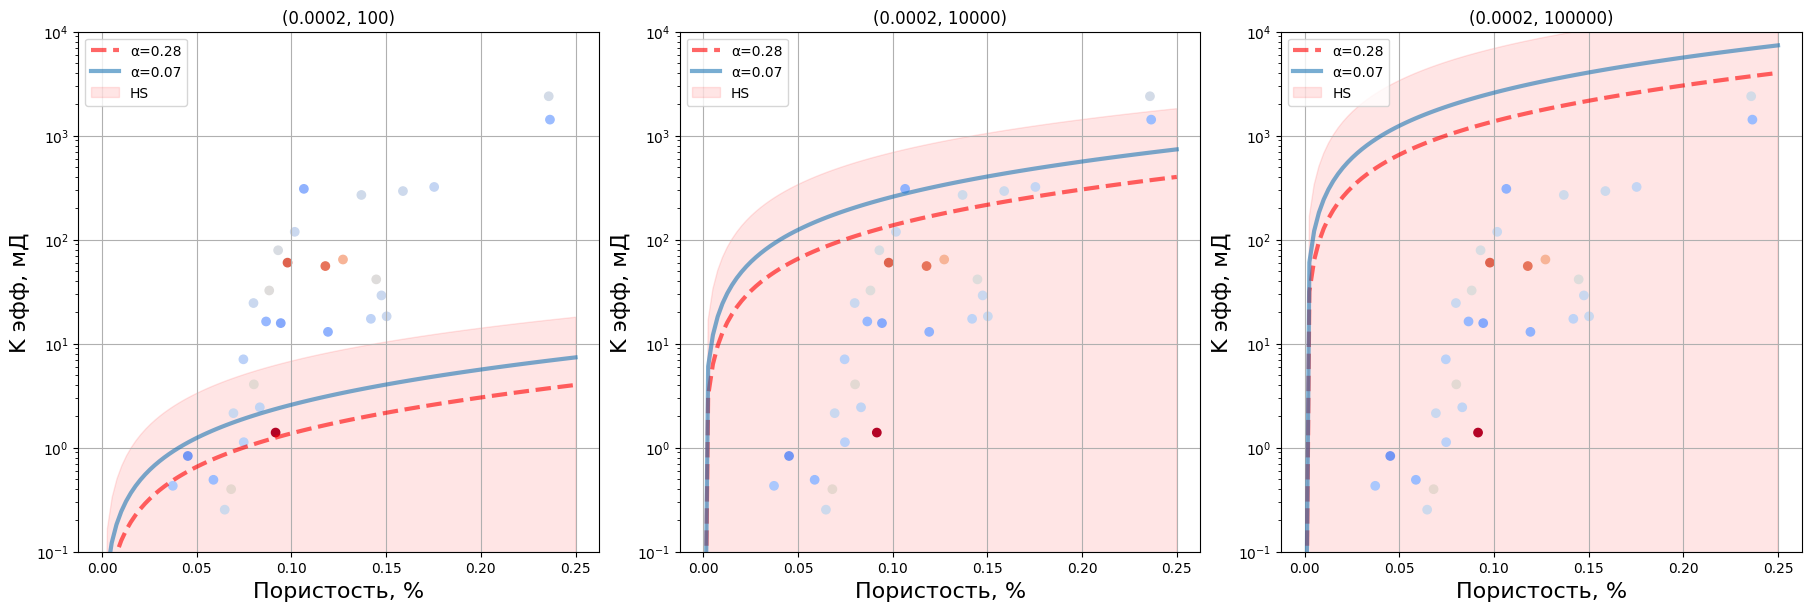

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(18, 6))
axs = fig5.subplots(1, 3, sharex=True)

porosity = np.linspace(0, 0.25, 100)

mtrx_perm=2*10**-4

# matrix_lam = [(3.03, fluid_lam), (3.45, fluid_lam), (3.97, fluid_lam)] # из уравнения регрессии
matrix_lam = [(mtrx_perm, 10**2),
              (mtrx_perm, 10**4),
              (mtrx_perm, 10**5)]

f=0.05

for ax, mlam in zip(axs, matrix_lam):

    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    ar1, ar2 = [], []
    por = porosity

    alpha_shape = [1, 0.28]
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc_f(conc, alpha_shape, mlam, f))

    alpha_shape = [1, 0.07]
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc_f(conc, alpha_shape, mlam, f))


    tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []

    for i in porosity:
        conc = [1-i, i]

        tc_hs_up.append(Upper_Hashin_Strikman(conc, mlam))
        tc_hs_dw.append(Lower_Hashin_Strikman(conc, mlam))

    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label='α=0.28')
    ax.plot(por, tc_eff_water2, lw=3, alpha=0.6, label='α=0.07')


    ax.fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')

    ax.set_ylabel('K эфф, мД', fontsize=16)
    ax.set_xlabel('Пористость, %', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    # ax.set_xlim([0, 0.25])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    # Experemental scatter
    ax.set_yscale('log', base=10)
    ax.set_ylim([10**-1, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    colors = data['AR thermal']  # Assuming 'permeability' contains values to map colors
    ax.scatter(data["Porosity,%"]/100, data["Permeability"], c=colors, cmap='coolwarm', marker='o')

    ax.legend(loc='best', fontsize='medium')
    ax.set_title(f'{mlam}')

plt.show()

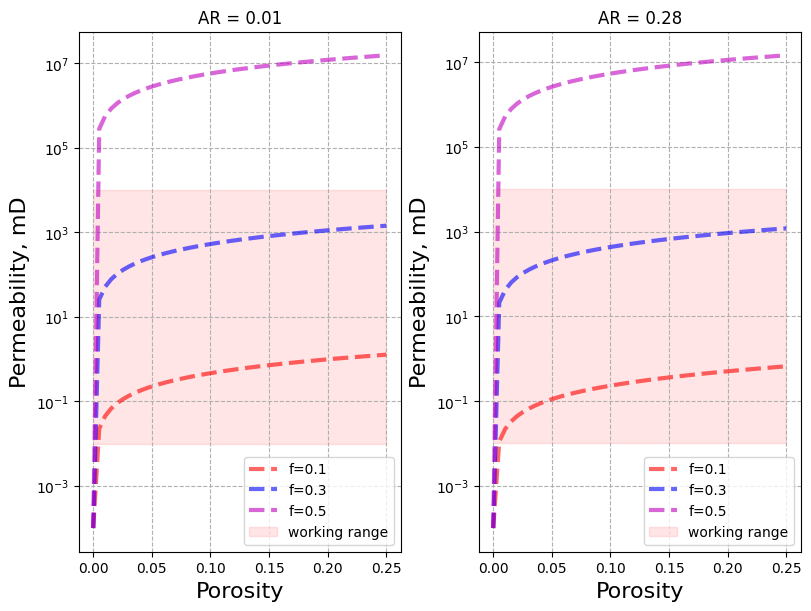

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(8, 6))
axs = fig5.subplots(1, 2, sharex=True)

porosity = np.linspace(0, 0.25, 50)
matrix = 10**-4

ar_list = [0.01, 0.28]

for ax, ar_fluid in zip(axs, ar_list):


    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    por = porosity
    alpha_shape = [1, ar_fluid]

    f = 0.1
    mlam = [matrix, 10]
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label=f'f={f}')

    f = 0.3
    mlam = [matrix, 10**4]
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, tc_eff_water2, 'b--', lw=3, alpha=0.6, label=f'f={f}')

    f = 0.5
    mlam = [matrix, 10**8]
    for i in por:
        conc = [1-i, i]
        tc_eff_oil2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, tc_eff_oil2, 'm--', lw=3, alpha=0.6, label=f'f={f}')

    ax.fill_between(porosity, [10**4] * len(porosity), [10**-2] * len(porosity), color='r', alpha=.1, label='working range')

    ax.set_yscale('log', base=10)
    # ax.set_ylim([10**-2, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    ax.set_ylabel('Permeability, mD', fontsize=16)
    ax.set_xlabel('Porosity', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    ax.legend(loc='best', fontsize='medium')
    # ax.set_xlim([0, 0.25])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    ax.set_title(f'AR = {ar_fluid}')

plt.show()

### Inverse problem

In [ ]:
path_to_ser = Path('/content/f model.xlsx')
df_ues = pd.read_excel(path_to_ser,skiprows=0)

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
data = df_ues.copy()
data.drop('#', axis=1, inplace=True)

In [ ]:
data.dropna(subset=['AR thermal'], inplace=True)

In [ ]:
idx = 27
porosity = data["Porosity,%"][idx]/100
exp_permeability = data["Permeability"][idx]
ar_pore_initial = data['AR thermal'][idx]
ar_pore = data['AR thermal'][idx]
mtrx_perm = 2*10**-4

In [ ]:
print(porosity,ar_pore)

0.014711499999999999 0.022491


In [ ]:
### Ограничение на максимальное значение параметр связаности f через уравнение уравнение Козени– Кармана, о связи пористости и проницаемости
kmin, kmax, kreal = 0.0169466, 2393.99, exp_permeability
fmax = 1 - (np.log(kmax/kreal)/np.log(kmax/kmin))
print(f"fmax: {np.round(fmax, 2)}")
print(f"k/φ {np.round(kreal/porosity, 2)}")

fmax: 0.0
k/φ 1.15


In [ ]:
N = 200
fluid_perm_list = []
# f_list = np.linspace(0., fmax, N)
f_list = []
calculation_perm =[]

for fluid_comp_perm in np.logspace(1, 5, num=N, base=10):
  for f in np.linspace(0., 1, N):
    conc = [1-porosity, porosity]
    alpha_shape = [1, ar_pore]
    components = [mtrx_perm, fluid_comp_perm]
    calculation_perm.append(effective_tc_f(conc, alpha_shape, components, f))
    fluid_perm_list.append(fluid_comp_perm)
    f_list.append(f)

In [ ]:
results = pd.DataFrame()
results[f'Sample_{idx}'] = [data["Sample"][idx]]*N**2
results[f'Porosity_{idx}'] = [data["Porosity,%"][idx]]*N**2
results[f'Fluid perm_{idx}'] = fluid_perm_list
results[f'f_{idx}'] = f_list

results[f'Calculatioin perm_{idx}'] = calculation_perm
results[f'Expermental_{idx}'] = [exp_permeability]*len(calculation_perm)

### Байссовский подход
results[f'Diff_{idx}'] = abs((results[f'Calculatioin perm_{idx}'] - results[f'Expermental_{idx}'])/results[f'Expermental_{idx}']*100)
results['p(B|Ai)'] = np.exp(-results[f'Diff_{idx}']**2)
results['p(Ai|b)'] = np.exp(-results[f'Diff_{idx}']**2) / np.sum(results['p(B|Ai)'])

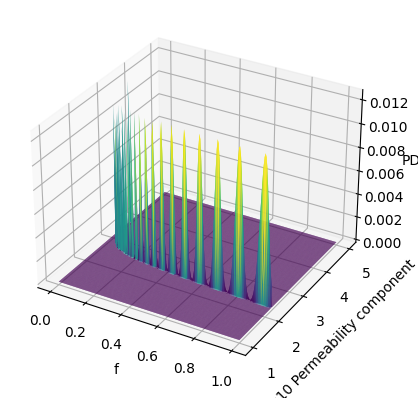

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming x, y, z are your data arrays
x = results[f'f_{idx}']
y = np.log10(results[f'Fluid perm_{idx}'])
z = results['p(Ai|b)']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points as a surface
surf = ax.plot_trisurf(x, y, z, cmap='viridis', linewidth=0.2)

# Set labels and title
ax.set_xlabel('f')
ax.set_ylabel('Lg10 Permeability component')
ax.set_zlabel('PDF')

plt.show()

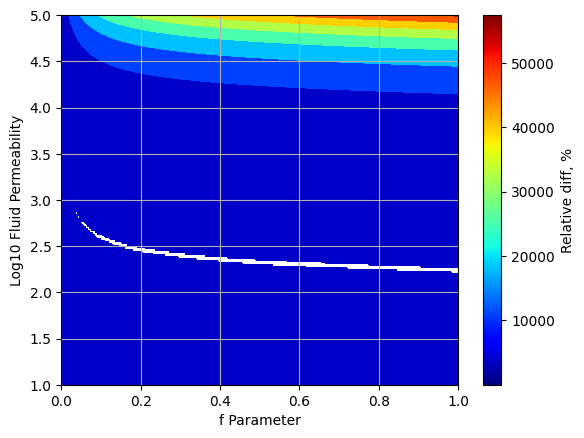

In [ ]:
scatter = plt.scatter(results[f'f_{idx}'], np.log10(results[f'Fluid perm_{idx}']),
                      c=results[f'Diff_{idx}'], cmap='jet', marker='o')


masked_diff_filled = np.where(results[f'Diff_{idx}'] < 8, -1, results[f'Diff_{idx}'])
cmap = plt.cm.jet
cmap.set_under('white')  # Set the color for the value -1 to white
contour = plt.tricontourf(results[f'f_{idx}'], np.log10(results[f'Fluid perm_{idx}']), masked_diff_filled, cmap=cmap, vmin=-1)

plt.xlabel('f Parameter')
plt.ylabel('Log10 Fluid Permeability')

colorbar = plt.colorbar(scatter)
colorbar.set_label('Relative diff, %')

plt.xlim(0, 1)
plt.ylim(1, 5)

plt.grid()

plt.show()

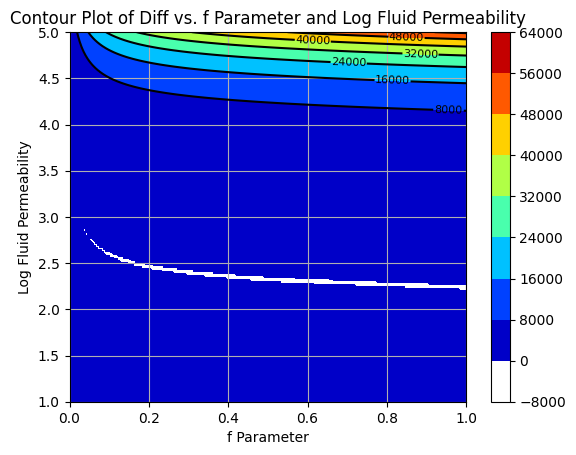

In [ ]:
# plt.figure(figsize=(8, 6))
masked_diff_filled = np.where(results[f'Diff_{idx}'] < 8, -1, results[f'Diff_{idx}'])


cmap = plt.cm.jet
cmap.set_under('white')  # Set the color for the value -1 to white

contour = plt.tricontourf(results[f'f_{idx}'], np.log10(results[f'Fluid perm_{idx}']), masked_diff_filled, cmap=cmap, vmin=-1)


contour_lines = plt.tricontour(results[f'f_{idx}'], np.log10(results[f'Fluid perm_{idx}']), results[f'Diff_{idx}'], colors='k')
plt.clabel(contour_lines, inline=True, fontsize=8)  # Add labels to the isolines


plt.colorbar(contour)

plt.xlabel('f Parameter')
plt.ylabel('Log Fluid Permeability')
plt.title('Contour Plot of Diff vs. f Parameter and Log Fluid Permeability')
plt.grid(True)
plt.show()

In [ ]:
results = results.sort_values(by=f'Diff_{idx}')
filtered_results = results[results[f'Diff_{idx}'] < 8]
# Save the filtered results to an Excel file
filtered_results.to_excel(f'{data["Sample"][idx]}_{idx}.xlsx', index=False)
# filtered_results.to_csv(f'{data["Sample"][idx]}.csv', index=False)  # This will save the DataFrame to a CSV file without including the index

In [ ]:
filtered_results[:5]

Sample_2  Porosity_2  Fluid perm_2       f_2  Calculatioin perm_2  Expermental_2    Diff_2  \
12590    113536   15.024288    176.291412  0.954774            18.334146        18.3346  0.002476   
15228    113536   15.024288    337.006433  0.140704            18.333369        18.3346  0.006712   
13488    113536   15.024288    222.194686  0.442211            18.340447        18.3346  0.031888   
12939    113536   15.024288    193.389175  0.698492            18.325931        18.3346  0.047283   
13119    113536   15.024288    202.550194  0.597990            18.323945        18.3346  0.058113   

        p(B|Ai)   p(Ai|b)  
12590  0.999994  0.012575  
15228  0.999955  0.012575  
13488  0.998984  0.012562  
12939  0.997767  0.012547  
13119  0.996629  0.012533

Text(0.5, 0, 'Ki components, mD')

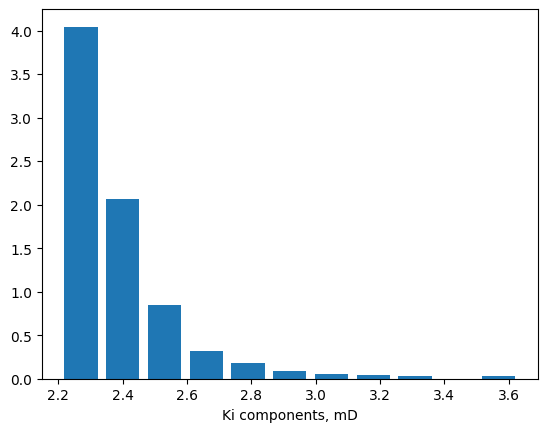

In [ ]:
plt.hist(np.log10(filtered_results[f'Fluid perm_{idx}']), bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8)
plt.xlabel('Ki components, mD')

Text(0.5, 0, 'f parametr')

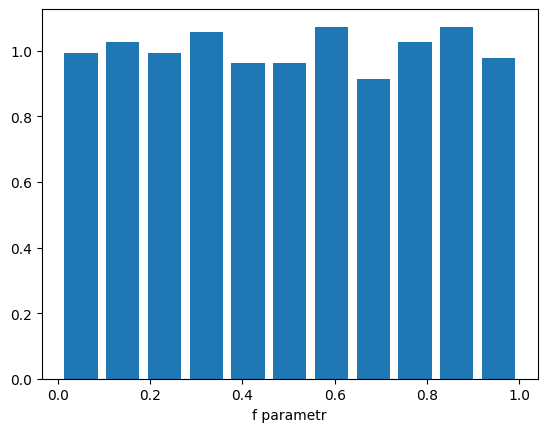

In [ ]:
plt.hist((filtered_results[f'f_{idx}']), bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8)
plt.xlabel('f parametr')

### Расчет параметра f через плотность трещин при разной пористости (по статье Березиной)

In [ ]:
def f_from_e(phi, alpha): #https://doi.org/10.3390/app121910185 - Berezina and Bayuk, 2022

  f = 0
  e = 3*phi/100/(4*np.pi*alpha)

  if phi <= 2:
    if np.log10(e) >= -3.5:
      f = 0.04*np.log10(e**2)+0.51*np.log10(e)+1.30
      print(f)
    else:
      f = 0.15

  elif phi > 2 and phi <=5:
    if np.log10(e) >= -3.0:
      f = 0.07*np.log10(e**2)+0.56*np.log10(e)+1.18
    else:
      f = 0.18

  elif phi > 5 and phi <=10:
    if np.log10(e) >= -3.0:
      f = 0.09*np.log10(e)**2+0.56*np.log10(e)+1.10
    else:
      f = 0.20

  elif phi > 10 and phi <=15:
    if np.log10(e) >= -2.5:
      f = 0.10*np.log10(e)**2+0.54*np.log10(e)+1.07
    else:
      f = 0.30

  elif phi > 15 and phi <=20:
    if np.log10(e) >= -2.0:
      f = 0.07*np.log10(e)**2+0.42*np.log10(e)+1.01
    else:
      f = 0.40

  return f

9.789559467455616 0.242103 0.6241973988096589


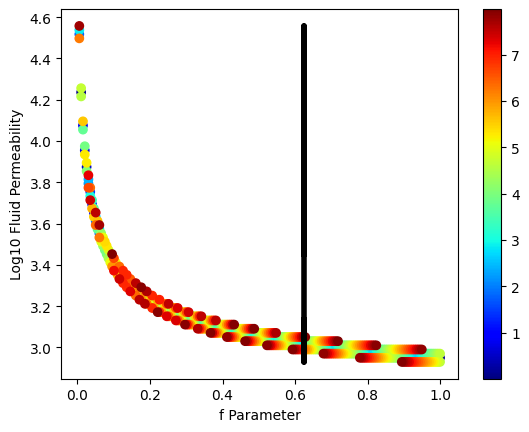

In [ ]:
scatter = plt.scatter(filtered_results[f'f_{idx}'], np.log10(filtered_results[f'Fluid perm_{idx}']),
                      c=filtered_results[f'Diff_{idx}'], cmap='jet', marker='o')

plt.colorbar(scatter)  # Add color bar to the plot
plt.xlabel('f Parameter')
plt.ylabel('Log10 Fluid Permeability')


porosity = data["Porosity,%"][idx]
ar_pore = data['AR thermal'][idx]
f = f_from_e(porosity, ar_pore)

print(porosity,ar_pore, f)

f_list = [f for _ in range(len(filtered_results[f'f_{idx}']))]
plt.plot(f_list,  np.log10(filtered_results[f'Fluid perm_{idx}']), color='black', lw=4)


3.5611613848643877 0.22102335086940447


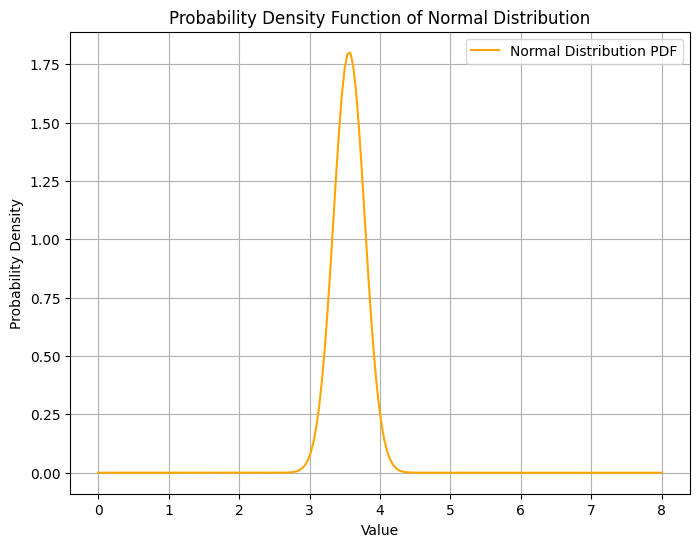

In [ ]:
from scipy.stats import norm

# Parameters of the normal distribution
data = data = np.log10(filtered_results[f'Fluid perm_{idx}'])
mean = np.mean(data)
std_dev = np.std(data)
print(mean, std_dev)

# Generate data points for the PDF
x = np.linspace(0, 8, 200)
pdf = norm.pdf(x, mean, std_dev)

plt.figure(figsize=(8, 6))

plt.plot(x, pdf, label='Normal Distribution PDF', color='orange')

plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Probability Density Function of Normal Distribution')
plt.legend()
plt.grid(True)
plt.show()

### Direct problem with selected parametrs for permeability

In [ ]:
path_to_ser = Path('/content/NewElasticity_v1/Tver_ver1.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='All properties_data', skiprows=0)

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
data = df_ues.copy()
data.drop('#', axis=1, inplace=True)

In [ ]:
data.dropna(subset=['AR thermal'], inplace=True)

In [ ]:
porosity = data["Porosity,%"]
ar_pore = data['AR thermal']

for i, j in zip(porosity, ar_pore):
  print(f_from_e(i,j))

NameError: name 'f_from_e' is not defined

In [ ]:
porosity = data["Porosity,%"]
exp_permeability = data["Permeability"]
ar_pore_initial = data['AR thermal']
ar_pore = data['AR thermal']
mtrx_perm = 2*10**-4
# fluid_comp =
# fluid_perm = 10**2.8
# f = 0.3

import math
calculation_perm =[]

# table = pd.DataFrame()
# table['f mean'] = all_means_f
# table['porosity'] = all_porosity
# table['K i'] = all_means_i


for ar, por, fluid_perm in zip(ar_pore, porosity, all_means_i):

  por = por/100
  conc = [1-por, por]
  alpha_shape = [1, ar]

  # fluid_perm = 1.4097*np.log(por*100)-0.6603

  components = [mtrx_perm, fluid_perm]
  f = f_from_e(por*100, ar)
  print(por, f, components)
  calculation_perm.append(effective_tc_f(conc, alpha_shape, components, f))

0.045249 0.7810705277902696 [0.0002, 1.2218125796697292]
0.06473371285951457 0.6535319026382558 [0.0002, 2.3918744586751606]
0.1502428813868614 0.7949449247949966 [0.0002, 2.3911453306236097]
0.1419265364023713 0.7998051104973494 [0.0002, 2.5228488268415763]
0.09432965948473461 0.814881602137336 [0.0002, 3.2532228554894855]
0.09294072678275303 0.7038421780410956 [0.0002, 2.892180568791246]
0.0882413294197936 0.688042552190449 [0.0002, 1.5003329913981576]
0.07476560681237662 0.6978642942025601 [0.0002, 0]
0.06812695477572067 0.6342792247208193 [0.0002, 1.1705684812253223]
0.08326069547301873 0.7105791998980127 [0.0002, 1.7856434269479184]
0.08011973979984602 0.6647902228188343 [0.0002, 2.0358222656107534]
0.1753453832771655 0.8237546919284073 [0.0002, 3.5611613852920962]
0.07992399227956115 0.6933441950989695 [0.0002, 2.8098667731025326]
0.09789559467455616 0.6241973988096589 [0.0002, 3.1337999922016238]
0.2358372317110681 0 [0.0002, 4.276966028363398]
0.09160330411903464 0.592835684538

In [ ]:
results = pd.DataFrame()
results['Sample'] = data["Sample"]
results['Porosity'] = data["Porosity,%"]
results['Calculatioin perm'] = np.log10(calculation_perm)
results['Expermental'] = np.log10(exp_permeability)


results['Abs Error'] = np.abs((results['Calculatioin perm'] - results['Expermental']))
results['Relative Error'] = np.abs((results['Calculatioin perm'] - results['Expermental']) / results['Expermental']) * 100

In [ ]:
results

Sample   Porosity  Calculatioin perm  Expermental  Abs Error  Relative Error
0   113480   4.524900          -1.457830    -0.079490   1.378340     1733.977919
1   113532   6.473371          -1.034441    -0.595674   0.438766       73.658742
2   113536  15.024288          -0.627693     1.263271   1.890964      149.687889
3   113541  14.192654          -0.629701     1.239147   1.868847      150.817277
4   113556   9.432966          -0.701924     1.198024   1.899948      158.590113
5   113566   9.294073          -0.780215     1.898270   2.678485      141.101375
6   113572   8.824133          -1.091379     1.511726   2.603105      172.194241
7   113577   7.476561          -3.843652     0.053109   3.896761     7337.262864
9   113603   6.812695          -1.326248    -0.398691   0.927557      232.650650
10  113619   8.326070          -1.036937     0.388513   1.425450      366.898660
11  113622   8.011974          -1.007422     0.609196   1.616619      265.369115
12  113704  17.534538          -0.378775     2.507026   2.885800      115.108533
13  113724   7.992399          -0.862252     1.390921   2.253173      161.991472
14  113726   9.789559          -0.742122     1.779291   2.521413      141.708838
15  113728  23.583723          -3.174835     3.379122   6.553957      193.954418
16  113735   9.160330          -1.092225     0.145656   1.237882      849.865049
17  113754  11.926943          -0.737961     1.113776   1.851738      166.257598
18  129473  11.786910          -0.666430     1.746547   2.412977      138.156997
19  129498  13.689575          -0.496125     2.430077   2.926201      120.416012
20  129524  14.749640          -0.599813     1.464124   2.063938      140.967379
21  129552  14.474410          -0.586026     1.618496   2.204521      136.208046
22  129563  15.885169          -0.427184     2.467473   2.894658      117.312617
23  129688   8.657731          -0.847668     1.213863   2.061531      169.832276
24  129693  10.653592          -0.585437     2.488749   3.074186      123.523336
25  129744   3.731300          -1.512956    -0.366437   1.146520      312.883471
26  129750   2.162350          -1.813239    -1.658880   0.154359        9.304993
27  129817   1.471150          -1.972964    -1.770917   0.202047       11.409157
28  129822   6.934715          -1.120979     0.332178   1.453157      437.463476
29  129845   7.459951          -0.979195     0.849865   1.829060      215.217712
30  129897  23.648542          -3.077586     3.154375   6.231961      197.565623
31  129913  10.171065          -0.666482     2.075609   2.742091      132.110185
32  129914   5.877850          -1.352769    -0.308544   1.044225      338.436312
33  129937  12.718631          -0.619093     1.809618   2.428710      134.211254

[]

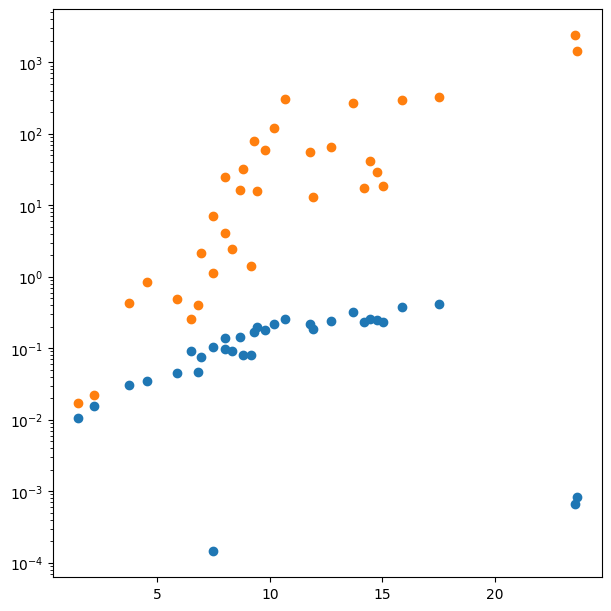

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(6, 6))
ax = fig5.subplots(1, 1, sharex=True)

ax.scatter(results['Porosity'], 10**results['Calculatioin perm'])
ax.scatter(results['Porosity'], 10**results['Expermental'])
ax.set_yscale('log', base=10)
# ax.set_xscale('log', base=10)
# ax.set_xlim([10**-2, 10**4])
# ax.set_ylim([10**-2, 10**4])

# ax.plot([-2, -2], [-2,4])

plt.plot()

[]

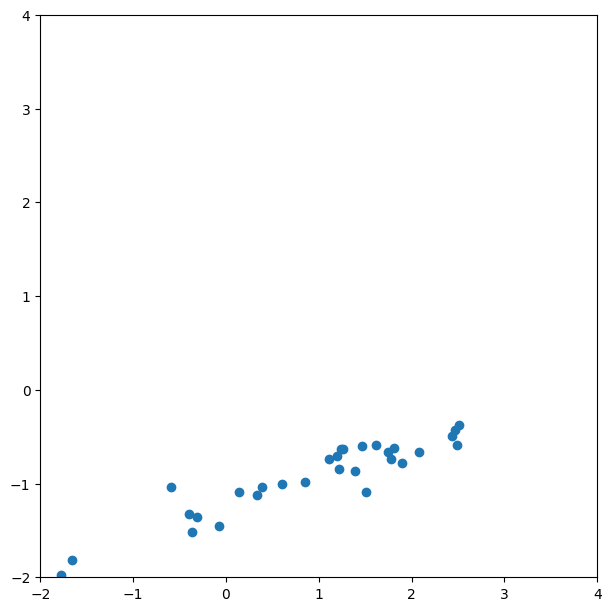

In [ ]:

fig5 = plt.figure(layout='constrained', figsize=(6, 6))
ax = fig5.subplots(1, 1, sharex=True)

ax.scatter(results['Expermental'], results['Calculatioin perm'])
# ax.set_yscale('log', base=10)
# ax.set_xscale('log', base=10)
# ax.set_xlim([10**-2, 10**4])
# ax.set_ylim([10**-2, 10**4])

# ax.plot([-2, -2], [-2,4])
ax.set_xlim([-2, 4])
ax.set_ylim([-2, 4])
plt.plot()

[]

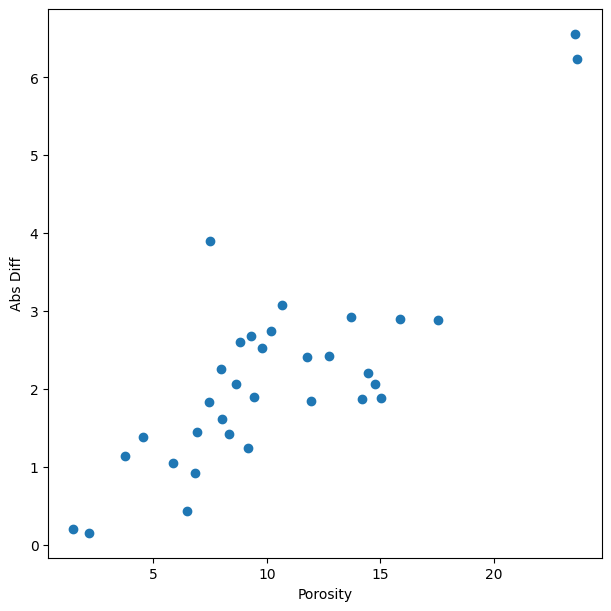

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(6, 6))
ax = fig5.subplots(1, 1, sharex=True)

ax.scatter(results['Porosity'], results['Abs Error'])
# ax.set_yscale('log', base=10)
# ax.set_xscale('log', base=10)
# ax.set_xlim([10**-2, 10**4])
# ax.set_ylim([10**-2, 10**4])
plt.xlabel('Porosity')
plt.ylabel('Abs Diff')
# plt.ylim(0, 200)
plt.plot()

### Plots for all samples

In [ ]:
path_to_ser = Path('/content/Tver_book_perm_1.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='PERM_INVERSE', skiprows=0)

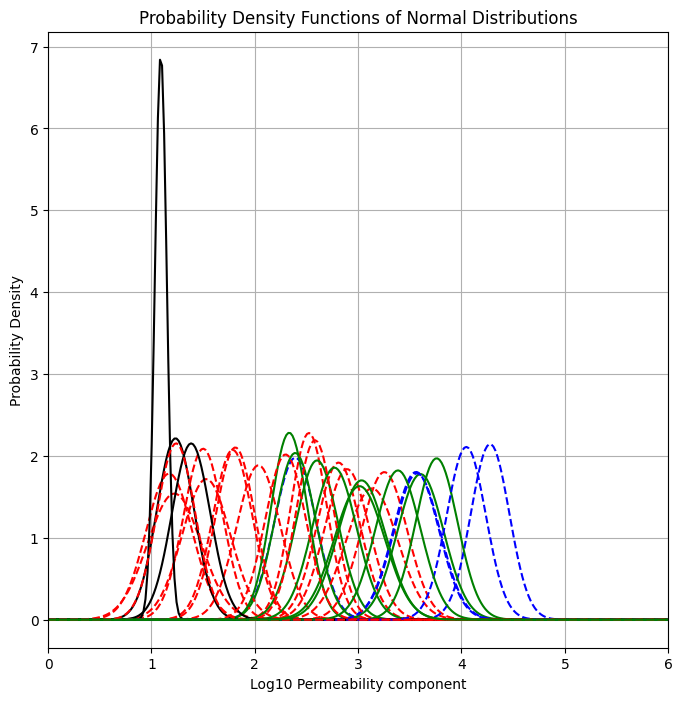

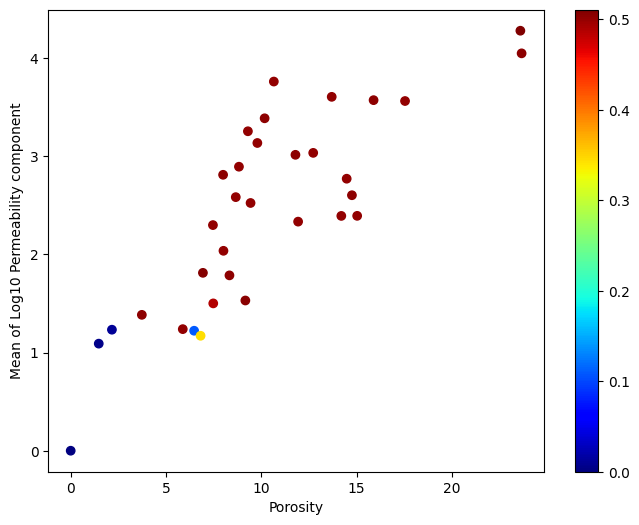

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Initialize an empty array to store all PDFs
all_pdfs = []
all_means_i = []
all_means_f = []
all_porosity = []


# Define the color map for different porosity ranges
colors = ['black', 'red', 'green', 'blue']
linestyle=['solid', 'dashed', 'solid', 'dashed']

for i in range(1, 34):
  if i == 8:
    all_means_i.append(0)
    all_porosity.append(0)
    all_means_f.append(0)
  else:
    # Parameters of the normal distribution
    data = np.log10(df_ues[f'Fluid perm_{i}'])
    mean = np.mean(data)
    std_dev = np.std(data)

    f_param = np.mean(df_ues[f'f_{i}'])

    # Generate data points for the PDF
    x = np.linspace(0, 10, 500)
    pdf = norm.pdf(x, mean, std_dev)

    # Determine the color based on porosity values
    porosity = df_ues[f'Porosity_{i}'][0]

    if porosity < 5:
      color_index, linestyle_index = 0, 0  # Default color is black
      # print(porosity, color_index)
    if porosity > 5 and porosity < 10:
        color_index, linestyle_index = 1, 1  # Red
        # print(porosity, color_index)
    if porosity > 10 and porosity < 15:
        color_index, linestyle_index = 2, 2  # Green
        # print(porosity, color_index)
    if porosity > 15:
      color_index, linestyle_index = 3, 3  # Green

    # Append the PDF and color to the array
    all_pdfs.append((pdf, colors[color_index], linestyle[linestyle_index] ))
    all_means_i.append(mean)
    all_porosity.append(porosity)
    all_means_f.append(f_param)

# Plot all PDFs on the same plot with different colors
plt.figure(figsize=(8, 8))

for pdf, color, linestyle in all_pdfs:
    plt.plot(x, pdf, color=color, linestyle=linestyle)

plt.xlabel('Log10 Permeability component')
plt.ylabel('Probability Density')
plt.title('Probability Density Functions of Normal Distributions')
plt.xlim(0, 6)
plt.grid(True)


plt.figure(figsize=(8, 6))
scatter = plt.scatter(all_porosity, all_means_i,
                      c=all_means_f, cmap='jet', marker='o')
plt.xlabel('Porosity')
plt.ylabel('Mean of Log10 Permeability component')
plt.colorbar(scatter)  # Add color bar to the plot
# plt.xlim(0, 25)
# plt.ylim(0, 1)


plt.show()

In [ ]:
table = pd.DataFrame()
table['f mean'] = all_means_f
table['porosity'] = all_porosity
table['K i'] = all_means_i

In [ ]:
table

f mean   porosity       K i
0   0.108129   6.473371  1.221813
1   0.502164  15.024288  2.391874
2   0.502328  14.192654  2.391145
3   0.501697   9.432966  2.522849
4   0.502426   9.294073  3.253223
5   0.502525   8.824133  2.892181
6   0.487922   7.476561  1.500333
7   0.000000   0.000000  0.000000
8   0.343650   6.812696  1.170568
9   0.504391   8.326069  1.785643
10  0.501736   8.011974  2.035822
11  0.502463  17.534538  3.561161
12  0.502910   7.992399  2.809867
13  0.502484   9.789559  3.133800
14  0.510760  23.583723  4.276966
15  0.506646   9.160330  1.529835
16  0.502650  11.926943  2.332895
17  0.503081  11.786910  3.013320
18  0.501979  13.689575  3.603701
19  0.502811  14.749640  2.601802
20  0.502477  14.474410  2.769990
21  0.503007  15.885169  3.569977
22  0.501564   8.657731  2.582361
23  0.502592  10.653592  3.759420
24  0.503306   3.731300  1.383702
25  0.010908   2.162350  1.232381
26  0.005025   1.471150  1.090452
27  0.507662   6.934715  1.811472
28  0.501297   7.459951  2.297761
29  0.504681  23.648542  4.046554
30  0.502911  10.171065  3.385207
31  0.501481   5.877850  1.238193
32  0.502755  12.718631  3.033082

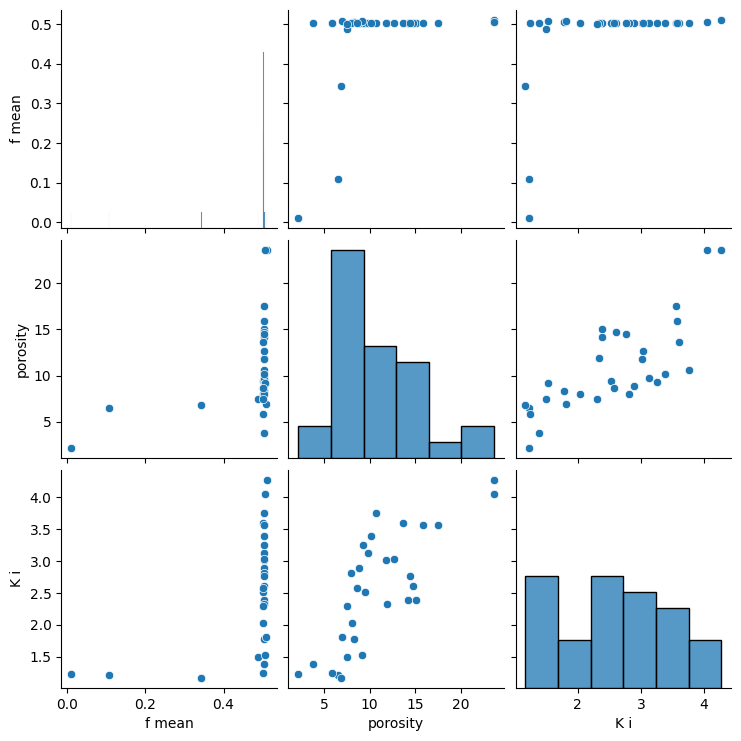

In [ ]:
import seaborn as sns
sns.pairplot(table)

### Input data

In [ ]:
path_to_ser = Path('/content/NewElasticity_v1/f model.xlsx')
df_ues_ar = pd.read_excel(path_to_ser, skiprows=0)

In [ ]:
df_ues_ar.columns

Index(['#', 'Sample', 'Well', 'Litholohy', 'Porosity,%', 'Permeability',
       'Density (air)', 'Density (water)', 'Density (oil)', 'Vp air', 'Vs air',
       'Vp oil', 'Vs oil', 'Vp water', 'Vs water', 'Unnamed: 15', 'AR thermal',
       'AO electrical', 'AR elastic', 'Unnamed: 19', 'TC air', 'TC oil',
       'TC 0,6', 'TC 6', 'TC 60', 'TC 180', 'Unnamed: 26', 'Скважина', 'R 0.6',
       'R 6', 'R 60', 'R 180', 'Unnamed: 32', 'Unnamed: 33', 'УЭС, Ом*м',
       'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Провод-ть, См/м',
       'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41'],
      dtype='object')

In [ ]:

df_ues_ar.dropna(subset=['Porosity,%'], inplace=True)

In [ ]:
idx = 30
porosity = df_ues_ar["Porosity,%"][idx]/100

In [ ]:
porosity

0.236485416123435

In [ ]:
df_ues_ar[['AR thermal', 'AO electrical', 'AR elastic']].iloc[idx]

AR thermal       0.131826
AO electrical    0.080662
AR elastic       0.110000
Name: 31, dtype: float64

In [ ]:
air_tc_exp = df_ues_ar["TC air"][idx]
water_tc_exp = df_ues_ar["TC 6"][idx]
oil_tc_exp = df_ues_ar["TC oil"][idx]

In [ ]:
exp_6 = 1/ df_ues_ar["R 6"][idx]
exp_60 = 1/ df_ues_ar["R 60"][idx]
exp_180 = 1/ df_ues_ar["R 180"][idx]

In [ ]:
Vp_exp_air, Vs_exp_air = df_ues_ar["Vp air"][idx], df_ues_ar["Vs air"][idx]
Vp_exp_water, Vs_exp_water = df_ues_ar["Vp water"][idx], df_ues_ar["Vs water"][idx]

density_air, density_water = df_ues_ar["Density (air)"][idx], df_ues_ar["Density (water)"][idx]
p_air, p_water = density_air, density_water

### Thermal conductivity

In [ ]:
# Matrix value is fixed
def table_calculation(fluid, lam_matrix):

    print(lam_matrix)

  # for fluid in fluid_list:

    data_fluid = []

    tc_eff_list, f_result, ar_result = [], [], []
    tc_mtrx = []

    globals()[f'result_{fluid}'] = pd.DataFrame()
    globals()[f'sorted_{fluid}'] = pd.DataFrame()

    lam_fluid = 0

    if fluid=='air':
      lam_fluid = 0.025
    elif fluid == 'water':
      lam_fluid = 0.60
    elif fluid == 'oil':
      lam_fluid = 0.12

    N, n = 2, 2 # Amount of nodes


    for ar_inclusion in np.logspace(-2, 0, N, base=10):

      for f in np.linspace(0, 1, n):

        conc = [1-porosity, porosity]
        alpha_shape = [1, ar_inclusion]
        lam = [lam_matrix, lam_fluid]
        print(lam)

        lam_eff = effective_tc_f(conc, alpha_shape, lam, f)

        tc_eff_list.append(lam_eff)
        f_result.append(f)
        ar_result.append(ar_inclusion)
        tc_mtrx.append(lam[0])

    globals()[f'result_{fluid}'][f'Porosity,%'] = [porosity]*len(tc_eff_list)
    globals()[f'result_{fluid}'][f'AR inclusion'] = ar_result
    globals()[f'result_{fluid}'][f'f'] = f_result
    globals()[f'result_{fluid}'][f'TCmtrx_{fluid}'] = tc_mtrx
    globals()[f'result_{fluid}'][f'TC_{fluid}'] = tc_eff_list


    globals()[f'result_{fluid}'][f'e_{fluid}'] = 3*globals()[f'result_{fluid}'][f'Porosity,%'] / (4 * pi * globals()[f'result_{fluid}'][f'AR inclusion'])

    globals()[f'result_{fluid}'][f'TC_exp_{fluid}'] = [globals()[f'{fluid}_tc_exp']]*len(tc_eff_list)

    globals()[f'result_{fluid}'][f'TC_HSup_{fluid}'] = Upper_Hashin_Strikman([1-globals()[f'result_{fluid}'][f'Porosity,%'], globals()[f'result_{fluid}'][f'Porosity,%']],
                                                                            [globals()[f"lam_mtrx_{fluid}"], lam_fluid])

    globals()[f'result_{fluid}'][f'TC_HSlo_{fluid}'] =  Lower_Hashin_Strikman([1-globals()[f'result_{fluid}'][f'Porosity,%'], globals()[f'result_{fluid}'][f'Porosity,%']],
                                                                            [globals()[f"lam_mtrx_{fluid}"], lam_fluid])



    # Calculate the difference and assign it directly to the new column 'Diff Vp air'
    TC_exp = globals()[f'result_{fluid}'][f'TC_exp_{fluid}']
    globals()[f'result_{fluid}'][f'Diff TC {fluid}'] = abs(np.round((globals()[f'result_{fluid}'][f'TC_{fluid}'] - TC_exp) / TC_exp * 100, 2))
    globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][globals()[f'result_{fluid}'][f'e_{fluid}']<=1] # Select only void density < 1

    globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][
    (globals()[f'result_{fluid}'][f'TC_{fluid}'] >= globals()[f'result_{fluid}'][f'TC_HSlo_{fluid}']) &
    (globals()[f'result_{fluid}'][f'TC_{fluid}'] <= globals()[f'result_{fluid}'][f'TC_HSup_{fluid}'])
]


    # globals()[f'sorted_{fluid}'] = globals()[f'result_{fluid}'][(globals()[f'result_{fluid}'][f'Diff TC {fluid}'].abs() > 5)].sort_values(by=[f'Diff TC {fluid}'], key=lambda x: x.abs())

    # return globals()[f'sorted_{fluid}'].shape[0]
    return globals()[f'result_{fluid}'].shape[0]

In [ ]:
# Matrix value changes within error
def table_calculation_matrix(fluid, lam_matrix_list):

  data_fluid = []

  tc_eff_list, f_result, ar_result = [], [], []
  tc_mtrx = []
  hs_up_list, hs_lo_list = [], []

  globals()[f'result_{fluid}'] = pd.DataFrame()
  globals()[f'sorted_{fluid}'] = pd.DataFrame()

  lam_fluid = 0

  if fluid=='air':
    lam_fluid = 0.025
  elif fluid == 'water':
    lam_fluid = 0.60
  elif fluid == 'oil':
    lam_fluid = 0.12


  N, n = 100, 20 # Amount of nodes

  for matrix_value in lam_matrix_list:
    for ar_inclusion in np.logspace(-2, 0, N, base=10):
      for f in np.linspace(0, 1, n):

        conc = [1-porosity, porosity]
        alpha_shape = [1, ar_inclusion]
        lam = [matrix_value, lam_fluid]

        lam_eff = effective_tc_f(conc, alpha_shape, lam, f)

        tc_eff_list.append(lam_eff)
        f_result.append(f)
        ar_result.append(ar_inclusion)
        tc_mtrx.append(matrix_value)

        hs_up_list.append(Upper_Hashin_Strikman(conc, lam))
        hs_lo_list.append(Lower_Hashin_Strikman(conc, lam))

  globals()[f'result_{fluid}'][f'Porosity,%'] = [porosity]*len(tc_eff_list)
  globals()[f'result_{fluid}'][f'AR inclusion'] = ar_result
  globals()[f'result_{fluid}'][f'f'] = f_result
  globals()[f'result_{fluid}'][f'TCmtrx_{fluid}'] = tc_mtrx
  globals()[f'result_{fluid}'][f'TC_{fluid}'] = tc_eff_list

  globals()[f'result_{fluid}'][f'TC_HSup_{fluid}'] = hs_up_list
  globals()[f'result_{fluid}'][f'TC_HSlo_{fluid}'] = hs_lo_list


  globals()[f'result_{fluid}'][f'e_{fluid}'] = 3*globals()[f'result_{fluid}'][f'Porosity,%'] / (4 * pi * globals()[f'result_{fluid}'][f'AR inclusion'])

  globals()[f'result_{fluid}'][f'TC_exp_{fluid}'] = [globals()[f'{fluid}_tc_exp']]*len(tc_eff_list)

  # globals()[f'result_{fluid}'][f'TC_HSup_{fluid}'] = Upper_Hashin_Strikman([1-globals()[f'result_{fluid}'][f'Porosity,%'], globals()[f'result_{fluid}'][f'Porosity,%']],
  #                                                                         [globals()[f"lam_mtrx_{fluid}"], lam_fluid])

  # globals()[f'result_{fluid}'][f'TC_HSlo_{fluid}'] =  Lower_Hashin_Strikman([1-globals()[f'result_{fluid}'][f'Porosity,%'], globals()[f'result_{fluid}'][f'Porosity,%']],
  #                                                                         [globals()[f"lam_mtrx_{fluid}"], lam_fluid])

  # Calculate the difference and assign it directly to the new column 'Diff Vp air'
  TC_exp = globals()[f'result_{fluid}'][f'TC_exp_{fluid}']
  globals()[f'result_{fluid}'][f'Diff TC {fluid}'] = abs(np.round((globals()[f'result_{fluid}'][f'TC_{fluid}'] - TC_exp) / TC_exp * 100, 2))
  globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][globals()[f'result_{fluid}'][f'e_{fluid}']<=1] # Select only void density < 1

  globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][
  (globals()[f'result_{fluid}'][f'TC_{fluid}'] >= globals()[f'result_{fluid}'][f'TC_HSlo_{fluid}']) &
  (globals()[f'result_{fluid}'][f'TC_{fluid}'] <= globals()[f'result_{fluid}'][f'TC_HSup_{fluid}'])
]


  # globals()[f'sorted_{fluid}'] = globals()[f'result_{fluid}'][(globals()[f'result_{fluid}'][f'Diff TC {fluid}'].abs() > 5)].sort_values(by=[f'Diff TC {fluid}'], key=lambda x: x.abs())

  return globals()[f'result_{fluid}']

In [ ]:
fluid_list = ['air', 'water', 'oil']
# fluid_list = ['water']

lam_air, lam_water, lam_oil = 0.025, 0.6, 0.12
lam_mtrx_air, lam_mtrx_water, lam_mtrx_oil = 2.95, 2.95, 2.95

error_air, error_water, error_oil = 0.05, 0.05, 0.05 # Error for K, mu minreal matrix
N = 5

for fluid in fluid_list:

  # print(fluid, globals()[f"lam_mtrx_{fluid}"], globals()[f"lam_{fluid}"])

  globals()[f"lam_mtrx_{fluid}_list"] = np.linspace(globals()[f"lam_mtrx_{fluid}"] - globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                  globals()[f"lam_mtrx_{fluid}"] + globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                  N)


  # for lam_matrix in globals()[f"lam_mtrx_{fluid}_list"] :

  number = table_calculation_matrix(fluid, globals()[f"lam_mtrx_{fluid}_list"])

    # print(globals()[f"error_{fluid}"], lam_matrix)

  # print('\n\n')

In [ ]:
result_water

Porosity,%  AR inclusion         f  TCmtrx_water  TC_water  \
560     0.150243      0.036784  0.000000        2.8025  2.232218   
561     0.150243      0.036784  0.052632        2.8025  2.235394   
562     0.150243      0.036784  0.105263        2.8025  2.238491   
563     0.150243      0.036784  0.157895        2.8025  2.241485   
564     0.150243      0.036784  0.210526        2.8025  2.244346   
...          ...           ...       ...           ...       ...   
9995    0.150243      1.000000  0.789474        3.0975  2.475479   
9996    0.150243      1.000000  0.842105        3.0975  2.453589   
9997    0.150243      1.000000  0.894737        3.0975  2.427438   
9998    0.150243      1.000000  0.947368        3.0975  2.395648   
9999    0.150243      1.000000  1.000000        3.0975  2.356173   

      TC_HSup_water  TC_HSlo_water   e_water  TC_exp_water  Diff TC water  
560        2.376832       2.180950  0.975099      2.514712          11.23  
561        2.376832       2.180950  0.975099      2.514712          11.11  
562        2.376832       2.180950  0.975099      2.514712          10.98  
563        2.376832       2.180950  0.975099      2.514712          10.87  
564        2.376832       2.180950  0.975099      2.514712          10.75  
...             ...            ...       ...           ...            ...  
9995       2.611206       2.356173  0.035868      2.514712           1.56  
9996       2.611206       2.356173  0.035868      2.514712           2.43  
9997       2.611206       2.356173  0.035868      2.514712           3.47  
9998       2.611206       2.356173  0.035868      2.514712           4.73  
9999       2.611206       2.356173  0.035868      2.514712           6.30  

[7200 rows x 10 columns]

In [ ]:
tc_oil = result_oil
tc_water = result_water
tc_air = result_air

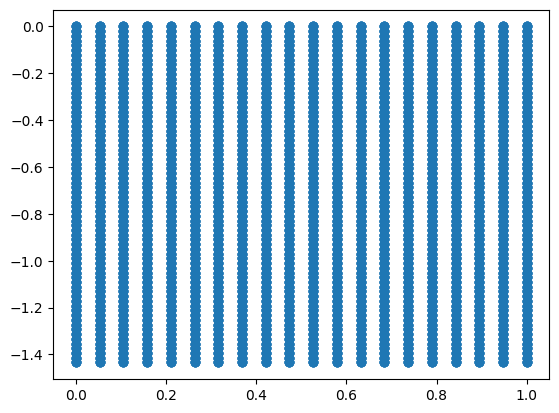

In [ ]:
plt.scatter(result_water["f"], np.log10(result_water["AR inclusion"]))

In [ ]:
result_water[:20]

Porosity,%  AR inclusion         f  TCmtrx_water  TC_water  \
560    0.150243      0.036784  0.000000        2.8025  2.232218   
561    0.150243      0.036784  0.052632        2.8025  2.235394   
562    0.150243      0.036784  0.105263        2.8025  2.238491   
563    0.150243      0.036784  0.157895        2.8025  2.241485   
564    0.150243      0.036784  0.210526        2.8025  2.244346   
565    0.150243      0.036784  0.263158        2.8025  2.247037   
566    0.150243      0.036784  0.315789        2.8025  2.249514   
567    0.150243      0.036784  0.368421        2.8025  2.251719   
568    0.150243      0.036784  0.421053        2.8025  2.253582   
569    0.150243      0.036784  0.473684        2.8025  2.255012   
570    0.150243      0.036784  0.526316        2.8025  2.255896   
571    0.150243      0.036784  0.578947        2.8025  2.256083   
572    0.150243      0.036784  0.631579        2.8025  2.255377   
573    0.150243      0.036784  0.684211        2.8025  2.253514   
574    0.150243      0.036784  0.736842        2.8025  2.250133   
575    0.150243      0.036784  0.789474        2.8025  2.244727   
576    0.150243      0.036784  0.842105        2.8025  2.236563   
577    0.150243      0.036784  0.894737        2.8025  2.224544   
578    0.150243      0.036784  0.947368        2.8025  2.206954   
579    0.150243      0.036784  1.000000        2.8025  2.180950   

     TC_HSup_water  TC_HSlo_water   e_water  TC_exp_water  Diff TC water  
560       2.376832        2.18095  0.975099      2.514712          11.23  
561       2.376832        2.18095  0.975099      2.514712          11.11  
562       2.376832        2.18095  0.975099      2.514712          10.98  
563       2.376832        2.18095  0.975099      2.514712          10.87  
564       2.376832        2.18095  0.975099      2.514712          10.75  
565       2.376832        2.18095  0.975099      2.514712          10.64  
566       2.376832        2.18095  0.975099      2.514712          10.55  
567       2.376832        2.18095  0.975099      2.514712          10.46  
568       2.376832        2.18095  0.975099      2.514712          10.38  
569       2.376832        2.18095  0.975099      2.514712          10.33  
570       2.376832        2.18095  0.975099      2.514712          10.29  
571       2.376832        2.18095  0.975099      2.514712          10.28  
572       2.376832        2.18095  0.975099      2.514712          10.31  
573       2.376832        2.18095  0.975099      2.514712          10.39  
574       2.376832        2.18095  0.975099      2.514712          10.52  
575       2.376832        2.18095  0.975099      2.514712          10.74  
576       2.376832        2.18095  0.975099      2.514712          11.06  
577       2.376832        2.18095  0.975099      2.514712          11.54  
578       2.376832        2.18095  0.975099      2.514712          12.24  
579       2.376832        2.18095  0.975099      2.514712          13.27

(0.0, 10.0)

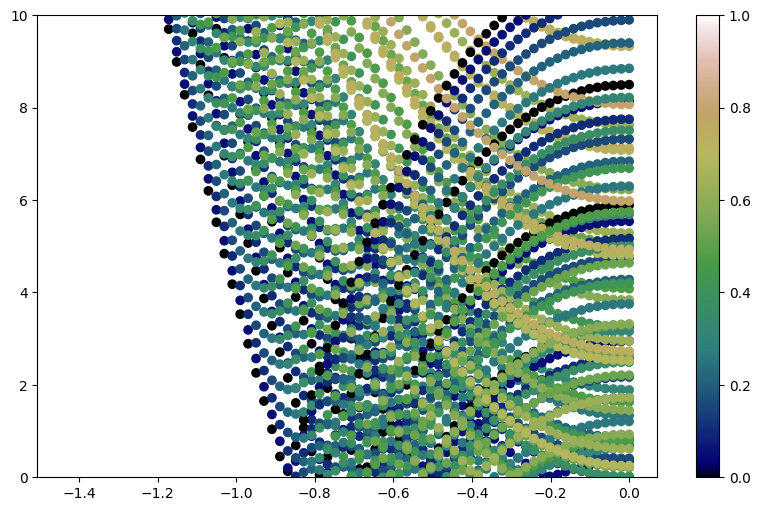

In [ ]:
plt.figure(figsize=(10, 6))

# scatter_1 = plt.scatter(np.log10(result_air['AR inclusion']),result_air['Diff TC air'],
#                       c=result_air['f'], cmap='jet', marker='o')

# scatter_2 = plt.scatter(np.log10(result_water['AR inclusion']),result_water['Diff TC water'],
#                       c=result_water['f'], cmap='seismic', marker='o')

scatter_3 = plt.scatter(np.log10(result_oil['AR inclusion']),result_oil['Diff TC oil'],
                      c=result_oil['f'], cmap='gist_earth', marker='o')

plt.colorbar(scatter_1)
plt.colorbar(scatter_2)
plt.colorbar(scatter_3)

plt.ylim(0, 10)

In [ ]:
def error_selection(table):
  error = 5
  globals()[f"selected_row_{fluid}"] = table[(abs(table[f'Diff TC {global}']) <= error)]

SyntaxError: f-string: invalid syntax (<ipython-input-3-60066dcbb09a>, line 3)

### Расчет одновременно для всей коллекции

In [ ]:
# # Merge all states function
# def merge_table(selected_row_air, selected_row_water, selected_row_oil, idx):
#   globals()[f"merged_data_{idx}"] = pd.merge(selected_row_air, selected_row_water,
#                   on=["AR inclusion", "f"], suffixes=('_air', '_water'), how='inner')

#   globals()[f"merged_data_{idx}"] = pd.merge(globals()[f"merged_data_{idx}"], selected_row_oil,
#                       on=["AR inclusion", "f"], suffixes=('_merged', '_oil'), how='inner')

#   globals()[f"merged_data_{idx}"]['total diff'] = np.sqrt(globals()[f"merged_data_{idx}"]["Diff TC air"]**2 + \
#                                   globals()[f"merged_data_{idx}"]["Diff TC water"]**2 +\
#                                   globals()[f"merged_data_{idx}"]["Diff TC oil"]**2 )

#   print('merge shape func', globals()[f"merged_data_{idx}"].shape[0])
#   return globals()[f"merged_data_{idx}"]


# Merge all states function
def merge_table(selected_row_air, selected_row_water, selected_row_oil):

  merged_data = pd.DataFrame()

  merged_data = pd.merge(selected_row_air, selected_row_water,
                  on=["AR inclusion", "f"], suffixes=('_air', '_water'), how='inner')

  merged_data = pd.merge(merged_data, selected_row_oil,
                      on=["AR inclusion", "f"], suffixes=('_merged', '_oil'), how='inner')

  merged_data['total diff'] = np.sqrt(merged_data["Diff TC air"]**2 + \
                                   merged_data["Diff TC water"]**2 +\
                                   merged_data["Diff TC oil"]**2 )
  return merged_data

0
0.045249 2.4728875 2.740225 2.66888457425328
[2.8025  2.87625 2.95    3.02375 3.0975 ]
[2.8025  2.87625 2.95    3.02375 3.0975 ]
[2.8025  2.87625 2.95    3.02375 3.0975 ]
1
0.0647337128595146 2.404575 2.741125 2.60088763678152
[2.8025  2.87625 2.95    3.02375 3.0975 ]
[2.8025  2.87625 2.95    3.02375 3.0975 ]
[2.8025  2.87625 2.95    3.02375 3.0975 ]


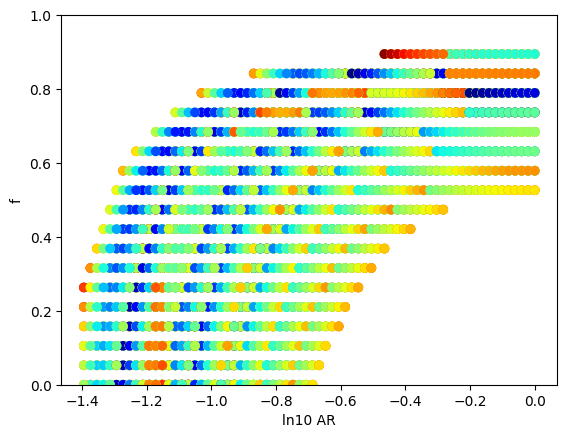

In [ ]:
# for number in range(0, len(df_ues_ar["#"])):
for number in df_ues_ar.index.tolist()[0:2]:

  fluid_list_full = ['air', 'water', 'oil']

  idx = number

  print(idx)
  porosity = df_ues_ar["Porosity,%"][idx]

  if np.isnan(porosity):
    pass

  else:
    porosity /= 100
    # Experemental values
    air_tc_exp = df_ues_ar["TC air"][idx]
    water_tc_exp = df_ues_ar["TC 6"][idx]
    oil_tc_exp = df_ues_ar["TC oil"][idx]

    print(porosity, air_tc_exp, water_tc_exp, oil_tc_exp)

    lam_air, lam_water, lam_oil = 0.025, 0.6, 0.12
    lam_mtrx_air, lam_mtrx_water, lam_mtrx_oil = 2.95, 2.95, 2.95

    # Error in mineral matrix values
    error_air, error_water, error_oil = 0.05, 0.05, 0.05 # Error for K, mu minreal matrix
    N = 5

    # Цикл - если в обобщенной таблице для нескольких состояний, число строк равно нулю,
    # то проводиться новый расчет с ошибкой увеличенной на 2,5%
    globals()[f"merged_data_{idx}"] = pd.DataFrame()
    error = 2.5

    while globals()[f"merged_data_{idx}"].shape[0] == 0:
      # print("error: ", error, globals()[f"merged_data_{idx}"].shape[0])

      globals()[f"selected_row_{fluid}"] = pd.DataFrame()

      for fluid in fluid_list_full:
        globals()[f"lam_mtrx_{fluid}_list"] = np.linspace(globals()[f"lam_mtrx_{fluid}"] - globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                    globals()[f"lam_mtrx_{fluid}"] + globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                    N)
        print(globals()[f"lam_mtrx_{fluid}_list"])
        globals()[f'result_{fluid}'] = table_calculation_matrix(fluid, globals()[f"lam_mtrx_{fluid}_list"])
        globals()[f"selected_row_{fluid}"] = globals()[f'result_{fluid}'][(abs(globals()[f'result_{fluid}'][f'Diff TC {fluid}']) <= error)]

      globals()[f"merged_data_{idx}"] = merge_table(selected_row_air, selected_row_water, selected_row_oil)
      error +=2.5


    # Pd DataFrame for each sample
    globals()[f"sample_{idx}"] = pd.DataFrame()
    globals()[f"sample_{idx}"] = globals()[f"merged_data_{idx}"]
    globals()[f"sample_{idx}"].to_csv(f'/content/Sample_{idx}.csv', index=True)

    # Plot data
    data = globals()[f"sample_{idx}"]
    scatter = plt.scatter(np.log10(data["AR inclusion"]), data["f"],
                          c=data["total diff"], cmap='jet', marker='o')

    # plt.colorbar(scatter)

    plt.xlabel('ln10 AR')
    plt.ylabel('f')
    plt.ylim(0, 1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

FileNotFoundError: Sample_8.csv not found. Skipping to the next index.


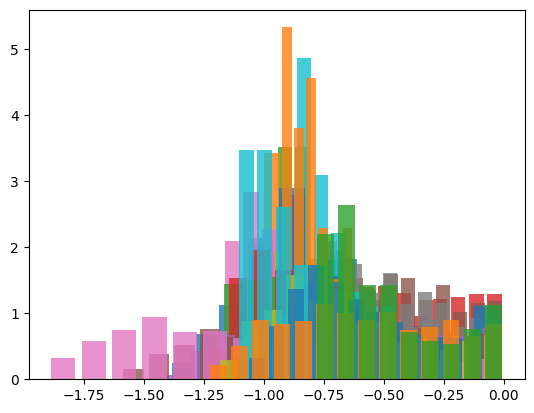

In [ ]:
for idx in range(0, len(df_ues_ar["#"])):
    try:
        path_to_ser = Path(f'/content/Sample_{idx}.csv')
        globals()[f"Sample_{idx}"] = pd.read_csv(path_to_ser, skiprows=0)

    except FileNotFoundError:
        print(f"FileNotFoundError: Sample_{idx}.csv not found. Skipping to the next index.")
        continue  # Skip to the next index

    data = globals()[f"Sample_{idx}"]

    log_data = np.log10(data["AR inclusion"])
    normalized_data = MinMaxScaler().fit_transform(np.array(log_data).reshape(-1, 1))

    plt.hist(log_data, bins="sturges", density=True, histtype='barstacked', rwidth=0.8, alpha=0.8)

    # # Create a mask by porosity
    # mask = None

    # if data['Porosity,%_air'].iloc[0] < 0.05:
    #     mask = data['Porosity,%_air'] < 0.05
    #     plt.hist(log_data[mask], bins="sturges", density=True, histtype='barstacked', rwidth=0.8, alpha=0.8, color='black')
    # elif (data['Porosity,%_air'].iloc[0] > 0.05) & (data['Porosity,%_air'].iloc[0] < 0.1):
    #     mask = (data['Porosity,%_air'].iloc[0] > 0.05) & (data['Porosity,%_air'].iloc[0] < 0.1)
    #     plt.hist(log_data[mask], bins="sturges", density=True, histtype='barstacked', rwidth=0.8, alpha=0.8, color='red')
    # else:
    #     mask = ~(data['Porosity,%_air'].iloc[0] < 0.05) & ~((data['Porosity,%_air'].iloc[0] > 0.05) & (data['Porosity,%_air'].iloc[0] < 0.1))
    #     plt.hist(log_data[mask], bins="sturges", density=True, histtype='barstacked', rwidth=0.8, alpha=0.8, color='blue')

plt.show()

In [ ]:
sample_2["TCmtrx_air"].min().max()

2.95

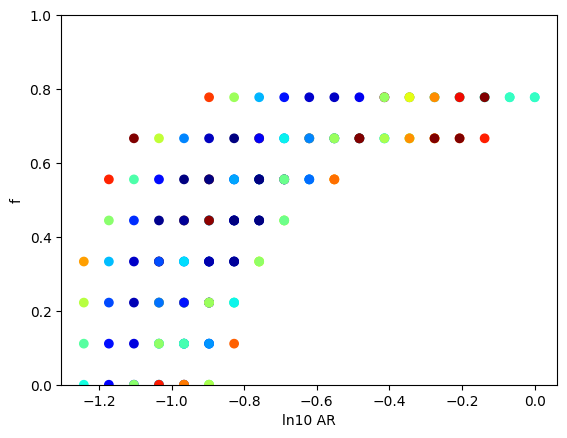

In [ ]:
for number in df_ues_ar.index.tolist()[0:10]:
  idx = number
# for number in range(0, len(df_ues_ar["#"])):

  globals()[f"sample_{idx}"] = pd.DataFrame()
  globals()[f"sample_{idx}"] = globals()[f"merged_data_{idx}"]

  # Plot the new data
  data = globals()[f"sample_{idx}"]
  scatter = plt.scatter(np.log10(data["AR inclusion"]), data["f"],
                        c=data["total diff"], cmap='jet', marker='o')

  plt.xlabel('ln10 AR')
  plt.ylabel('f')
  plt.ylim(0, 1)

(0.0, 1.0)

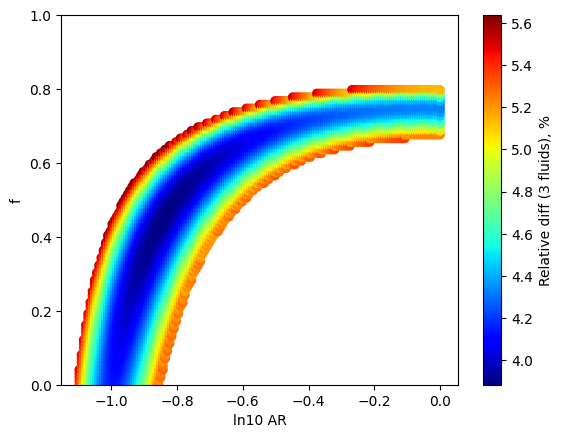

In [ ]:
data = sample_1

scatter = plt.scatter(np.log10(data["AR inclusion"]), data["f"],
                      c=data["total diff"], cmap='jet', marker='o')

colorbar = plt.colorbar(scatter)
colorbar.set_label('Relative diff (3 fluids), %')

plt.xlabel('ln10 AR')
plt.ylabel('f')

plt.ylim(0, 1)

In [ ]:
result_water

NameError: name 'result_water' is not defined

In [ ]:
error = 7

In [ ]:
selected_row_air = result_air[(abs(result_air['Diff TC air']) <= error)]
selected_row_air[:5]

Porosity,%  AR inclusion         f  TCmtrx_air    TC_air     e_air  TC_exp_air  \
11300    0.236485      0.056997  0.000000        2.95  1.271097  0.990519      1.2605   
11301    0.236485      0.056997  0.010101        2.95  1.269207  0.990519      1.2605   
11302    0.236485      0.056997  0.020202        2.95  1.267287  0.990519      1.2605   
11303    0.236485      0.056997  0.030303        2.95  1.265337  0.990519      1.2605   
11304    0.236485      0.056997  0.040404        2.95  1.263355  0.990519      1.2605   

       TC_HSup_air  TC_HSlo_air  Diff TC air  
11300      2.02481     0.243458         0.84  
11301      2.02481     0.243458         0.69  
11302      2.02481     0.243458         0.54  
11303      2.02481     0.243458         0.38  
11304      2.02481     0.243458         0.23

In [ ]:
selected_row_water = result_water[result_water['Diff TC water'] <= error]
selected_row_water[:5]

Porosity,%  AR inclusion         f  TCmtrx_water  TC_water   e_water  TC_exp_water  \
11300    0.236485      0.056997  0.000000          2.95  2.072275  0.990519      2.227387   
11301    0.236485      0.056997  0.010101          2.95  2.072774  0.990519      2.227387   
11302    0.236485      0.056997  0.020202          2.95  2.073270  0.990519      2.227387   
11303    0.236485      0.056997  0.030303          2.95  2.073763  0.990519      2.227387   
11304    0.236485      0.056997  0.040404          2.95  2.074253  0.990519      2.227387   

       TC_HSup_water  TC_HSlo_water  Diff TC water  
11300       2.252936       1.970977           6.96  
11301       2.252936       1.970977           6.94  
11302       2.252936       1.970977           6.92  
11303       2.252936       1.970977           6.90  
11304       2.252936       1.970977           6.88

In [ ]:
selected_row_oil = result_oil[result_oil['Diff TC oil'] <= error]
selected_row_oil[:5]

Porosity,%  AR inclusion         f  TCmtrx_oil    TC_oil     e_oil  TC_exp_oil  \
12500    0.236485      0.068568  0.000000        2.95  1.550851  0.823371    1.662913   
12501    0.236485      0.068568  0.010101        2.95  1.550004  0.823371    1.662913   
12502    0.236485      0.068568  0.020202        2.95  1.549143  0.823371    1.662913   
12503    0.236485      0.068568  0.030303        2.95  1.548267  0.823371    1.662913   
12504    0.236485      0.068568  0.040404        2.95  1.547378  0.823371    1.662913   

       TC_HSup_oil  TC_HSlo_oil  Diff TC oil  
12500     2.064566      0.87576         6.74  
12501     2.064566      0.87576         6.79  
12502     2.064566      0.87576         6.84  
12503     2.064566      0.87576         6.89  
12504     2.064566      0.87576         6.95

In [ ]:
# Merge selected_row_air and selected_row_water first
merged_data_tc = pd.merge(selected_row_air,
                       selected_row_water,
                       on=["AR inclusion", "f"], suffixes=('_air', '_water'), how='inner')

# Then merge the result with selected_row_oil
merged_data_tc = pd.merge(merged_data_tc,
                       selected_row_oil,
                       on=["AR inclusion", "f"], suffixes=('_merged', '_oil'), how='inner')

merged_data_tc['total diff'] = np.sqrt(merged_data_tc["Diff TC air"]**2 + \
                                    merged_data_tc["Diff TC water"]**2 +\
                                    merged_data_tc["Diff TC oil"]**2 )

In [ ]:
merged_data_tc[:5]

Porosity,%_air  AR inclusion         f  TCmtrx_air    TC_air     e_air  TC_exp_air  \
0        0.236485      0.070713  0.141414        2.95  1.346955  0.798394      1.2605   
1        0.236485      0.070713  0.151515        2.95  1.344377  0.798394      1.2605   
2        0.236485      0.071810  0.171717        2.95  1.346485  0.786192      1.2605   
3        0.236485      0.071810  0.181818        2.95  1.343748  0.786192      1.2605   
4        0.236485      0.071810  0.191919        2.95  1.340959  0.786192      1.2605   

   TC_HSup_air  TC_HSlo_air  Diff TC air  Porosity,%_water  TCmtrx_water  TC_water   e_water  \
0      2.02481     0.243458         6.86          0.236485          2.95  2.093259  0.798394   
1      2.02481     0.243458         6.65          0.236485          2.95  2.093513  0.798394   
2      2.02481     0.243458         6.82          0.236485          2.95  2.095036  0.786192   
3      2.02481     0.243458         6.60          0.236485          2.95  2.095255  0.786192   
4      2.02481     0.243458         6.38          0.236485          2.95  2.095467  0.786192   

   TC_exp_water  TC_HSup_water  TC_HSlo_water  Diff TC water  Porosity,%  TCmtrx_oil    TC_oil  \
0      2.227387       2.252936       1.970977           6.02    0.236485        2.95  1.547668   
1      2.227387       2.252936       1.970977           6.01    0.236485        2.95  1.546541   
2      2.227387       2.252936       1.970977           5.94    0.236485        2.95  1.549195   
3      2.227387       2.252936       1.970977           5.93    0.236485        2.95  1.547978   
4      2.227387       2.252936       1.970977           5.92    0.236485        2.95  1.546738   

      e_oil  TC_exp_oil  TC_HSup_oil  TC_HSlo_oil  Diff TC oil  total diff  
0  0.798394    1.662913     2.064566      0.87576         6.93   11.459708  
1  0.798394    1.662913     2.064566      0.87576         7.00   11.372889  
2  0.786192    1.662913     2.064566      0.87576         6.84   11.339383  
3  0.786192    1.662913     2.064566      0.87576         6.91   11.246022  
4  0.786192    1.662913     2.064566      0.87576         6.99   11.162925

In [ ]:
merged_data_tc["AR inclusion"].min(), merged_data_tc["AR inclusion"].max()

(0.07071284778942996, 0.28720631177978284)

In [ ]:
merged_data_tc.to_csv('/content/tc_5.csv', index=True)

(0.0, 1.0)

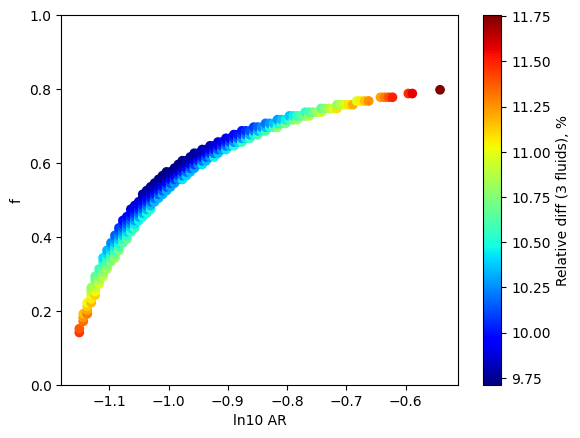

In [ ]:
scatter = plt.scatter(np.log10(merged_data_tc["AR inclusion"]),  merged_data_tc["f"],
                      c=merged_data_tc["total diff"], cmap='jet', marker='o')

colorbar = plt.colorbar(scatter)
colorbar.set_label('Relative diff (3 fluids), %')

plt.xlabel('ln10 AR')
plt.ylabel('f')

plt.ylim(0, 1)

(array([0.54285714, 0.95      , 0.9       , 1.22857143, 1.04285714,
        1.34285714, 1.14285714, 0.77142857, 0.83571429, 0.60714286,
        0.72142857, 0.71428571]),
 array([-1.11111111, -1.01851852, -0.92592593, -0.83333333, -0.74074074,
        -0.64814815, -0.55555556, -0.46296296, -0.37037037, -0.27777778,
        -0.18518519, -0.09259259,  0.        ]),
 <BarContainer object of 12 artists>)

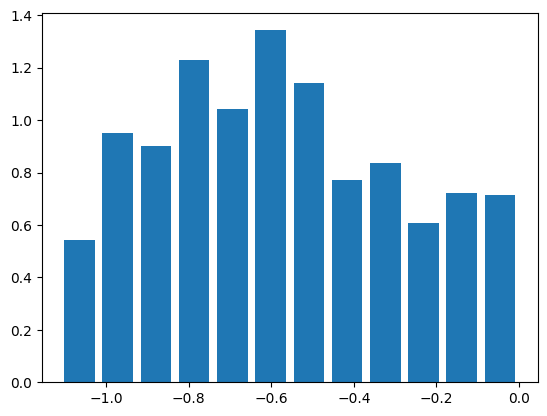

In [ ]:
plt.hist(np.log10(merged_data_tc["AR inclusion"]), bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8)

(array([1.08888889, 0.86527778, 0.88472222, 1.28333333, 1.04027778,
        1.16666667, 1.95416667, 1.43888889, 1.37083333, 1.68194444,
        1.08888889, 0.83611111]),
 array([0.        , 0.06802721, 0.13605442, 0.20408163, 0.27210884,
        0.34013605, 0.40816327, 0.47619048, 0.54421769, 0.6122449 ,
        0.68027211, 0.74829932, 0.81632653]),
 <BarContainer object of 12 artists>)

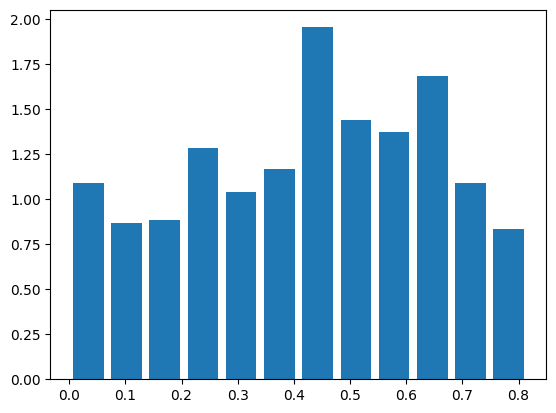

In [ ]:
plt.hist(merged_data_tc["f"], bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8)

In [ ]:
first[0:4]

Unnamed: 0  Porosity,%_air  AR inclusion         f  TCmtrx_air    TC_air     e_air  TC_exp_air  \
0           0        0.014711      0.026388  0.535354        2.95  2.605928  0.133096    2.659425   
1           1        0.014711      0.026388  0.545455        2.95  2.604311  0.133096    2.659425   
2           2        0.014711      0.026388  0.555556        2.95  2.602641  0.133096    2.659425   
3           3        0.014711      0.026388  0.565657        2.95  2.600916  0.133096    2.659425   

   TC_HSup_air  TC_HSlo_air  Diff TC air  Porosity,%_water  TCmtrx_water  TC_water   e_water  \
0     2.886189     1.856277         2.01          0.014711          2.95  2.883979  0.133096   
1     2.886189     1.856277         2.07          0.014711          2.95  2.884015  0.133096   
2     2.886189     1.856277         2.14          0.014711          2.95  2.884046  0.133096   
3     2.886189     1.856277         2.20          0.014711          2.95  2.884073  0.133096   

   TC_exp_water  TC_HSup_water  TC_HSlo_water  Diff TC water  Porosity,%  TCmtrx_oil    TC_oil  \
0      2.907188       2.903178       2.871794            0.8    0.014711        2.95  2.765829   
1      2.907188       2.903178       2.871794            0.8    0.014711        2.95  2.765925   
2      2.907188       2.903178       2.871794            0.8    0.014711        2.95  2.766012   
3      2.907188       2.903178       2.871794            0.8    0.014711        2.95  2.766089   

      e_oil  TC_exp_oil  TC_HSup_oil  TC_HSlo_oil  Diff TC oil  total diff  
0  0.133096     2.83689     2.889215     2.619323          2.5    3.306070  
1  0.133096     2.83689     2.889215     2.619323          2.5    3.342888  
2  0.133096     2.83689     2.889215     2.619323          2.5    3.386680  
3  0.133096     2.83689     2.889215     2.619323          2.5    3.424909

### Electrical conductivity

In [ ]:
def table_calculation(fluid, lam_matrix):

    data_fluid = []

    tc_eff_list, f_result, ar_result = [], [], []

    globals()[f'result_{fluid}'] = pd.DataFrame()
    globals()[f'sorted_{fluid}'] = pd.DataFrame()

    lam_fluid = 0

    if fluid=='6':
      lam_fluid = 1.060
    elif fluid == '60':
      lam_fluid = 8.42
    elif fluid == '180':
      lam_fluid = 18.87

    N, n = 300, 100 # Amount of nodes

    for ar_inclusion in np.logspace(-2, 0, N):

      for f in np.linspace(0, 1, n):

        conc = [1-porosity, porosity]
        alpha_shape = [1, ar_inclusion]
        lam = [globals()[f"lam_mtrx_{fluid}"], lam_fluid]

        lam_eff = effective_tc_f(conc, alpha_shape, lam, f)

        tc_eff_list.append(1/lam_eff)
        f_result.append(f)
        ar_result.append(ar_inclusion)

    globals()[f'result_{fluid}'][f'Porosity,%'] = [porosity]*len(tc_eff_list)
    globals()[f'result_{fluid}'][f'AR inclusion'] = ar_result
    globals()[f'result_{fluid}'][f'f'] = f_result
    globals()[f'result_{fluid}'][f'TC_{fluid}'] = (tc_eff_list)

    globals()[f'result_{fluid}'][f'TC_exp_{fluid}'] = [1/(globals()[f'exp_{fluid}'])]*len(tc_eff_list)

    globals()[f'result_{fluid}'][f'e_{fluid}'] = 3*globals()[f'result_{fluid}'][f'Porosity,%'] / (4 * pi * globals()[f'result_{fluid}'][f'AR inclusion'])

    # Calculate the difference and assign it directly to the new column 'Diff Vp air'
    TC_exp = globals()[f'result_{fluid}'][f'TC_exp_{fluid}']
    # globals()[f'result_{fluid}'][f'Diff TC {fluid}'] = np.log10(abs((globals()[f'result_{fluid}'][f'TC_{fluid}'] - TC_exp)))

    globals()[f'result_{fluid}'][f'Diff TC {fluid}'] = abs(np.round((np.log10(globals()[f'result_{fluid}'][f'TC_{fluid}']) - \
                                                                     np.log10(TC_exp)) / np.log10(TC_exp) * 100, 2))
    globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][globals()[f'result_{fluid}'][f'e_{fluid}']<=1] # Select only void density < 1

    # globals()[f'sorted_{fluid}'] = globals()[f'result_{fluid}'][(globals()[f'result_{fluid}'][f'Diff TC {fluid}'].abs() > 5)].sort_values(by=[f'Diff TC {fluid}'], key=lambda x: x.abs())

    # return globals()[f'sorted_{fluid}'].shape[0]
    return globals()[f'result_{fluid}'].shape[0]

In [ ]:
fluid_list = ['6', '60', '180']

lam_6, lam_60, lam_180 = 1.060, 8.42, 18.87
lam_mtrx_6, lam_mtrx_60, lam_mtrx_180 = 1.82*10**-3, 1.43*10**-2, 4.00*10**-2

error_6, error_60, error_180 = 0.05, 0.05, 0.05 # Error for K, mu minreal matrix
N = 5

for fluid in fluid_list:

  # print(fluid, globals()[f"lam_mtrx_{fluid}"], globals()[f"lam_{fluid}"])

  globals()[f"lam_mtrx_{fluid}_list"] = np.linspace(globals()[f"lam_mtrx_{fluid}"] - globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                  globals()[f"lam_mtrx_{fluid}"] + globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                  N)

  for lam_matrix in globals()[f"lam_mtrx_{fluid}_list"] :

    number = table_calculation(fluid, lam_matrix)

    # print(globals()[f"error_{fluid}"], lam_matrix)

  # print('\n\n')

In [ ]:
electric_180 = result_180
electric_60 = result_60
electric_6 = result_6

In [ ]:
electric_60[:5]

Porosity,%  AR inclusion         f      TC_60  TC_exp_60      e_60  \
2900    0.064734      0.015631  0.000000  16.027634  25.352935  0.988694   
2901    0.064734      0.015631  0.010101   6.594615  25.352935  0.988694   
2902    0.064734      0.015631  0.020202   5.312448  25.352935  0.988694   
2903    0.064734      0.015631  0.030303   4.794853  25.352935  0.988694   
2904    0.064734      0.015631  0.040404   4.509818  25.352935  0.988694   

      Diff TC 60  
2900       14.18  
2901       41.65  
2902       48.34  
2903       51.51  
2904       53.41

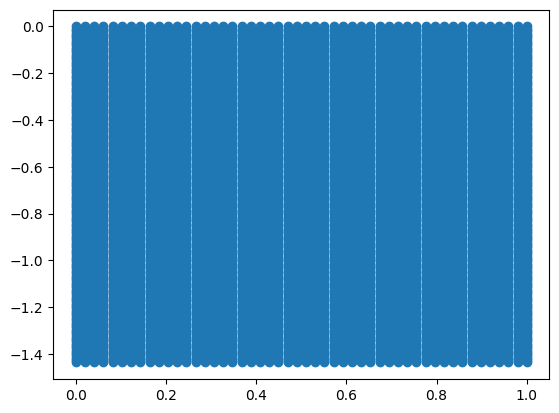

In [ ]:
plt.scatter(result_6["f"], np.log10(result_6["AR inclusion"]))

In [ ]:
result_60[:10]

Porosity,%  AR inclusion         f      TC_60  TC_exp_60      e_60  Diff TC 60
2900    0.158852      0.038275  0.000000  13.490877     3.8954  0.990806      246.33
2901    0.158852      0.038275  0.020408   3.002213     3.8954  0.990806       22.93
2902    0.158852      0.038275  0.040816   2.250574     3.8954  0.990806       42.22
2903    0.158852      0.038275  0.061224   1.968082     3.8954  0.990806       49.48
2904    0.158852      0.038275  0.081633   1.815933     3.8954  0.990806       53.38
2905    0.158852      0.038275  0.102041   1.718374     3.8954  0.990806       55.89
2906    0.158852      0.038275  0.122449   1.648903     3.8954  0.990806       57.67
2907    0.158852      0.038275  0.142857   1.595836     3.8954  0.990806       59.03
2908    0.158852      0.038275  0.163265   1.553219     3.8954  0.990806       60.13
2909    0.158852      0.038275  0.183673   1.517698     3.8954  0.990806       61.04

(0.0, 10.0)

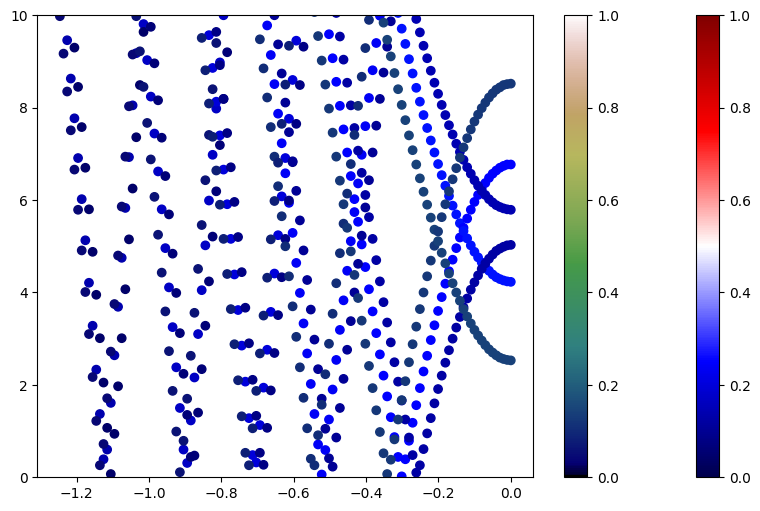

In [ ]:
plt.figure(figsize=(10, 6))

scatter1 = plt.scatter(np.log10(result_60['AR inclusion']),result_60['Diff TC 60'],
                      c=result_60['f'], cmap='jet', marker='o')

scatter_2 = plt.scatter(np.log10(result_6['AR inclusion']),result_6['Diff TC 6'],
                      c=result_6['f'], cmap='seismic', marker='o')

scatter_3 = plt.scatter(np.log10(result_180['AR inclusion']),result_180['Diff TC 180'],
                      c=result_180['f'], cmap='gist_earth', marker='o')

plt.colorbar(scatter_1)
plt.colorbar(scatter_2)
plt.colorbar(scatter_3)

plt.ylim(0, 10)


In [ ]:
error = 5

In [ ]:
selected_row_6 = result_6[(abs(result_6['Diff TC 6']) <= error)]
selected_row_6[:5]

Porosity,%  AR inclusion         f       TC_6   TC_exp_6       e_6  Diff TC 6
4202    0.236485      0.069859  0.040816  14.249093  14.980838  0.808155       4.88
4252    0.236485      0.071494  0.040816  14.388428  14.980838  0.789668       3.95
4302    0.236485      0.073168  0.040816  14.530163  14.980838  0.771603       3.01
4352    0.236485      0.074881  0.040816  14.674317  14.980838  0.753952       2.05
4402    0.236485      0.076634  0.040816  14.820913  14.980838  0.736705       1.07

In [ ]:
selected_row_60 = result_60[result_60['Diff TC 60'] <= error]
selected_row_60[:5]

Porosity,%  AR inclusion         f     TC_60  TC_exp_60      e_60  Diff TC 60
4152    0.236485      0.068261  0.040816  1.777775   1.855933  0.827075        4.21
4202    0.236485      0.069859  0.040816  1.795037   1.855933  0.808155        3.28
4252    0.236485      0.071494  0.040816  1.812599   1.855933  0.789668        2.33
4302    0.236485      0.073168  0.040816  1.830464   1.855933  0.771603        1.37
4352    0.236485      0.074881  0.040816  1.848633   1.855933  0.753952        0.39

In [ ]:
selected_row_180= result_180[result_180['Diff TC 180'] <= error]
selected_row_180[:5]

Porosity,%  AR inclusion         f    TC_180  TC_exp_180     e_180  Diff TC 180
4052    0.236485      0.065173  0.040816  0.766870    0.806481  0.866254         4.91
4102    0.236485      0.066699  0.040816  0.774116    0.806481  0.846438         4.01
4152    0.236485      0.068261  0.040816  0.781488    0.806481  0.827075         3.10
4202    0.236485      0.069859  0.040816  0.788988    0.806481  0.808155         2.17
4252    0.236485      0.071494  0.040816  0.796617    0.806481  0.789668         1.22

In [ ]:

# Merge selected_row_air and selected_row_water first
merged_data = pd.merge(selected_row_6,
                       selected_row_60,
                       on=["AR inclusion", "f"], suffixes=('_6', '60'), how='inner')

# Then merge the result with selected_row_oil
merged_data = pd.merge(merged_data,
                       selected_row_180,
                       on=["AR inclusion", "f"], suffixes=('_merged', '_180'), how='inner')

merged_data['total diff'] = np.sqrt(merged_data["Diff TC 6"]**2 + \
                                    merged_data["Diff TC 60"]**2 +\
                                    merged_data["Diff TC 180"]**2 )

In [ ]:
merged_data[:5]

Porosity,%_6  AR inclusion         f       TC_6   TC_exp_6       e_6  Diff TC 6  Porosity,%60  \
0      0.236485      0.069859  0.040816  14.249093  14.980838  0.808155       4.88      0.236485   
1      0.236485      0.071494  0.040816  14.388428  14.980838  0.789668       3.95      0.236485   
2      0.236485      0.073168  0.040816  14.530163  14.980838  0.771603       3.01      0.236485   
3      0.236485      0.074881  0.040816  14.674317  14.980838  0.753952       2.05      0.236485   
4      0.236485      0.076634  0.040816  14.820913  14.980838  0.736705       1.07      0.236485   

      TC_60  TC_exp_60      e_60  Diff TC 60  Porosity,%    TC_180  TC_exp_180     e_180  \
0  1.795037   1.855933  0.808155        3.28    0.236485  0.788988    0.806481  0.808155   
1  1.812599   1.855933  0.789668        2.33    0.236485  0.796617    0.806481  0.789668   
2  1.830464   1.855933  0.771603        1.37    0.236485  0.804377    0.806481  0.771603   
3  1.848633   1.855933  0.753952        0.39    0.236485  0.812268    0.806481  0.753952   
4  1.867110   1.855933  0.736705        0.60    0.236485  0.820292    0.806481  0.736705   

   Diff TC 180  total diff  
0         2.17    6.267511  
1         1.22    4.745503  
2         0.26    3.317318  
3         0.72    2.207487  
4         1.71    2.104519

(0.0, 1.0)

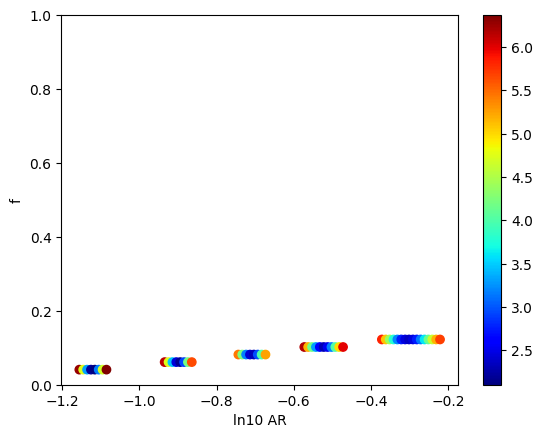

In [ ]:
scatter = plt.scatter(np.log10(merged_data["AR inclusion"]),  merged_data["f"],
                      c= merged_data["total diff"], cmap='jet', marker='o')

plt.colorbar(scatter)  # Add color bar to the plot
plt.xlabel('ln10 AR')
plt.ylabel('f')

plt.ylim(0, 1)

(0.0, 1.0)

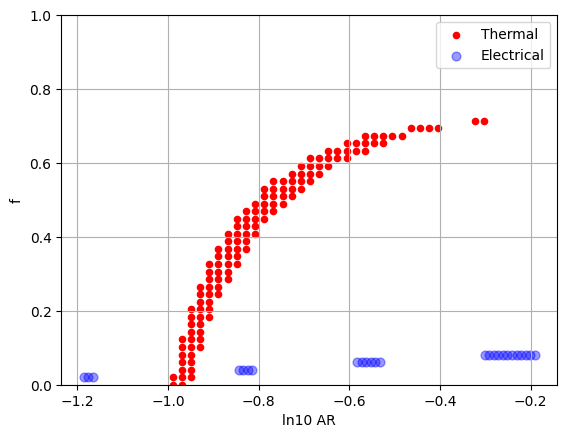

In [ ]:
# scatter1 = plt.scatter(np.log10(merged_data_tc["AR inclusion"]),  merged_data_tc["f"],
#                       c= merged_data_tc["total diff"], cmap='seismic', marker='o')

# scatter2 = plt.scatter(np.log10(merged_data["AR inclusion"]),  merged_data["f"],
#                       c= merged_data["total diff"], cmap='hsv', marker='o')

# plt.colorbar(scatter1)  # Add color bar to the plot
# plt.colorbar(scatter2)  # Add color bar to the plot


plt.scatter(np.log10(merged_data_tc["AR inclusion"]),  merged_data_tc["f"], color='red', s=20, label='Thermal')

plt.scatter(np.log10(merged_data["AR inclusion"]),  merged_data["f"], color='blue', alpha=0.4, s=40, label='Electrical')

plt.colorbar(scatter)  # Add color bar to the plot
plt.xlabel('ln10 AR')
plt.ylabel('f')
plt.grid()
plt.legend()

plt.ylim(0, 1)

### Elastic

In [ ]:
def velosity2modulus(density, Vp, Vs): ### <-- K, mu to Vp, Vs

    с_11 = Vp**2*density
    c_44 = Vs**2*density

    mu = c_44
    K = с_11 - 4/3*mu
    print(с_11,c_44, K, mu)

    return K, mu

In [ ]:
def modulus2velosity(density_mtrx, density_fluid, por, K, Mu): ### <-- K, mu to Vp, Vs

    density = density_mtrx * (1-por) + density_fluid * por
    Vp = np.sqrt((K + 4/3*Mu)/ density)
    Vs = np.sqrt(Mu/density)

    return Vp, Vs

In [ ]:
def HS_borders(K, μ, f):


  K_up = K[0] + (f[1]/((K[1]-K[0])**-1 +
                        f[0]*(K[0]+4/3*μ[0])**-1))

  K_lo = K[1] + (f[0]/((K[0]-K[1])**-1 +
                        f[1]*(K[1]+4/3*μ[1])**-1))

  K_av = np.mean([K_up, K_lo])

  μ_up = μ[0] + ((f[1])/((μ[1]-μ[0])**-1 +
                          2*f[0]*(K[0]+2*μ[0])/(5*μ[0]*(K[0]+4/3*μ[0]))))

  μ_lo = μ[1] + ((f[0])/((μ[0]-μ[1])**-1 +
                          2*f[1]*(K[1]+2*μ[1])/(5*μ[1]*(K[1]+4/3*μ[1]))))
  μ_av = np.mean([μ_up, μ_lo])

  return K_up, K_lo, K_av, μ_up, μ_lo, μ_av

In [ ]:
def prolate_common(K_i, Mu_i, AR, K_it, Mu_it): ### --> AR>1


    func_teta = (AR * ((AR ** 2-1) ** (-3 / 2))) * (AR * (AR ** 2-1) ** 0.5-np.arccosh(AR))
    func_f = AR ** 2 * (1-AR ** 2) ** -1 * (3 * func_teta-2)


    v_m = (3 * K_it-2 * Mu_it) / (6 * K_it+2 * Mu_it) ### < -- Poisson ration
    R = (1 - 2*v_m) / (2 *(1-v_m))

    A = Mu_i / Mu_it - 1
    B = 1/3 * ((K_i / K_it)-(Mu_i / Mu_it))

    F1 = 1+A * (1.5 * (func_f+func_teta)-R * (1.5 * func_f+2.5 * func_teta-4 / 3))
    F2 = 1+A * (1+1.5 * (func_f+func_teta)-0.5 * R * (3 * func_f+5 * func_teta))+ \
           B * (3-4 * R)+0.5 * A * (A+3 * B) * (3-4 * R) * (
                   func_f+func_teta-R * (func_f-func_teta+2 * func_teta ** 2))
    F3 = 1+A * (1-(func_f+1.5 * func_teta)+R * (func_f+func_teta))
    F4 = 1+0.25 * A * (func_f+3 * func_teta-R * (func_f-func_teta))
    F5 = A * (-func_f+R * (func_f+func_teta-4 / 3))+B * func_teta * (3-4 * R)
    F6 = 1+A * (1+func_f-R * (func_f+func_teta))+B * (1-func_teta) * (3-4 * R)
    F7 = 2+0.25 * A * (3 * func_f+9 * func_teta-R * (3 * func_f+5 * func_teta))+B * func_teta * (3-4 * R)
    F8 = A * (1-2 * R+0.5 * func_f * (R-1)+0.5 * func_teta * (5 * R-3))+B * (1-func_teta) * (3-4 * R)
    F9 = A * ((R-1) * func_f-R * func_teta)+B * func_teta * (3-4 * R)


    P = 1/3 * (3*F1 / F2)
    Q = 1 / 5 * (2 / F3+1 / F4+((F4 * F5+F6 * F7-F8 * F9) / (F2 * F4)))

    return P, Q


def oblate_common(K_i, Mu_i, AR, K_it, Mu_it): ### < --- oblate - AR < 1
                                              ### <-- K_i, Mu_i: components of medium
                                              ### <-- K_it, Mu_it: effective moduls, that iterate

    func_teta = AR / ((1-AR ** 2) ** (3/2)) * (np.arccos(AR) - AR * (1-AR ** 2) ** 0.5)
    func_f = (AR ** 2 / (1-AR ** 2)) * (3 * func_teta-2)

    v_m = (3 * K_it-2 * Mu_it) / (6 * K_it + 2 * Mu_it)
    R = (1-2 * v_m) / (2 * (1-v_m))

    A = (Mu_i / Mu_it)-1
    B = 1 / 3 * ((K_i / K_it)-(Mu_i / Mu_it))

    F1 = 1+A * (1.5 * (func_f+func_teta)-R * (1.5 * func_f+2.5 * func_teta-4 / 3))
    F2 = 1+A * (1+1.5 * (func_f+func_teta)-0.5 * R * (3 * func_f+5 * func_teta))+ \
           B * (3-4 * R)+0.5 * A * (A+3 * B) * (3-4 * R) * (func_f+func_teta-R * (func_f-func_teta+2 * func_teta ** 2))
    F3 = 1+A * (1-(func_f+1.5 * func_teta)+R * (func_f+func_teta))
    F4 = 1+0.25 * A * (func_f+3 * func_teta-R * (func_f-func_teta))
    F5 = A * (-func_f+R * (func_f+func_teta-4 / 3))+B * func_teta * (3-4 * R)
    F6 = 1+A * (1+func_f-R * (func_f+func_teta))+B * (1-func_teta) * (3-4 * R)
    F7 = 2+0.25 * A * (3 * func_f+9 * func_teta-R * (3 * func_f+5 * func_teta))+B * func_teta * (3-4 * R)
    F8 = A * (1-2 * R+0.5 * func_f * (R-1)+0.5 * func_teta * (5 * R-3))+B * (1-func_teta) * (3-4 * R)
    F9 = A * ((R-1) * func_f-R * func_teta)+B * func_teta * (3-4 * R)

    P = 1/3 * (3*F1/F2)
    Q = 1/5 * (2/F3 + 1/F4 + ((F4 * F5 + F6 * F7 - F8 * F9) / (F2 * F4)))

    return P, Q

In [ ]:
def effective_modulus(AR_mtrx, AR_fluid, K_it, Mu_it, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por):

  P_mtrx, Q_mtrx = 0, 0
  P_fl, Q_fl = 0, 0

  if AR_mtrx < 1:
    P_mtrx, Q_mtrx = oblate_common(K_matrix, Mu_matrix, AR_mtrx, K_it, Mu_it)
  elif AR_mtrx == 1:
    AR_mtrx = 1.00001
    P_mtrx, Q_mtrx = prolate_common(K_matrix, Mu_matrix, AR_mtrx, K_it, Mu_it)
  else:
     P_mtrx, Q_mtrx = prolate_common(K_matrix, Mu_matrix, AR_mtrx, K_it, Mu_it)


  if AR_fluid < 1:
    P_fl, Q_fl = oblate_common(K_fluid, Mu_fluid, AR_fluid, K_it, Mu_it)
  elif AR_fluid == 1:
    AR_fluid = 1.00001
    P_fl, Q_fl = prolate_common(K_fluid, Mu_fluid, AR_fluid, K_it, Mu_it)
  else:
    P_fl, Q_fl = prolate_common(K_fluid, Mu_fluid, AR_fluid, K_it, Mu_it)



  Mu = (((1-por) * Mu_matrix * Q_mtrx)+(por * Mu_fluid * Q_fl)) / (
            (1-por) * Q_mtrx + por * Q_fl)  # эффективный модуль сдвига


  K = (((1-por) * K_matrix * P_mtrx)+(por * K_fluid * P_fl)) / (
            (1-por) * P_mtrx + por * P_fl)  # эффективный модуль сжатия


  return K, Mu

In [ ]:
def main_Berryman_common(AR_mtrx, AR_fluid, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por, f):

  K, Mu = 0, 0

  x0, x1 = K_matrix*(1-f)+K_fluid*f, Mu_matrix*(1-f) + Mu_fluid*f ### <--- first initialization
  K_eff, Mu_eff = effective_modulus(AR_mtrx, AR_fluid, x0, x1, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)


  # while abs(x0-K_eff) and abs(x1-Mu_eff) >= eps:
  #   # print(x0, x1, K_eff, Mu_eff)
  #   x0, x1 = K_eff, Mu_eff
  #   K_eff, Mu_eff = effective_modulus(AR_mtrx, AR_fluid, x0, x1, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)

  K, Mu = K_eff, Mu_eff

  return K, Mu

In [ ]:
Vp_reg_air, Vs_reg_air = 5.77, 3.17
Vp_reg_water, Vs_reg_water = 6.13, 3.25
Vp_reg_oil, Vs_reg_oil = 6.19, 3.39

K_air_mtrx, Mu_air_mtrx = velosity2modulus(2.71, Vp_reg_air, Vs_reg_air)
K_water_mtrx, Mu_water_mtrx = velosity2modulus(2.71, Vp_reg_water, Vs_reg_water)
K_oil_mtrx, Mu_oil_mtrx = velosity2modulus(2.71, Vp_reg_oil, Vs_reg_oil)

K_water, Mu_water, p_water = 2.25, 10**-20, 1.04 ### water
K_air, Mu_air, p_air = 10**-6, 10**-6, 1.22 ### air
K_oil, Mu_oil, p_oil = 1, 10**-12, 1.04

density_air, density_water, density_oil = p_air, p_water, p_oil

90.22375899999999 27.232519 53.91373366666666 27.232519
101.833399 28.624375 63.66756566666667 28.624375
103.83663100000001 31.143591 62.31184300000001 31.143591


In [ ]:
K_air_mtrx, Mu_air_mtrx = 53.91373366666666, 27.232519
K_water_mtrx, Mu_water_mtrx = 63.66756566666667, 28.624375

Text(0.5, 1.0, 'Porosity - Elastic with dependecence from f')

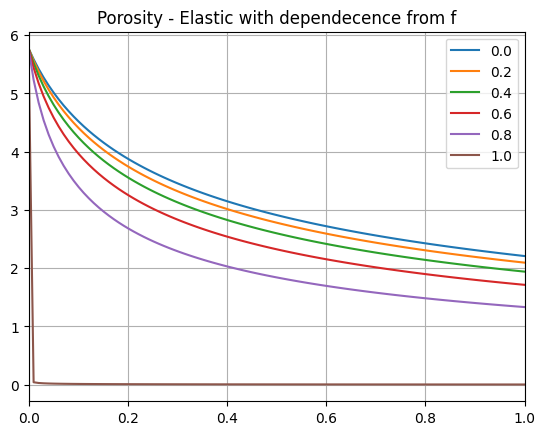

In [ ]:
N, n = 100, 6

for f in np.linspace(0, 1, n):

  Vp_array, Vs_array = [], []

  for porosity in np.linspace(0, 0.1, N):

    AR_mtrx, AR_inclusion = 1, 10**-2

    K, Mu = main_Berryman_common(AR_mtrx, AR_inclusion, K_air_mtrx, Mu_air_mtrx, K_air, Mu_air, porosity, f)

    # K, Mu = main_Berryman_common(AR_mtrx, AR_inclusion, K_water_mtrx, Mu_water_mtrx, K_water, Mu_water, porosity, f)
    density_mtrx, density_fluid = 2.71, p_water
    Vp, Vs = modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)

    Vp_array.append(Vp)
    Vs_array.append(Vs)

    # Vp_array.append(K)
    # Vs_array.append(Mu)

  plt.plot(np.linspace(0, 1, N),  Vp_array, label=f"{np.round(f, 1)}")
  # plt.plot(np.linspace(0, 1, N),  Vs_array, label=f"{np.round(f, 1)}")
  plt.legend()
plt.xlim(0,1)
# plt.ylim(5.8,6)
plt.grid()
plt.title('Porosity - Elastic with dependecence from f')


In [ ]:
fluid_list = ['air', 'water']
eps = 10**-8

for fluid in fluid_list:

    data_fluid = {

    }

    Vp_fluid_list = []
    Vs_fluid_list = []
    AR_list = []
    K_mtrx_var, mu_mtrx_var = [], []
    f_list = []

    globals()[f'result_{fluid}'] = pd.DataFrame(data_fluid)

    ### Matrix range
    globals()[f"K_{fluid}_matix_range"] = [
                                      globals()[f"K_{fluid}_mtrx"],
                                      ]

    globals()[f"Mu_{fluid}_matix_range"] = [
                                      globals()[f"Mu_{fluid}_mtrx"],
                                     ]


#     error_mtrx = 0

# ### Matrix range
#     globals()[f"K_{fluid}_matix_range"] = [globals()[f"K_{fluid}_mtrx"] - globals()[f"K_{fluid}_mtrx"] * error_mtrx ,
#                                       globals()[f"K_{fluid}_mtrx"],
#                                       globals()[f"K_{fluid}_mtrx"] + globals()[f"K_{fluid}_mtrx"] * error_mtrx ]

#     globals()[f"Mu_{fluid}_matix_range"] = [globals()[f"Mu_{fluid}_mtrx"] - globals()[f"Mu_{fluid}_mtrx"] * error_mtrx ,
#                                       globals()[f"Mu_{fluid}_mtrx"],
#                                       globals()[f"Mu_{fluid}_mtrx"] + globals()[f"Mu_{fluid}_mtrx"] * error_mtrx ]

    N, n = 300, 100

    for ar_inclusion in np.logspace(-2, 0, num=N, base=10):

      for f in np.linspace(0, 1, n):

        AR_inclusion = ar_inclusion
        AR_mtrx = 1.00001

        for k, mu in zip(globals()[f"K_{fluid}_matix_range"], globals()[f"Mu_{fluid}_matix_range"]):

          AR_list.append(ar_inclusion)
          f_list.append(f)

          K_matrix, Mu_matrix = k, mu
          K_mtrx_var.append(K_matrix)
          mu_mtrx_var.append(Mu_matrix)

          K, Mu = main_Berryman_common(AR_mtrx, AR_inclusion, k, mu, globals()[f"K_{fluid}"], globals()[f"Mu_{fluid}"] , porosity, f)
          density_mtrx, density_fluid = 2.71, globals()[f"density_{fluid}"]
          Vp, Vs = modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)

          Vp_fluid_list.append(Vp)
          Vs_fluid_list.append(Vs)

    globals()[f'result_{fluid}'][f'Porosity,%'] = [porosity]*len(Vp_fluid_list)
    globals()[f'result_{fluid}'][f'AR inclusion'] = AR_list
    globals()[f'result_{fluid}'][f'f'] = f_list

    globals()[f'result_{fluid}'][f'K matrx {fluid}'] = K_mtrx_var
    globals()[f'result_{fluid}'][f'Mu matrx {fluid}'] = mu_mtrx_var

    globals()[f'result_{fluid}'][f'Vp {fluid}'] = Vp_fluid_list
    globals()[f'result_{fluid}'][f'Vs {fluid}'] = Vs_fluid_list

    globals()[f'result_{fluid}'][f'Vp_exp_{fluid}'] = [globals()[f'Vp_exp_{fluid}']]*len(Vp_fluid_list)
    globals()[f'result_{fluid}'][f'Vs_exp_{fluid}'] = [globals()[f'Vs_exp_{fluid}']]*len(Vs_fluid_list)

    # HS_borders

    globals()[f'result_{fluid}'][f'K_HSup_{fluid}'], globals()[f'result_{fluid}'][f'K_HSlo_{fluid}'], _, _, _, _ =\
     HS_borders(
    [globals()[f'result_{fluid}'][f'K matrx {fluid}'], globals()[f"K_{fluid}"]],
    [globals()[f'result_{fluid}'][f'Mu matrx {fluid}'], globals()[f"Mu_{fluid}"]],
    [1 - globals()[f'result_{fluid}'][f'Porosity,%'], globals()[f'result_{fluid}'][f'Porosity,%']])

    _, _, _, globals()[f'result_{fluid}'][f'Mu_HSup_{fluid}'], globals()[f'result_{fluid}'][f'Mu_HSlo_{fluid}'], _ =\
     HS_borders(
    [globals()[f'result_{fluid}'][f'K matrx {fluid}'], globals()[f"K_{fluid}"]],
    [globals()[f'result_{fluid}'][f'Mu matrx {fluid}'], globals()[f"Mu_{fluid}"]],
    [1 - globals()[f'result_{fluid}'][f'Porosity,%'], globals()[f'result_{fluid}'][f'Porosity,%']])


    globals()[f'result_{fluid}'][f'Vp_HSup_{fluid}'], globals()[f'result_{fluid}'][f'Vs_HSup_{fluid}'] = \
    modulus2velosity(2.71, globals()[f"density_{fluid}"],
                     globals()[f'result_{fluid}'][f'Porosity,%'],
                     globals()[f'result_{fluid}'][f'K_HSup_{fluid}'], globals()[f'result_{fluid}'][f'Mu_HSup_{fluid}'])


    globals()[f'result_{fluid}'][f'Vp_HSlo_{fluid}'], globals()[f'result_{fluid}'][f'Vs_HSlo_{fluid}'] = \
    modulus2velosity(2.71, globals()[f"density_{fluid}"],
                     globals()[f'result_{fluid}'][f'Porosity,%'],
                     globals()[f'result_{fluid}'][f'K_HSlo_{fluid}'], globals()[f'result_{fluid}'][f'Mu_HSlo_{fluid}'])


### Selection
    globals()[f'result_{fluid}'][f'e_{fluid}'] = 3*globals()[f'result_{fluid}'][f'Porosity,%'] / (4 * pi * globals()[f'result_{fluid}'][f'AR inclusion'])
    globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][globals()[f'result_{fluid}'][f'e_{fluid}']<=1] # Select only void density < 1

    globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][
    (globals()[f'result_{fluid}'][f'Vp {fluid}'] >= globals()[f'result_{fluid}'][f'Vp_HSlo_{fluid}']) &
    (globals()[f'result_{fluid}'][f'Vp {fluid}'] <= globals()[f'result_{fluid}'][f'Vp_HSup_{fluid}'])
]

    globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][
    (globals()[f'result_{fluid}'][f'Vs {fluid}'] >= globals()[f'result_{fluid}'][f'Vs_HSlo_{fluid}']) &
    (globals()[f'result_{fluid}'][f'Vs {fluid}'] <= globals()[f'result_{fluid}'][f'Vs_HSup_{fluid}'])
]


    Vp_exp, Vs_exp = globals()[f"Vp_exp_{fluid}"], globals()[f"Vs_exp_{fluid}"]

### Relative diffrence between calculated and experimntal velocities
    globals()[f'result_{fluid}'][f'Diff Vp {fluid}'] = globals()[f'result_{fluid}'][[f'Vp {fluid}']]\
     .apply(lambda x: np.round((x[0] - Vp_exp)/Vp_exp*100, 2), axis=1)

    globals()[f'result_{fluid}'][f'Diff Vs {fluid}'] =globals()[f'result_{fluid}'][[f'Vs {fluid}']]\
    .apply(lambda x: np.round((x[0] - Vs_exp)/Vs_exp*100, 2), axis=1)

### Common relative diffrence between calculated and experimntal velocities
    globals()[f'result_{fluid}'][f'Diff'] = globals()[f'result_{fluid}']\
    .apply(lambda row: np.round(np.sqrt((row[f'Diff Vp {fluid}'])**2 + (row[f'Diff Vs {fluid}'])**2), 2), axis=1)

# ### Sort values
#     globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'].sort_values(by=f'Diff')

<ipython-input-57-a336f510f645>:5: RuntimeWarning: invalid value encountered in sqrt
  Vs = np.sqrt(Mu/density)


In [ ]:
result_air.shape

(22000, 21)

In [ ]:
vel_air = result_air
vel_water = result_water

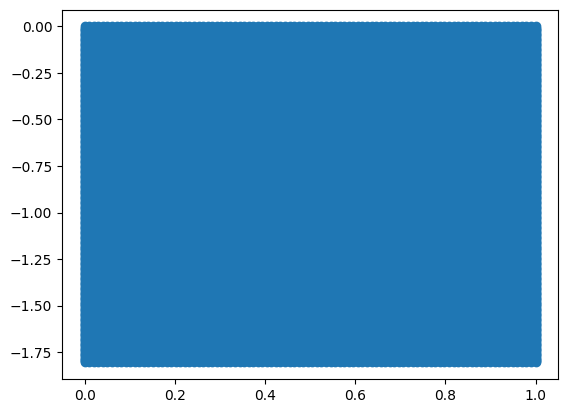

In [ ]:
plt.scatter(result_air["f"], np.log10(result_air["AR inclusion"]))

In [ ]:
result_water[:10]

Porosity,%  AR inclusion         f  K matrx water  Mu matrx water  \
2900    0.064734      0.015631  0.000000      63.667566       28.624375   
2901    0.064734      0.015631  0.010101      63.667566       28.624375   
2902    0.064734      0.015631  0.020202      63.667566       28.624375   
2903    0.064734      0.015631  0.030303      63.667566       28.624375   
2904    0.064734      0.015631  0.040404      63.667566       28.624375   
2905    0.064734      0.015631  0.050505      63.667566       28.624375   
2906    0.064734      0.015631  0.060606      63.667566       28.624375   
2907    0.064734      0.015631  0.070707      63.667566       28.624375   
2908    0.064734      0.015631  0.080808      63.667566       28.624375   
2909    0.064734      0.015631  0.090909      63.667566       28.624375   

      Vp water  Vs water  Vp_exp_water  Vs_exp_water  K_HSup_water  ...  \
2900  4.121880  2.215057        5.0545         2.665     54.547198  ...   
2901  4.120610  2.212793        5.0545         2.665     54.547198  ...   
2902  4.119312  2.210488        5.0545         2.665     54.547198  ...   
2903  4.117986  2.208139        5.0545         2.665     54.547198  ...   
2904  4.116632  2.205747        5.0545         2.665     54.547198  ...   
2905  4.115248  2.203309        5.0545         2.665     54.547198  ...   
2906  4.113833  2.200826        5.0545         2.665     54.547198  ...   
2907  4.112387  2.198294        5.0545         2.665     54.547198  ...   
2908  4.110910  2.195714        5.0545         2.665     54.547198  ...   
2909  4.109399  2.193083        5.0545         2.665     54.547198  ...   

      Mu_HSup_water  Mu_HSlo_water  Vp_HSup_water  Vs_HSup_water  \
2900       25.29044   3.711975e-19       5.718931       3.061201   
2901       25.29044   3.711975e-19       5.718931       3.061201   
2902       25.29044   3.711975e-19       5.718931       3.061201   
2903       25.29044   3.711975e-19       5.718931       3.061201   
2904       25.29044   3.711975e-19       5.718931       3.061201   
2905       25.29044   3.711975e-19       5.718931       3.061201   
2906       25.29044   3.711975e-19       5.718931       3.061201   
2907       25.29044   3.711975e-19       5.718931       3.061201   
2908       25.29044   3.711975e-19       5.718931       3.061201   
2909       25.29044   3.711975e-19       5.718931       3.061201   

      Vp_HSlo_water  Vs_HSlo_water   e_water  Diff Vp water  Diff Vs water  \
2900       2.919893   3.708653e-10  0.988694         -18.45         -16.88   
2901       2.919893   3.708653e-10  0.988694         -18.48         -16.97   
2902       2.919893   3.708653e-10  0.988694         -18.50         -17.05   
2903       2.919893   3.708653e-10  0.988694         -18.53         -17.14   
2904       2.919893   3.708653e-10  0.988694         -18.56         -17.23   
2905       2.919893   3.708653e-10  0.988694         -18.58         -17.32   
2906       2.919893   3.708653e-10  0.988694         -18.61         -17.42   
2907       2.919893   3.708653e-10  0.988694         -18.64         -17.51   
2908       2.919893   3.708653e-10  0.988694         -18.67         -17.61   
2909       2.919893   3.708653e-10  0.988694         -18.70         -17.71   

       Diff  
2900  25.01  
2901  25.09  
2902  25.16  
2903  25.24  
2904  25.32  
2905  25.40  
2906  25.49  
2907  25.57  
2908  25.66  
2909  25.76  

[10 rows x 21 columns]

In [ ]:
result_air["AR inclusion"].min(), result_air["AR inclusion"].max()

(0.02420128264794382, 1.0)

In [ ]:
result_water[:10]

Porosity,%  AR inclusion         f  K matrx water  Mu matrx water  Vp water  Vs water  \
2850         0.1      0.024201  0.000000      60.484187       27.193156  3.897871  2.158045   
2851         0.1      0.024201  0.000000      63.667566       28.624375  3.972059  2.210854   
2852         0.1      0.024201  0.000000      66.850944       30.055594  4.044291  2.262267   
2853         0.1      0.024201  0.020408      60.484187       27.193156  3.893897  2.153376   
2854         0.1      0.024201  0.020408      63.667566       28.624375  3.967795  2.206063   
2855         0.1      0.024201  0.020408      66.850944       30.055594  4.039737  2.257356   
2856         0.1      0.024201  0.040816      60.484187       27.193156  3.889787  2.148537   
2857         0.1      0.024201  0.040816      63.667566       28.624375  3.963388  2.201097   
2858         0.1      0.024201  0.040816      66.850944       30.055594  4.035034  2.252266   
2859         0.1      0.024201  0.061224      60.484187       27.193156  3.885534  2.143516   

      Vp_exp_water  Vs_exp_water  K_HSup_water  K_HSlo_water  Mu_HSup_water  Mu_HSlo_water  \
2850        4.0285         2.233     47.775967     16.856480      22.443578   2.350000e-19   
2851        4.0285         2.233     50.233968     17.070565      23.624819   2.350000e-19   
2852        4.0285         2.233     52.691733     17.269000      24.806060   2.350000e-19   
2853        4.0285         2.233     47.775967     16.856480      22.443578   2.350000e-19   
2854        4.0285         2.233     50.233968     17.070565      23.624819   2.350000e-19   
2855        4.0285         2.233     52.691733     17.269000      24.806060   2.350000e-19   
2856        4.0285         2.233     47.775967     16.856480      22.443578   2.350000e-19   
2857        4.0285         2.233     50.233968     17.070565      23.624819   2.350000e-19   
2858        4.0285         2.233     52.691733     17.269000      24.806060   2.350000e-19   
2859        4.0285         2.233     47.775967     16.856480      22.443578   2.350000e-19   

      Vp_HSup_water  Vs_HSup_water  Vp_HSlo_water  Vs_HSlo_water   e_water  Diff Vp water  \
2850       5.527635       2.970796       2.574603   3.039910e-10  0.986445          -3.24   
2851       5.669274       3.047973       2.590901   3.039910e-10  0.986445          -1.40   
2852       5.807452       3.123243       2.605916   3.039910e-10  0.986445           0.39   
2853       5.527635       2.970796       2.574603   3.039910e-10  0.986445          -3.34   
2854       5.669274       3.047973       2.590901   3.039910e-10  0.986445          -1.51   
2855       5.807452       3.123243       2.605916   3.039910e-10  0.986445           0.28   
2856       5.527635       2.970796       2.574603   3.039910e-10  0.986445          -3.44   
2857       5.669274       3.047973       2.590901   3.039910e-10  0.986445          -1.62   
2858       5.807452       3.123243       2.605916   3.039910e-10  0.986445           0.16   
2859       5.527635       2.970796       2.574603   3.039910e-10  0.986445          -3.55   

      Diff Vs water  Diff  
2850          -3.36  4.67  
2851          -0.99  1.71  
2852           1.31  1.37  
2853          -3.57  4.89  
2854          -1.21  1.93  
2855           1.09  1.13  
2856          -3.78  5.11  
2857          -1.43  2.16  
2858           0.86  0.87  
2859          -4.01  5.36

In [ ]:
calc_error = 5 # достуимая ошибка между эксериментальными и расчетными данными

In [ ]:
selected_row_air = result_air[(abs(result_air['Diff Vp air']) <= calc_error ) &\
                             (abs(result_air['Diff Vs air']) <= calc_error)]
selected_row_air[:5]

Porosity,%  AR inclusion         f  K matrx air  Mu matrx air    Vp air    Vs air  \
5102     0.08012      0.048626  0.000000     56.60942     28.594145  4.042347  2.502632   
5252     0.08012      0.050941  0.000000     56.60942     28.594145  4.087078  2.522847   
5255     0.08012      0.050941  0.020408     56.60942     28.594145  4.075351  2.517805   
5258     0.08012      0.050941  0.040816     56.60942     28.594145  4.063245  2.512581   
5261     0.08012      0.050941  0.061224     56.60942     28.594145  4.050742  2.507164   

      Vp_exp_air  Vs_exp_air  K_HSup_air  K_HSlo_air  Mu_HSup_air  Mu_HSlo_air  Vp_HSup_air  \
5102       4.248       2.562   46.537627    0.000028    24.488548     0.000023     5.422281   
5252       4.248       2.562   46.537627    0.000028    24.488548     0.000023     5.422281   
5255       4.248       2.562   46.537627    0.000028    24.488548     0.000023     5.422281   
5258       4.248       2.562   46.537627    0.000028    24.488548     0.000023     5.422281   
5261       4.248       2.562   46.537627    0.000028    24.488548     0.000023     5.422281   

      Vs_HSup_air  Vp_HSlo_air  Vs_HSlo_air     e_air  Diff Vp air  Diff Vs air  Diff  
5102     3.015303     0.004676     0.002943  0.393353        -4.84        -2.32  5.37  
5252     3.015303     0.004676     0.002943  0.375474        -3.79        -1.53  4.09  
5255     3.015303     0.004676     0.002943  0.375474        -4.06        -1.73  4.41  
5258     3.015303     0.004676     0.002943  0.375474        -4.35        -1.93  4.76  
5261     3.015303     0.004676     0.002943  0.375474        -4.64        -2.14  5.11

In [ ]:
selected_row_water = result_water[(abs(result_water['Diff Vp water']) <= calc_error ) &\
                               (abs(result_water['Diff Vs water'])  <= calc_error )]
selected_row_water[:5]

Porosity,%  AR inclusion         f  K matrx water  Mu matrx water  Vp water  Vs water  \
5852     0.08012      0.061359  0.000000      66.850944       30.055594  4.809123  2.724198   
6002     0.08012      0.064281  0.000000      66.850944       30.055594  4.838733  2.739314   
6005     0.08012      0.064281  0.020408      66.850944       30.055594  4.832061  2.735606   
6008     0.08012      0.064281  0.040816      66.850944       30.055594  4.825193  2.731761   
6011     0.08012      0.064281  0.061224      66.850944       30.055594  4.818118  2.727773   

      Vp_exp_water  Vs_exp_water  K_HSup_water  K_HSlo_water  Mu_HSup_water  Mu_HSlo_water  \
5852         5.058        2.6495     55.199898      20.25565      25.779154   2.970330e-19   
6002         5.058        2.6495     55.199898      20.25565      25.779154   2.970330e-19   
6005         5.058        2.6495     55.199898      20.25565      25.779154   2.970330e-19   
6008         5.058        2.6495     55.199898      20.25565      25.779154   2.970330e-19   
6011         5.058        2.6495     55.199898      20.25565      25.779154   2.970330e-19   

      Vp_HSup_water  Vs_HSup_water  Vp_HSlo_water  Vs_HSlo_water   e_water  Diff Vp water  \
5852       5.767006       3.093843        2.74244   3.320981e-10  0.311725          -4.92   
6002       5.767006       3.093843        2.74244   3.320981e-10  0.297557          -4.34   
6005       5.767006       3.093843        2.74244   3.320981e-10  0.297557          -4.47   
6008       5.767006       3.093843        2.74244   3.320981e-10  0.297557          -4.60   
6011       5.767006       3.093843        2.74244   3.320981e-10  0.297557          -4.74   

      Diff Vs water  Diff  
5852           2.82  5.67  
6002           3.39  5.51  
6005           3.25  5.53  
6008           3.10  5.55  
6011           2.95  5.58

In [ ]:
### Объеденение результатов инверсии для воздуха и воды. Объединяются по столбцу "AR inclusion"
merged_data_elastic = pd.merge(selected_row_air,
                       selected_row_water, on="AR inclusion", suffixes=('_air', '_water'), how='inner')

# merged_data will contain the rows where the "AR inclusion" values are equal in both DataFrames

merged_data_elastic['Diff air+water'] = np.sqrt(merged_data_elastic['Diff_air']*0.3 +merged_data_elastic['Diff_water']*0.7)
merged_data_elastic.sort_values(by=f'Diff air+water')

merged_data_elastic[:5]

Porosity,%_air  AR inclusion     f_air  K matrx air  Mu matrx air    Vp air    Vs air  \
0         0.08012      0.061359  0.000000    51.218047     25.870893  4.052840  2.472161   
1         0.08012      0.061359  0.000000    53.913734     27.232519  4.158126  2.536383   
2         0.08012      0.061359  0.000000    56.609420     28.594145  4.260811  2.599020   
3         0.08012      0.061359  0.020408    51.218047     25.870893  4.042050  2.467672   
4         0.08012      0.061359  0.020408    53.913734     27.232519  4.147055  2.531778   

   Vp_exp_air  Vs_exp_air  K_HSup_air  K_HSlo_air  Mu_HSup_air  Mu_HSlo_air  Vp_HSup_air  \
0       4.248       2.562   42.105472    0.000028    22.156305     0.000023     5.157618   
1       4.248       2.562   44.321549    0.000028    23.322426     0.000023     5.291604   
2       4.248       2.562   46.537627    0.000028    24.488548     0.000023     5.422281   
3       4.248       2.562   42.105472    0.000028    22.156305     0.000023     5.157618   
4       4.248       2.562   44.321549    0.000028    23.322426     0.000023     5.291604   

   Vs_HSup_air  Vp_HSlo_air  Vs_HSlo_air     e_air  Diff Vp air  Diff Vs air  Diff_air  \
0     2.868126     0.004676     0.002943  0.311725        -4.59        -3.51      5.78   
1     2.942635     0.004676     0.002943  0.311725        -2.12        -1.00      2.34   
2     3.015303     0.004676     0.002943  0.311725         0.30         1.44      1.47   
3     2.868126     0.004676     0.002943  0.311725        -4.85        -3.68      6.09   
4     2.942635     0.004676     0.002943  0.311725        -2.38        -1.18      2.66   

   Porosity,%_water  f_water  K matrx water  Mu matrx water  Vp water  Vs water  Vp_exp_water  \
0           0.08012      0.0      66.850944       30.055594  4.809123  2.724198         5.058   
1           0.08012      0.0      66.850944       30.055594  4.809123  2.724198         5.058   
2           0.08012      0.0      66.850944       30.055594  4.809123  2.724198         5.058   
3           0.08012      0.0      66.850944       30.055594  4.809123  2.724198         5.058   
4           0.08012      0.0      66.850944       30.055594  4.809123  2.724198         5.058   

   Vs_exp_water  K_HSup_water  K_HSlo_water  Mu_HSup_water  Mu_HSlo_water  Vp_HSup_water  \
0        2.6495     55.199898      20.25565      25.779154   2.970330e-19       5.767006   
1        2.6495     55.199898      20.25565      25.779154   2.970330e-19       5.767006   
2        2.6495     55.199898      20.25565      25.779154   2.970330e-19       5.767006   
3        2.6495     55.199898      20.25565      25.779154   2.970330e-19       5.767006   
4        2.6495     55.199898      20.25565      25.779154   2.970330e-19       5.767006   

   Vs_HSup_water  Vp_HSlo_water  Vs_HSlo_water   e_water  Diff Vp water  Diff Vs water  \
0       3.093843        2.74244   3.320981e-10  0.311725          -4.92           2.82   
1       3.093843        2.74244   3.320981e-10  0.311725          -4.92           2.82   
2       3.093843        2.74244   3.320981e-10  0.311725          -4.92           2.82   
3       3.093843        2.74244   3.320981e-10  0.311725          -4.92           2.82   
4       3.093843        2.74244   3.320981e-10  0.311725          -4.92           2.82   

   Diff_water  Diff air+water  
0        5.67        2.388095  
1        5.67        2.161250  
2        5.67        2.100000  
3        5.67        2.407488  
4        5.67        2.183346

Text(0.5, 0, 'ln10 AR')

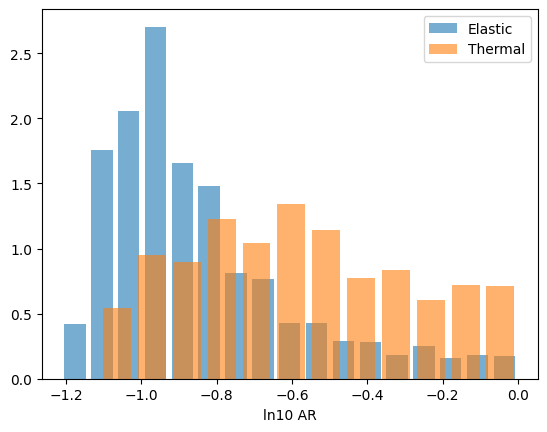

In [ ]:
plt.hist(np.log10(merged_data_elastic["AR inclusion"]), bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8, alpha=0.6, label='Elastic')

plt.hist(np.log10(merged_data_tc["AR inclusion"]), bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8, alpha=0.6, label='Thermal')

# plt.hist(np.log10(merged_data["AR inclusion"]), bins="sturges", density=True,
#          histtype='barstacked', rwidth=0.8, alpha=0.6, label='Electrical')

plt.legend()
plt.xlabel('ln10 AR')

Text(0.5, 0, 'f parametr')

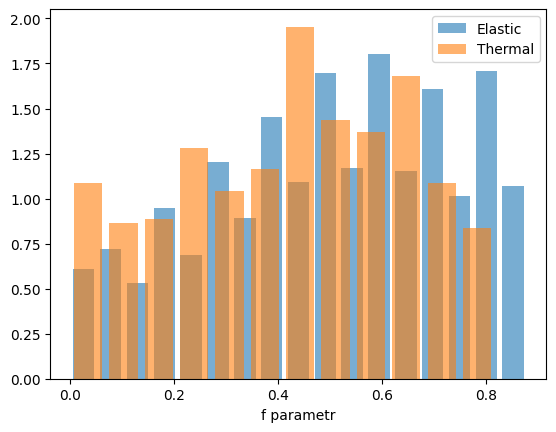

In [ ]:
plt.hist((merged_data_elastic["f_air"]), bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8, alpha=0.6, label='Elastic')

plt.hist((merged_data_tc["f"]), bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8, alpha=0.6, label='Thermal')

# plt.hist((merged_data["f"]), bins="sturges", density=True,
#          histtype='barstacked', rwidth=0.8, alpha=0.6, label='Electrical')

plt.legend()
plt.xlabel('f parametr')

In [ ]:
10**-0.8

0.15848931924611134

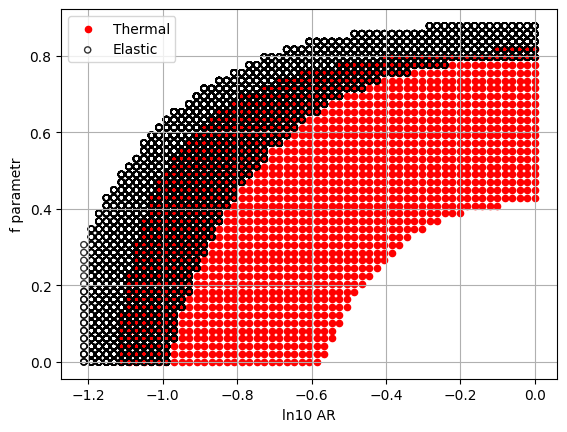

In [ ]:
plt.scatter(np.log10(merged_data_tc["AR inclusion"]),  merged_data_tc["f"], color='red', s=20, label='Thermal')


plt.scatter(np.log10(merged_data_elastic["AR inclusion"]),  merged_data_elastic["f_air"], alpha=0.8,
            s=20, label='Elastic',
            facecolors='none', edgecolors='black')

# plt.scatter(np.log10(merged_data["AR inclusion"]),  merged_data["f"], color='blue', s=40, label='Electrical')


plt.xlabel('ln10 AR')
plt.ylabel('f parametr')
plt.grid()
plt.legend()

# plt.ylim(0, 0.2)

In [ ]:
vel_air[:5]

Porosity,%  AR inclusion         f  K matrx air  Mu matrx air    Vp air    Vs air  \
700     0.08012      0.019179  0.000000    53.913734     27.232519  3.072580  2.006103   
701     0.08012      0.019179  0.020408    53.913734     27.232519  3.060623  1.999935   
702     0.08012      0.019179  0.040816    53.913734     27.232519  3.048316  1.993565   
703     0.08012      0.019179  0.061224    53.913734     27.232519  3.035642  1.986982   
704     0.08012      0.019179  0.081633    53.913734     27.232519  3.022584  1.980176   

     Vp_exp_air  Vs_exp_air  K_HSup_air  K_HSlo_air  Mu_HSup_air  Mu_HSlo_air  Vp_HSup_air  \
700       4.248       2.562   44.321549    0.000028    23.322426     0.000023     5.395552   
701       4.248       2.562   44.321549    0.000028    23.322426     0.000023     5.395552   
702       4.248       2.562   44.321549    0.000028    23.322426     0.000023     5.395552   
703       4.248       2.562   44.321549    0.000028    23.322426     0.000023     5.395552   
704       4.248       2.562   44.321549    0.000028    23.322426     0.000023     5.395552   

     Vs_HSup_air  Vp_HSlo_air  Vs_HSlo_air     e_air  Diff Vp air  Diff Vs air   Diff  
700      3.00044     0.004768     0.003001  0.997293       -27.67       -21.70  35.16  
701      3.00044     0.004768     0.003001  0.997293       -27.95       -21.94  35.53  
702      3.00044     0.004768     0.003001  0.997293       -28.24       -22.19  35.92  
703      3.00044     0.004768     0.003001  0.997293       -28.54       -22.44  36.31  
704      3.00044     0.004768     0.003001  0.997293       -28.85       -22.71  36.72

### Thermal + Elastic + Electrical

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
### Merge Thermal conductivity
merged_data_tc = pd.merge(tc_air,
                       tc_water,
                       on=["AR inclusion", "f"], how='inner')

merged_data_tc = pd.merge(merged_data_tc,
                       tc_oil,
                       on=["AR inclusion", "f"], how='inner')

merged_data_tc[:5]

Porosity,%_x  AR inclusion         f  TCmtrx_air    TC_air    e_air  \
0      0.141927      0.034286  0.000000        2.95  1.460443  0.98823   
1      0.141927      0.034286  0.010101        2.95  1.458870  0.98823   
2      0.141927      0.034286  0.020202        2.95  1.457271  0.98823   
3      0.141927      0.034286  0.030303        2.95  1.455648  0.98823   
4      0.141927      0.034286  0.040404        2.95  1.453997  0.98823   

   TC_exp_air  TC_HSup_air  TC_HSlo_air  Diff TC air  ...  TC_HSlo_water  \
0    1.867175     2.370526     0.409057        21.78  ...       2.301244   
1    1.867175     2.370526     0.409057        21.87  ...       2.301244   
2    1.867175     2.370526     0.409057        21.95  ...       2.301244   
3    1.867175     2.370526     0.409057        22.04  ...       2.301244   
4    1.867175     2.370526     0.409057        22.13  ...       2.301244   

   Diff TC water  Porosity,%  TCmtrx_oil    TC_oil    e_oil  TC_exp_oil  \
0           9.53    0.141927        2.95  1.761085  0.98823    2.286873   
1           9.50    0.141927        2.95  1.761271  0.98823    2.286873   
2           9.48    0.141927        2.95  1.761456  0.98823    2.286873   
3           9.45    0.141927        2.95  1.761640  0.98823    2.286873   
4           9.42    0.141927        2.95  1.761823  0.98823    2.286873   

   TC_HSup_oil  TC_HSlo_oil  Diff TC oil  
0     2.396463     1.267775        22.99  
1     2.396463     1.267775        22.98  
2     2.396463     1.267775        22.98  
3     2.396463     1.267775        22.97  
4     2.396463     1.267775        22.96  

[5 rows x 26 columns]

In [ ]:
### Find diff for thermal conductivity in diffrent saturation states

diff_columns_tc = merged_data_tc.filter(like='Diff').copy()
diff_columns_tc.loc[:, ["AR inclusion", "f"]] = merged_data_tc[["AR inclusion", "f"]]

matrix_nX3 = np.column_stack((diff_columns_tc["Diff TC air"],
                              diff_columns_tc["Diff TC water"],
                              diff_columns_tc["Diff TC oil"]))

diff_columns_tc["Diff TC fluid"] = np.sqrt(np.sum(matrix_nX3 ** 2, axis=1))

# Normalization Линейное масштабирование
diff_columns_tc["Diff TC fluid"] = MinMaxScaler().fit_transform(np.array(diff_columns_tc["Diff TC fluid"]).reshape(-1, 1))

print(diff_columns_tc[:5])

   Diff TC air  Diff TC water  Diff TC oil  AR inclusion         f  \
0        21.78           9.53        22.99      0.034286  0.000000   
1        21.87           9.50        22.98      0.034286  0.010101   
2        21.95           9.48        22.98      0.034286  0.020202   
3        22.04           9.45        22.97      0.034286  0.030303   
4        22.13           9.42        22.96      0.034286  0.040404   

   Diff TC fluid  
0       0.266809  
1       0.267366  
2       0.267966  
3       0.268529  
4       0.269094  


In [ ]:
### Merge Elastic properties
merged_data_elastic = pd.merge(vel_air,
                               vel_water,
                               on=["AR inclusion", "f"], suffixes=['_air', '_water'], how='inner')

In [ ]:
### Find diff for elastic velocities in diffrent saturation states

diff_columns_elastic = merged_data_elastic.filter(like='Diff_').copy() # Diff include Vp and Vs relative diffrence
                                                                      # for Vp and Vs of the same saturation

diff_columns_elastic.loc[:, ["AR inclusion", "f"]] = merged_data_elastic[["AR inclusion", "f"]]

matrix_nX3 = np.column_stack((diff_columns_elastic["Diff_air"],
                              diff_columns_elastic["Diff_water"]))

diff_columns_elastic["Diff velocities fluid"] = np.sqrt(np.sum(matrix_nX3 ** 2, axis=1))

# Normalization Линейное масштабирование
diff_columns_elastic["Diff velocities fluid"] = MinMaxScaler().fit_transform(np.array(diff_columns_elastic["Diff velocities fluid"]).reshape(-1, 1))

print(diff_columns_elastic[:5])

   Diff_air  Diff_water  AR inclusion         f  Diff velocities fluid
0     10.09        4.85      0.034286  0.000000               0.045598
1     10.17        4.84      0.034286  0.010101               0.046081
2     10.28        4.83      0.034286  0.020202               0.046760
3     10.39        4.83      0.034286  0.030303               0.047470
4     10.50        4.83      0.034286  0.040404               0.048182


In [ ]:
### Merge electric conductivity
merged_data_electric = pd.merge(electric_180,
                       electric_60,
                       on=["AR inclusion", "f"], how='inner')

merged_data_electric = pd.merge(merged_data_electric,
                       electric_6,
                       on=["AR inclusion", "f"], how='inner')

merged_data_electric[:5]

Porosity,%_x  AR inclusion         f    TC_180  TC_exp_180    e_180  \
0      0.141927      0.034286  0.000000  5.026920    2.626467  0.98823   
1      0.141927      0.034286  0.010101  1.908540    2.626467  0.98823   
2      0.141927      0.034286  0.020202  1.404061    2.626467  0.98823   
3      0.141927      0.034286  0.030303  1.195903    2.626467  0.98823   
4      0.141927      0.034286  0.040404  1.081292    2.626467  0.98823   

   Diff TC 180  Porosity,%_y      TC_60  TC_exp_60     e_60  Diff TC 60  \
0        67.23      0.141927  13.875388   5.854637  0.98823       48.83   
1        33.07      0.141927   4.494211   5.854637  0.98823       14.96   
2        64.86      0.141927   3.236355   5.854637  0.98823       33.54   
3        81.47      0.141927   2.734665   5.854637  0.98823       43.07   
4        91.91      0.141927   2.462602   5.854637  0.98823       49.00   

   Porosity,%        TC_6   TC_exp_6      e_6  Diff TC 6  
0    0.141927  109.085724  46.416085  0.98823      22.27  
1    0.141927   35.618719  46.416085  0.98823       6.90  
2    0.141927   25.675087  46.416085  0.98823      15.43  
3    0.141927   21.702911  46.416085  0.98823      19.81  
4    0.141927   19.547350  46.416085  0.98823      22.53

In [ ]:
### Find diff for electric conductivityin diffrent saturation states

diff_columns_electric = merged_data_electric.filter(like='Diff').copy()
diff_columns_electric.loc[:, ["AR inclusion", "f"]] = merged_data_electric[["AR inclusion", "f"]]

matrix_nX3 = np.column_stack((diff_columns_electric ["Diff TC 180"],
                              diff_columns_electric ["Diff TC 60"],
                              diff_columns_electric ["Diff TC 6"]))

diff_columns_electric["Diff Electric fluid"] = np.sqrt(np.sum(matrix_nX3 ** 2, axis=1))

diff_columns_electric["Diff Electric fluid"] = MinMaxScaler().fit_transform(np.array(diff_columns_electric["Diff Electric fluid"]).reshape(-1, 1))

diff_columns_electric[:5]

Diff TC 180  Diff TC 60  Diff TC 6  AR inclusion         f  \
0        67.23       48.83      22.27      0.034286  0.000000   
1        33.07       14.96       6.90      0.034286  0.010101   
2        64.86       33.54      15.43      0.034286  0.020202   
3        81.47       43.07      19.81      0.034286  0.030303   
4        91.91       49.00      22.53      0.034286  0.040404   

   Diff Electric fluid  
0             0.366520  
1             0.152732  
2             0.316891  
3             0.402392  
4             0.455995

In [ ]:
### Merge Thermal, Elastic properties, Electrical properteis
merged_data_total = pd.merge(diff_columns_tc,
                               diff_columns_elastic,
                               on=["AR inclusion", "f"], how='inner')

merged_data_total = pd.merge(merged_data_total,
                               diff_columns_electric,
                               on=["AR inclusion", "f"], how='inner')

merged_data_total['Diff tc+velocities'] = np.sqrt(merged_data_total['Diff TC fluid']**2 + \
                                                  merged_data_total['Diff velocities fluid']**2)

merged_data_total['Diff tc+velocities+electrical'] = np.sqrt(merged_data_total['Diff TC fluid']**2 + \
                                                  merged_data_total['Diff velocities fluid']**2 + \
                                                             merged_data_total['Diff Electric fluid']**2)

merged_data_total[:5]

Diff TC air  Diff TC water  Diff TC oil  AR inclusion         f  \
0        21.78           9.53        22.99      0.034286  0.000000   
1        21.87           9.50        22.98      0.034286  0.010101   
2        21.95           9.48        22.98      0.034286  0.020202   
3        22.04           9.45        22.97      0.034286  0.030303   
4        22.13           9.42        22.96      0.034286  0.040404   

   Diff TC fluid  Diff_air  Diff_water  Diff velocities fluid  Diff TC 180  \
0       0.266809     10.09        4.85               0.045598        67.23   
1       0.267366     10.17        4.84               0.046081        33.07   
2       0.267966     10.28        4.83               0.046760        64.86   
3       0.268529     10.39        4.83               0.047470        81.47   
4       0.269094     10.50        4.83               0.048182        91.91   

   Diff TC 60  Diff TC 6  Diff Electric fluid  Diff tc+velocities  \
0       48.83      22.27             0.366520            0.270677   
1       14.96       6.90             0.152732            0.271308   
2       33.54      15.43             0.316891            0.272016   
3       43.07      19.81             0.402392            0.272692   
4       49.00      22.53             0.455995            0.273374   

   Diff tc+velocities+electrical  
0                       0.455634  
1                       0.311344  
2                       0.417627  
3                       0.486087  
4                       0.531662

In [ ]:
# X_train= np.array(merged_data_total["Diff tc+velocities"]).reshape(-1, 1)
# min_max_scaler = MinMaxScaler()
# X_train_minmax_1 = min_max_scaler.fit_transform(X_train)

In [ ]:
# X_train = np.array(merged_data_total["Diff tc+velocities+electrical"]).reshape(-1, 1)
# min_max_scaler = MinMaxScaler()
# X_train_minmax_2 = min_max_scaler.fit_transform(X_train)

(0.0, 1.0)

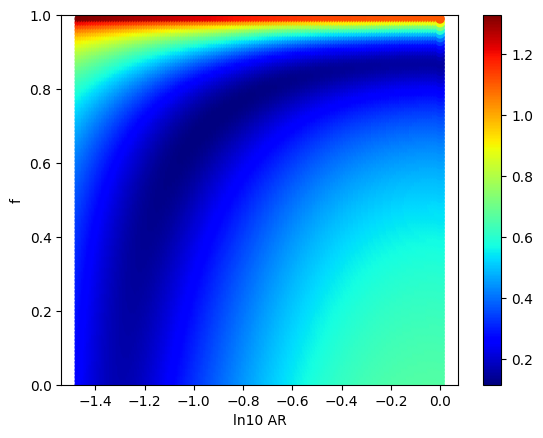

In [ ]:
scatter = plt.scatter(np.log10(merged_data_total["AR inclusion"]), merged_data_total["f"],
                      c=merged_data_total['Diff tc+velocities'], cmap='jet', marker='o')

plt.colorbar(scatter)  # Add color bar to the plot
plt.xlabel('ln10 AR')
plt.ylabel('f')

plt.ylim(0, 1)

(0.0, 1.0)

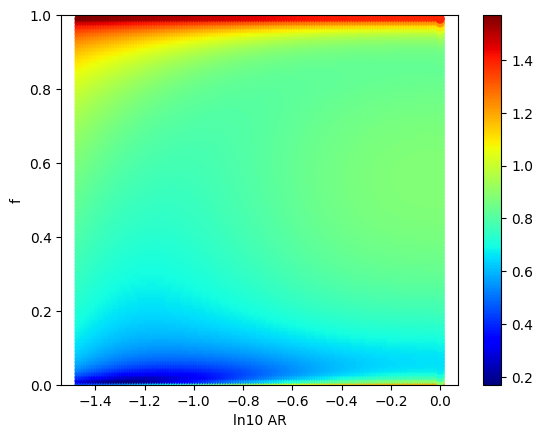

In [ ]:
scatter = plt.scatter(np.log10(merged_data_total["AR inclusion"]), merged_data_total["f"],
                      c=merged_data_total['Diff tc+velocities+electrical'], cmap='jet', marker='o')

plt.colorbar(scatter)  # Add color bar to the plot
plt.xlabel('ln10 AR')
plt.ylabel('f')

plt.ylim(0, 1)

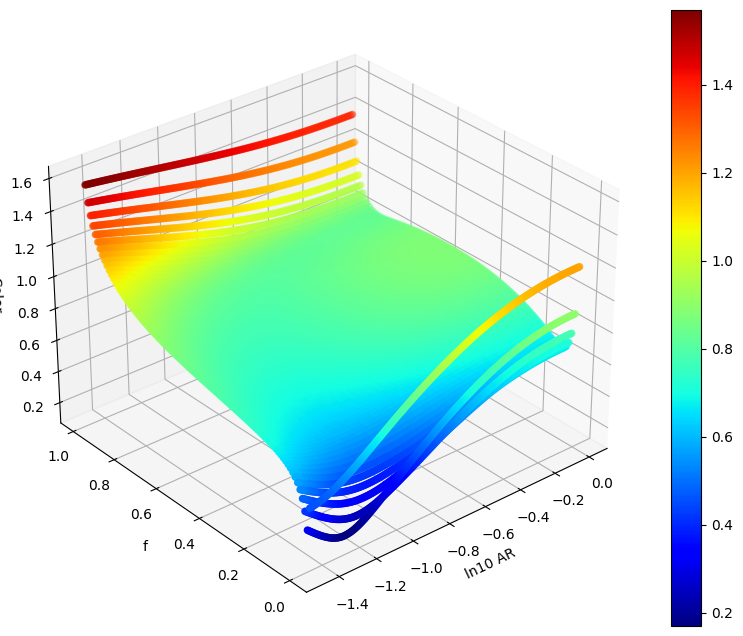

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))  # Set the figure size to be larger
ax = fig.add_subplot(111, projection='3d')

z_data = merged_data_total['Diff tc+velocities+electrical']
# z_data = merged_data_total['Diff tc+velocities']

# Create a 3D scatter plot
scatter = ax.scatter(np.log10(merged_data_total["AR inclusion"]), merged_data_total["f"],
                     z_data , c=z_data , cmap='jet', marker='o')

# Add color bar to the plot
plt.colorbar(scatter)

# Set labels for the axes
ax.set_xlabel('ln10 AR')
ax.set_ylabel('f')
ax.set_zlabel('Color')

# Set initial viewing angle for rotation
ax.view_init(elev=30, azim=-130)  # Adjust the elevation (elev) and azimuth (azim) angles for desired rotation

plt.show()

In [ ]:
idx

3

In [ ]:
globals()[f"sample_{idx}_AR"] =  np.log10(merged_data_total["AR inclusion"])
globals()[f"sample_{idx}_f"] =  merged_data_total["f"]
globals()[f"sample_{idx}_diff"] = merged_data_total['Diff tc+velocities+electrical']

(array([0.80883871, 0.80883871, 0.80883871, 0.80883871, 0.80883871,
        0.80883871, 0.71896774, 0.80883871, 0.80883871, 0.80883871,
        0.80883871, 0.80883871, 0.80883871, 0.80883871]),
 array([-1.24623116, -1.15721464, -1.06819813, -0.97918162, -0.89016511,
        -0.8011486 , -0.71213209, -0.62311558, -0.53409907, -0.44508256,
        -0.35606604, -0.26704953, -0.17803302, -0.08901651,  0.        ]),
 <BarContainer object of 14 artists>)

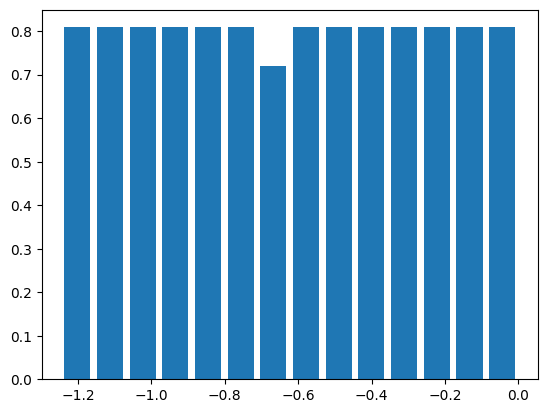

In [ ]:
plt.hist(np.log10(merged_data_total["AR inclusion"]), bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8)

(array([1.16666667, 0.875     , 1.16666667, 0.875     , 1.16666667,
        0.875     , 0.875     , 1.16666667, 0.875     , 1.16666667,
        0.875     , 1.16666667, 0.875     , 1.16666667]),
 array([0.        , 0.06997085, 0.13994169, 0.20991254, 0.27988338,
        0.34985423, 0.41982507, 0.48979592, 0.55976676, 0.62973761,
        0.69970845, 0.7696793 , 0.83965015, 0.90962099, 0.97959184]),
 <BarContainer object of 14 artists>)

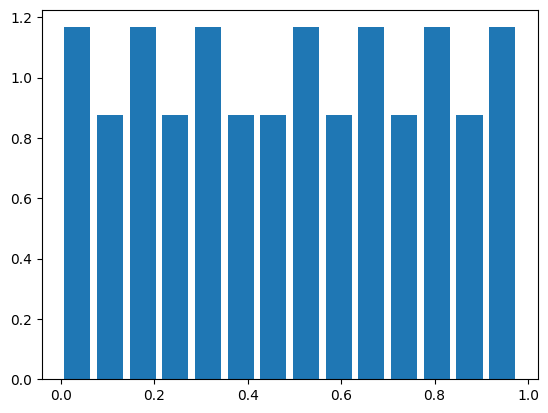

In [ ]:
plt.hist(merged_data_total["f"], bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8)

In [ ]:
for i in range(0, 4):
  globals()[f"sample_{i}"] = pd.DataFrame()

  globals()[f"sample_{i}"][f'AR'] = globals()[f"sample_{i}_AR"]
  globals()[f"sample_{i}"][f'f'] = globals()[f"sample_{i}_f"]
  globals()[f"sample_{i}"][f'Diff'] = globals()[f"sample_{i}_diff"]

In [ ]:
sample_2[:5]

AR         f      Diff
0 -1.444816  0.000000  0.472440
1 -1.444816  0.010101  0.346101
2 -1.444816  0.020202  0.452725
3 -1.444816  0.030303  0.522056
4 -1.444816  0.040404  0.568524

In [ ]:
merged_sample = pd.DataFrame()

merged_sample = pd.merge(sample_0, sample_1,
                       on=["AR", "f"], how='inner')

merged_sample = pd.merge(merged_sample,
                       sample_2,
                       on=["AR", "f"], how='inner')

merged_sample = pd.merge(merged_sample,
                       sample_3, suffixes=['_1', '_2'],
                       on=["AR", "f"], how='inner')

merged_sample['Diff total'] = np.sqrt(merged_sample['Diff_x']**2 + \
                                      merged_sample['Diff_y']**2 + \
                                      merged_sample['Diff_1']**2 + \
                                      merged_sample['Diff_2']**2)

In [ ]:
merged_sample[:5]

AR         f    Diff_x    Diff_y    Diff_1    Diff_2  Diff total
0 -1.444816  0.000000  0.128666  0.206756  0.472440  0.459607    0.702667
1 -1.444816  0.010101  0.412947  0.454116  0.346101  0.289703    0.761880
2 -1.444816  0.020202  0.544115  0.579427  0.452725  0.398151    0.997638
3 -1.444816  0.030303  0.615919  0.648243  0.522056  0.469053    1.136718
4 -1.444816  0.040404  0.662027  0.692436  0.568524  0.516446    1.227878

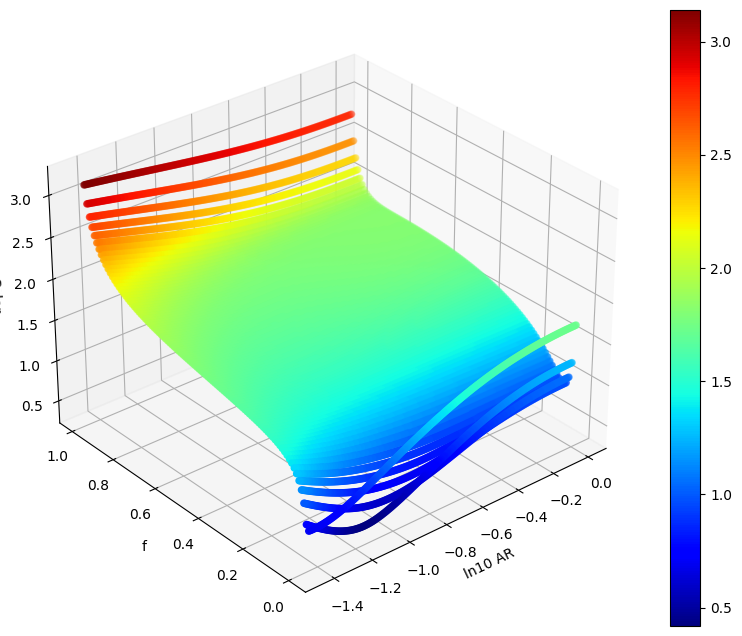

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))  # Set the figure size to be larger
ax = fig.add_subplot(111, projection='3d')

z_data = merged_sample['Diff total']
# z_data = merged_data_total['Diff tc+velocities']

# Create a 3D scatter plot
scatter = ax.scatter(merged_sample["AR"], merged_sample["f"],
                     z_data , c=z_data , cmap='jet', marker='o')

# Add color bar to the plot
plt.colorbar(scatter)

# Set labels for the axes
ax.set_xlabel('ln10 AR')
ax.set_ylabel('f')
ax.set_zlabel('Color')

# Set initial viewing angle for rotation
ax.view_init(elev=30, azim=-130)  # Adjust the elevation (elev) and azimuth (azim) angles for desired rotation

plt.show()

(0.0, 1.0)

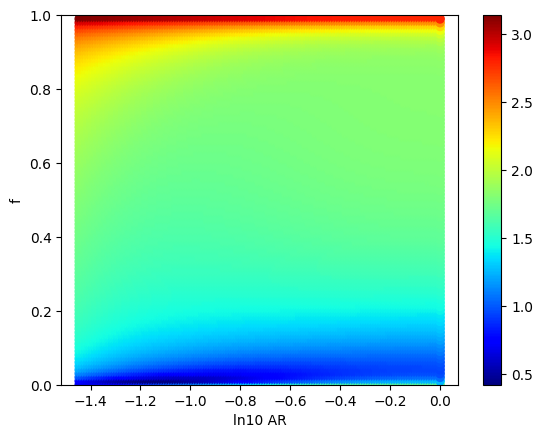

In [ ]:
scatter = plt.scatter(merged_sample["AR"], merged_sample["f"],
                      c=merged_sample['Diff total'], cmap='jet', marker='o')

plt.colorbar(scatter)  # Add color bar to the plot
plt.xlabel('ln10 AR')
plt.ylabel('f')

plt.ylim(0, 1)

# Double porosity f-model

In [3]:
path_to_ser = Path('/content/NewElasticity_v1/f model.xlsx')
df_ues_ar = pd.read_excel(path_to_ser, skiprows=0)

In [4]:
df_ues_ar.columns

Index(['#', 'Sample', 'Well', 'Litholohy', 'Porosity,%', 'Permeability',
       'Density (air)', 'Density (water)', 'Density (oil)', 'Vp air', 'Vs air',
       'Vp oil', 'Vs oil', 'Vp water', 'Vs water', 'Unnamed: 15', 'AR thermal',
       'AO electrical', 'AR elastic', 'Unnamed: 19', 'TC air', 'TC oil',
       'TC 0,6', 'TC 6', 'TC 60', 'TC 180', 'Unnamed: 26', 'Скважина', 'R 0.6',
       'R 6', 'R 60', 'R 180', 'Unnamed: 32', 'Unnamed: 33', 'УЭС, Ом*м',
       'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Провод-ть, См/м',
       'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41'],
      dtype='object')

In [5]:
df_ues_ar.dropna(subset=['Porosity,%'], inplace=True)

### Thermal

In [29]:
# Matrix value changes within error
def double_porosity(fluid, lam_fluid, lam_matrix_list, porosity,
                    experemental_value, prop):

  ###
  # prop: str, physical property to name columns
  ###

  data_fluid = []

  tc_eff_list, f_result, ar_result = [], [], []
  tc_mtrx = []
  crack_porosity_list = []
  hs_up_list, hs_lo_list = [], []

  globals()[f'result_{fluid}'] = pd.DataFrame()
  globals()[f'sorted_{fluid}'] = pd.DataFrame()

  lam_fluid = lam_fluid
  print(fluid, lam_fluid)


  N, n = 50, 20 # Amount of nodes


  for matrix_value in lam_matrix_list:
    for f in np.linspace(0, 1, n):
      for crack_porosity in np.linspace(0, 0.005, n):
        for ar_cracks in np.logspace(-4, -2,  N, base=10):

          conc = [1-porosity, porosity-crack_porosity, crack_porosity]
          AR_pore = 1.
          alpha_shape = [1, AR_pore, ar_cracks]
          lam = [matrix_value, lam_fluid, lam_fluid]

          lam_eff = effective_tc_f(conc, alpha_shape, lam, f)

          # print(conc, alpha_shape, lam, lam_eff, f)

          tc_eff_list.append(lam_eff)
          f_result.append(f)
          ar_result.append(ar_cracks)
          tc_mtrx.append(matrix_value)
          crack_porosity_list.append(crack_porosity)

          hs_up_list.append(Upper_Hashin_Strikman(conc, lam))
          hs_lo_list.append(Lower_Hashin_Strikman(conc, lam))

  globals()[f'result_{fluid}'][f'Porosity,%'] = [porosity]*len(tc_eff_list)
  globals()[f'result_{fluid}'][f'AR inclusion'] = ar_result
  globals()[f'result_{fluid}'][f'f'] = f_result
  globals()[f'result_{fluid}'][f'crack porosity'] = crack_porosity_list
  globals()[f'result_{fluid}'][f'{prop}_mtrx_{fluid}'] = tc_mtrx
  globals()[f'result_{fluid}'][f'{prop}_{fluid}'] = tc_eff_list

  globals()[f'result_{fluid}'][f'{prop}_HSup_{fluid}'] = hs_up_list
  globals()[f'result_{fluid}'][f'{prop}_HSlo_{fluid}'] = hs_lo_list

  globals()[f'result_{fluid}'][f'e_{fluid}'] = 3*globals()[f'result_{fluid}'][f'crack porosity'] / (4 * pi * globals()[f'result_{fluid}'][f'AR inclusion'])
  globals()[f'result_{fluid}'][f'{prop}_exp_{fluid}'] = [experemental_value]*len(tc_eff_list)

  # print(globals()[f'result_{fluid}'].shape)



  # globals()[f'result_{fluid}'][f'TC_HSup_{fluid}'] = Upper_Hashin_Strikman([1-globals()[f'result_{fluid}'][f'Porosity,%'], globals()[f'result_{fluid}'][f'Porosity,%']],
  #                                                                         [globals()[f"lam_mtrx_{fluid}"], lam_fluid])

  # globals()[f'result_{fluid}'][f'TC_HSlo_{fluid}'] =  Lower_Hashin_Strikman([1-globals()[f'result_{fluid}'][f'Porosity,%'], globals()[f'result_{fluid}'][f'Porosity,%']],
  #                                                                         [globals()[f"lam_mtrx_{fluid}"], lam_fluid])

  # Calculate the difference and assign it directly to the new column 'Diff Vp air'
  TC_exp = globals()[f'result_{fluid}'][f'{prop}_exp_{fluid}']
  globals()[f'result_{fluid}'][f'Diff {prop} {fluid}'] = abs(np.round((globals()[f'result_{fluid}'][f'{prop}_{fluid}'] - TC_exp) / TC_exp * 100, 2))
  globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][globals()[f'result_{fluid}'][f'e_{fluid}']<=1] # Select only void density < 1

  # print(globals()[f'result_{fluid}'].shape)

  globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][
  (globals()[f'result_{fluid}'][f'{prop}_{fluid}'] >= globals()[f'result_{fluid}'][f'{prop}_HSlo_{fluid}']) &
  (globals()[f'result_{fluid}'][f'{prop}_{fluid}'] <= globals()[f'result_{fluid}'][f'{prop}_HSup_{fluid}'])
]


  # globals()[f'sorted_{fluid}'] = globals()[f'result_{fluid}'][(globals()[f'result_{fluid}'][f'Diff TC {fluid}'].abs() > 5)].sort_values(by=[f'Diff TC {fluid}'], key=lambda x: x.abs())

  return globals()[f'result_{fluid}']

In [37]:

# # Merge all states function
# def merge_table(selected_row_air, selected_row_water, selected_row_oil, idx):
#   globals()[f"merged_data_{idx}"] = pd.merge(selected_row_air, selected_row_water,
#                   on=["AR inclusion", "f"], suffixes=('_air', '_water'), how='inner')

#   globals()[f"merged_data_{idx}"] = pd.merge(globals()[f"merged_data_{idx}"], selected_row_oil,
#                       on=["AR inclusion", "f"], suffixes=('_merged', '_oil'), how='inner')

#   globals()[f"merged_data_{idx}"]['total diff'] = np.sqrt(globals()[f"merged_data_{idx}"]["Diff TC air"]**2 + \
#                                   globals()[f"merged_data_{idx}"]["Diff TC water"]**2 +\
#                                   globals()[f"merged_data_{idx}"]["Diff TC oil"]**2 )

#   print('merge shape func', globals()[f"merged_data_{idx}"].shape[0])
#   return globals()[f"merged_data_{idx}"]


# Merge all states function
def merge_table(selected_row_air, selected_row_water, selected_row_oil, prop):

  merged_data = pd.DataFrame()

  merged_data = pd.merge(selected_row_air, selected_row_water,
                  on=["AR inclusion", "f", "crack porosity"], suffixes=('_air', '_water'), how='inner')

  merged_data = pd.merge(merged_data, selected_row_oil,
                      on=["AR inclusion", "f", "crack porosity"], suffixes=('_merged', '_oil'), how='inner')

  merged_data['total diff'] = np.sqrt(merged_data[f"Diff {prop} air"]**2 + \
                                   merged_data[f"Diff {prop} water"]**2 +\
                                   merged_data[f"Diff {prop} oil"]**2 )
  return merged_data

In [38]:
def thermal_calculation(prop, experemental_error = True):
  ###
  # experemental_error = True: выбор значений по расхождению с эксериментальным
  # данными

  # for number in range(0, len(df_ues_ar["#"])):
  for number in df_ues_ar.index.tolist()[1:2]:

    fluid_list_full = ['air', 'water', 'oil']

    idx = number

    print(idx)
    porosity = df_ues_ar["Porosity,%"][idx]
    print(porosity)

    if np.isnan(porosity):
      pass

    else:

      global lam_air, lam_water, lam_oil
      global lam_mtrx_air, lam_mtrx_water, lam_mtrx_oil
      global error_air, error_water, error_oil
      global air_tc_exp, water_tc_exp, oil_tc_exp

      porosity /= 100
      # Experemental values
      air_tc_exp = df_ues_ar["TC air"][idx]
      water_tc_exp = df_ues_ar["TC 6"][idx]
      oil_tc_exp = df_ues_ar["TC oil"][idx]
      print(porosity, air_tc_exp, water_tc_exp, oil_tc_exp)


      lam_air, lam_water, lam_oil = 0.025, 0.6, 0.12
      lam_mtrx_air, lam_mtrx_water, lam_mtrx_oil = 2.95, 2.95, 2.95

      # Error in mineral matrix values
      error_air, error_water, error_oil = 0.0, 0.0, 0.0 # Error for K, mu minreal matrix
      N = 1

      globals()[f"merged_data_{idx}"] = pd.DataFrame()

      if experemental_error==False:

        for fluid in fluid_list_full:
          globals()[f"lam_mtrx_{fluid}_list"] = np.linspace(globals()[f"lam_mtrx_{fluid}"] - globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
              globals()[f"lam_mtrx_{fluid}"] + globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"], N)
          # print(globals()[f"lam_mtrx_{fluid}_list"])
          globals()[f'result_{fluid}'] = double_porosity(fluid,
                                                         globals()[f"lam_{fluid}"],
                                                         globals()[f"lam_mtrx_{fluid}_list"],
                                                         porosity,
                                                         globals()[f"{fluid}_tc_exp"],
                                                         prop)

        globals()[f"merged_data_{idx}"] = merge_table(selected_row_air,
                                                      selected_row_water,
                                                      selected_row_oil,
                                                      prop)

      else:

        # Цикл - если в обобщенной таблице для нескольких состояний, число строк равно нулю,
        # то проводиться новый расчет с ошибкой увеличенной на 2,5%
        globals()[f"merged_data_{idx}"] = pd.DataFrame()
        error = 2.5

        while globals()[f"merged_data_{idx}"].shape[0] == 0:
          # print("error: ", error, globals()[f"merged_data_{idx}"].shape[0])

          for fluid in fluid_list_full:

            globals()[f"selected_row_{fluid}"] = pd.DataFrame()
            globals()[f"lam_mtrx_{fluid}_list"] = np.linspace(globals()[f"lam_mtrx_{fluid}"] - globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                              globals()[f"lam_mtrx_{fluid}"] + globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                              N)
            # print(globals()[f"lam_mtrx_{fluid}_list"])
            globals()[f'result_{fluid}'] = double_porosity(fluid,
                                                           globals()[f"lam_{fluid}"],
                                                           globals()[f"lam_mtrx_{fluid}_list"],
                                                           porosity,
                                                           globals()[f"{fluid}_tc_exp"],
                                                           prop = 'TC')

            globals()[f"selected_row_{fluid}"] = globals()[f'result_{fluid}'][(abs(globals()[f'result_{fluid}'][f'Diff {prop} {fluid}']) <= error)]

          globals()[f"merged_data_{idx}"] = merge_table(selected_row_air,
                                                        selected_row_water,
                                                        selected_row_oil,
                                                        prop)
          print(error)
          error +=2.5


      # Pd DataFrame for each sample
      globals()[f"sample_{idx}"] = pd.DataFrame()
      globals()[f"sample_{idx}"] = globals()[f"merged_data_{idx}"]
      globals()[f"sample_{idx}"].to_csv(f'/content/Sample_double_porosity_{idx}.csv', index=True)

      # # Plot data
      # data = globals()[f"sample_{idx}"]
      # scatter = plt.scatter(np.log10(data["AR inclusion"]), data["f"],
      #                       c=data["total diff"], cmap='jet', marker='o')'
      # plt.colorbar(scatter)

      # plt.xlabel('ln10 AR')
      # plt.ylabel('f')
      # plt.ylim(0, 1)

In [42]:
thermal_calculation(prop='TC', experemental_error = False)

1
6.47337128595146
0.0647337128595146 2.404575 2.741125 2.60088763678152
air 0.025
water 0.6
oil 0.12


In [43]:
sample_1

Porosity,%_air  AR inclusion         f  crack porosity  TC_mtrx_air  \
0           0.064734      0.000655  0.000000        0.002632         2.95   
1           0.064734      0.000720  0.000000        0.002895         2.95   
2           0.064734      0.000791  0.000000        0.002895         2.95   
3           0.064734      0.000869  0.000000        0.002895         2.95   
4           0.064734      0.000954  0.000000        0.002895         2.95   
...              ...           ...       ...             ...          ...   
2368        0.064734      0.010000  0.684211        0.003158         2.95   
2369        0.064734      0.007543  0.684211        0.003421         2.95   
2370        0.064734      0.008286  0.684211        0.003421         2.95   
2371        0.064734      0.009103  0.684211        0.003421         2.95   
2372        0.064734      0.010000  0.684211        0.003421         2.95   

        TC_air  TC_HSup_air  TC_HSlo_air     e_air  TC_exp_air  ...  \
0     2.462813     2.675937     0.801157  0.958962    2.404575  ...   
1     2.445645     2.675937     0.801157  0.960235    2.404575  ...   
2     2.448095     2.675937     0.801157  0.874100    2.404575  ...   
3     2.450727     2.675937     0.801157  0.795692    2.404575  ...   
4     2.453551     2.675937     0.801157  0.724317    2.404575  ...   
...        ...          ...          ...       ...         ...  ...   
2368  2.430192     2.675937     0.801157  0.075389    2.404575  ...   
2369  2.413827     2.675937     0.801157  0.108273    2.404575  ...   
2370  2.416899     2.675937     0.801157  0.098561    2.404575  ...   
2371  2.420078     2.675937     0.801157  0.089720    2.404575  ...   
2372  2.423357     2.675937     0.801157  0.081672    2.404575  ...   

      Diff TC water  Porosity,%  TC_mtrx_oil    TC_oil  TC_HSup_oil  \
0              0.05    0.064734         2.95  2.642275     2.688637   
1              0.03    0.064734         2.95  2.637859     2.688637   
2              0.03    0.064734         2.95  2.638000     2.688637   
3              0.03    0.064734         2.95  2.638154     2.688637   
4              0.03    0.064734         2.95  2.638322     2.688637   
...             ...         ...          ...       ...          ...   
2368           1.54    0.064734         2.95  2.538258     2.688637   
2369           1.54    0.064734         2.95  2.535774     2.688637   
2370           1.54    0.064734         2.95  2.536018     2.688637   
2371           1.54    0.064734         2.95  2.536282     2.688637   
2372           1.54    0.064734         2.95  2.536566     2.688637   

      TC_HSlo_oil     e_oil  TC_exp_oil  Diff TC oil  total diff  
0        1.874152  0.958962    2.600888         1.59    2.896032  
1        1.874152  0.960235    2.600888         1.42    2.222926  
2        1.874152  0.874100    2.600888         1.43    2.306924  
3        1.874152  0.795692    2.600888         1.43    2.394201  
4        1.874152  0.724317    2.600888         1.44    2.497218  
...           ...       ...         ...          ...         ...  
2368     1.874152  0.075389    2.600888         2.41    3.053621  
2369     1.874152  0.108273    2.600888         2.50    2.960743  
2370     1.874152  0.098561    2.600888         2.49    2.971834  
2371     1.874152  0.089720    2.600888         2.48    2.988578  
2372     1.874152  0.081672    2.600888         2.47    3.013453  

[2373 rows x 28 columns]

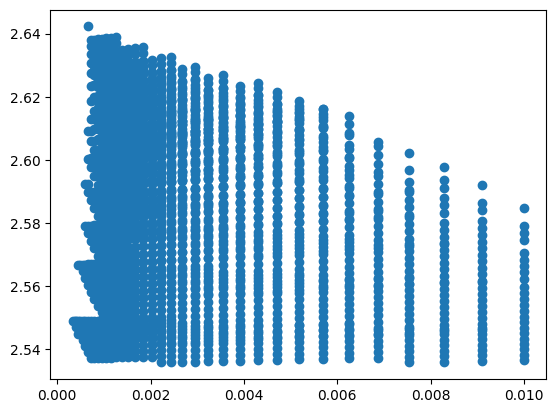

In [44]:
plt.scatter(sample_1['AR inclusion'], sample_1['TC_oil'])

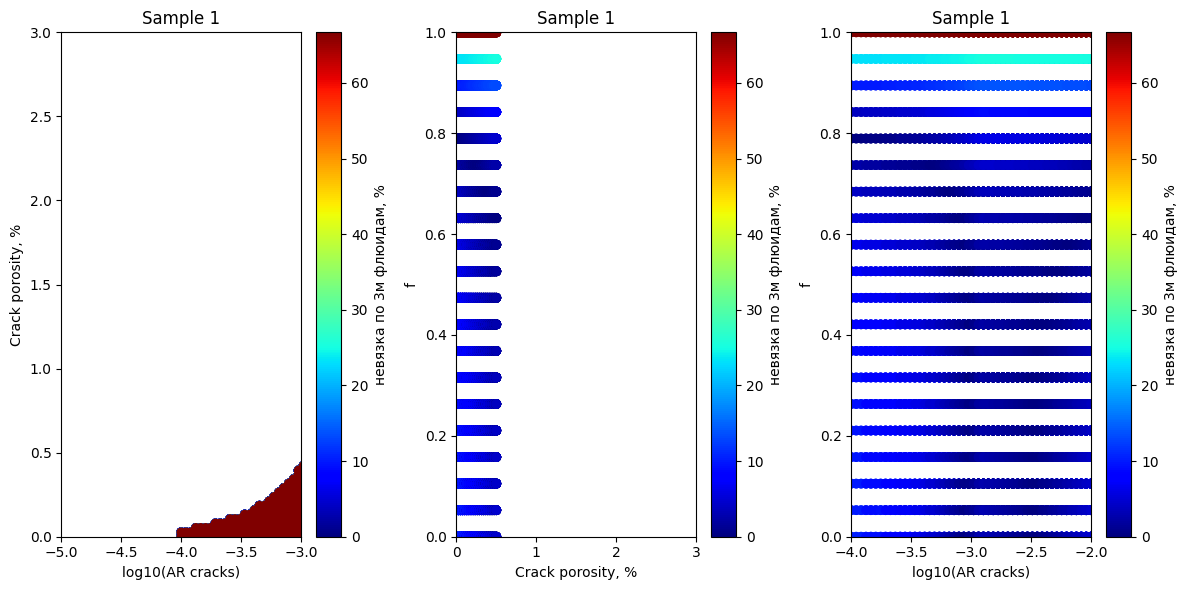

In [28]:
# for idx in range(0, len(df_ues_ar["#"])):
from sklearn.preprocessing import MinMaxScaler

for idx in range(1, 2):
    try:
        path_to_ser = Path(f'/content/Sample_double_porosity_{idx}.csv')
        globals()[f"Sample_{idx}"] = pd.read_csv(path_to_ser, skiprows=0)

    except FileNotFoundError:
        print(f"FileNotFoundError: Sample_{idx}.csv not found. Skipping to the next index.")
        continue  # Skip to the next index

    data = globals()[f"Sample_{idx}"]

    fig, axs = plt.subplots(1, 3, figsize=(12, 6))

    for ax in axs:
      ax.set_title(f'Sample {idx}')

    # First scatter plot
    scatter1 = axs[0].scatter(np.log10(data["AR inclusion"]), data["crack porosity"]*100,
                              c=data["Diff TC air"], cmap='jet', marker='o')
    axs[0].set_xlabel('log10(AR cracks)')
    axs[0].set_ylabel('Crack porosity, %')
    axs[0].set_xlim(-5, -3)
    axs[0].set_ylim(0, 3)
    colorbar1 = plt.colorbar(scatter1, ax=axs[0])
    colorbar1.set_label('невязка по 3м флюидам, %')

    # Second scatter plot
    scatter2 = axs[1].scatter(data["crack porosity"]*100, data['f'],
                              c=data["Diff TC air"], cmap='jet', marker='o')
    axs[1].set_ylabel('f')
    axs[1].set_xlabel('Crack porosity, %')
    axs[1].set_ylim(0, 1)
    axs[1].set_xlim(0, 3)
    colorbar2 = plt.colorbar(scatter2, ax=axs[1])
    colorbar2.set_label('невязка по 3м флюидам, %')

    # Third scatter plot
    scatter3 = axs[2].scatter(np.log10(data["AR inclusion"]), data['f'],
                              c=data["Diff TC air"], cmap='jet', marker='o')
    axs[2].set_ylabel('f')
    axs[2].set_xlabel('log10(AR cracks)')
    axs[2].set_ylim(0, 1)
    axs[2].set_xlim(-4, -2)
    colorbar3 = plt.colorbar(scatter3, ax=axs[2])
    colorbar3.set_label('невязка по 3м флюидам, %')

    plt.tight_layout()
    plt.show()

### Electrical

In [ ]:
# # Matrix value changes within error
# def double_porosity(fluid, lam_matrix_list):

#   data_fluid = []

#   tc_eff_list, f_result, ar_result = [], [], []
#   tc_mtrx = []
#   crack_porosity_list = []
#   hs_up_list, hs_lo_list = [], []

#   globals()[f'result_{fluid}'] = pd.DataFrame()
#   globals()[f'sorted_{fluid}'] = pd.DataFrame()

#   lam_fluid = 0

#   if fluid=='air':
#     lam_fluid = 1.060
#   elif fluid == 'water':
#     lam_fluid = 8.42
#   elif fluid == 'oil':
#     lam_fluid = 18.87


#   N, n = 100, 20 # Amount of nodes


#   for matrix_value in lam_matrix_list:
#     for crack_porosity in np.linspace(0, 0.03, n):
#       for ar_cracks in np.logspace(-5, -3, N, base=10):
#         for f in np.linspace(0, 1, n):

#           conc = [1-porosity, porosity-crack_porosity, crack_porosity ]
#           AR_pore = 1
#           alpha_shape = [1, AR_pore, ar_cracks]
#           lam = [matrix_value, lam_fluid, lam_fluid]

#           lam_eff = effective_tc_f(conc, alpha_shape, lam, f)

#           tc_eff_list.append(lam_eff)
#           f_result.append(f)
#           ar_result.append(ar_cracks)
#           tc_mtrx.append(matrix_value)
#           crack_porosity_list.append(crack_porosity)

#           hs_up_list.append(Upper_Hashin_Strikman(conc, lam))
#           hs_lo_list.append(Lower_Hashin_Strikman(conc, lam))

#   globals()[f'result_{fluid}'][f'Porosity,%'] = [porosity]*len(tc_eff_list)
#   globals()[f'result_{fluid}'][f'AR inclusion'] = ar_result
#   globals()[f'result_{fluid}'][f'f'] = f_result
#   globals()[f'result_{fluid}'][f'crack porosity'] = crack_porosity_list
#   globals()[f'result_{fluid}'][f'TCmtrx_{fluid}'] = tc_mtrx
#   globals()[f'result_{fluid}'][f'TC_{fluid}'] = tc_eff_list

#   globals()[f'result_{fluid}'][f'TC_HSup_{fluid}'] = hs_up_list
#   globals()[f'result_{fluid}'][f'TC_HSlo_{fluid}'] = hs_lo_list

#   globals()[f'result_{fluid}'][f'e_{fluid}'] = 3*globals()[f'result_{fluid}'][f'crack porosity'] / (4 * pi * globals()[f'result_{fluid}'][f'AR inclusion'])
#   globals()[f'result_{fluid}'][f'TC_exp_{fluid}'] = [globals()[f'{fluid}_tc_exp']]*len(tc_eff_list)



#   # globals()[f'result_{fluid}'][f'TC_HSup_{fluid}'] = Upper_Hashin_Strikman([1-globals()[f'result_{fluid}'][f'Porosity,%'], globals()[f'result_{fluid}'][f'Porosity,%']],
#   #                                                                         [globals()[f"lam_mtrx_{fluid}"], lam_fluid])

#   # globals()[f'result_{fluid}'][f'TC_HSlo_{fluid}'] =  Lower_Hashin_Strikman([1-globals()[f'result_{fluid}'][f'Porosity,%'], globals()[f'result_{fluid}'][f'Porosity,%']],
#   #                                                                         [globals()[f"lam_mtrx_{fluid}"], lam_fluid])

#   # Calculate the difference and assign it directly to the new column 'Diff Vp air'
#   TC_exp = globals()[f'result_{fluid}'][f'TC_exp_{fluid}']
#   globals()[f'result_{fluid}'][f'Diff TC {fluid}'] = abs(np.round((globals()[f'result_{fluid}'][f'TC_{fluid}'] - TC_exp) / TC_exp * 100, 2))
#   globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][globals()[f'result_{fluid}'][f'e_{fluid}']<=1] # Select only void density < 1

#   globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][
#   (globals()[f'result_{fluid}'][f'TC_{fluid}'] >= globals()[f'result_{fluid}'][f'TC_HSlo_{fluid}']) &
#   (globals()[f'result_{fluid}'][f'TC_{fluid}'] <= globals()[f'result_{fluid}'][f'TC_HSup_{fluid}'])
# ]


#   # globals()[f'sorted_{fluid}'] = globals()[f'result_{fluid}'][(globals()[f'result_{fluid}'][f'Diff TC {fluid}'].abs() > 5)].sort_values(by=[f'Diff TC {fluid}'], key=lambda x: x.abs())

#   return globals()[f'result_{fluid}']

In [55]:
def electrical_calculation(prop, experemental_error = True):
  ###
  # experemental_error = True: выбор значений по расхождению с эксериментальным
  # данными

  # for number in range(0, len(df_ues_ar["#"])):
  for number in df_ues_ar.index.tolist()[1:2]:

    fluid_list_full = ['air', 'water', 'oil']

    idx = number

    print(idx)
    porosity = df_ues_ar["Porosity,%"][idx]
    print(porosity)

    if np.isnan(porosity):
      pass

    else:

      global elec_air, elec_water, elec_oil
      global elec_mtrx_air, elec_mtrx_water, elec_mtrx_oil
      global error_air, error_water, error_oil
      global air_elec_exp, water_elec_exp, oil_elec_exp

      porosity /= 100
      # Experemental values
      air_elec_exp = 1/ df_ues_ar["R 6"][idx]
      water_elec_exp = 1 / df_ues_ar["R 60"][idx]
      oil_elec_exp = 1/ df_ues_ar["R 180"][idx]

      print(porosity, air_elec_exp, water_elec_exp, oil_elec_exp)

      elec_air, elec_water, elec_oil = 1.060, 8.42, 18.87
      elec_mtrx_air, elec_mtrx_water, elec_mtrx_oil = 1.82*10**-3, 1.43*10**-2, 4.00*10**-2

      # Error in mineral matrix values
      error_air, error_water, error_oil = 0.0, 0.0, 0.0 # Error for K, mu minreal matrix
      N = 1

      globals()[f"merged_data_{idx}"] = pd.DataFrame()

      if experemental_error==False:

        for fluid in fluid_list_full:
          globals()[f"elec_mtrx_{fluid}_list"] = np.linspace(globals()[f"elec_mtrx_{fluid}"] - globals()[f"elec_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
              globals()[f"elec_mtrx_{fluid}"] + globals()[f"elec_mtrx_{fluid}"] * globals()[f"error_{fluid}"], N)
          # print(globals()[f"elec_mtrx_{fluid}_list"])
          globals()[f'result_{fluid}'] = double_porosity(fluid,
                                                         globals()[f"elec_{fluid}"],
                                                         globals()[f"elec_mtrx_{fluid}_list"],
                                                         porosity,
                                                         globals()[f"{fluid}_elec_exp"],
                                                         prop )

        globals()[f"merged_data_{idx}"] = merge_table(selected_row_air,
                                                      selected_row_water,
                                                      selected_row_oil,
                                                      prop)

      else:

        # Цикл - если в обобщенной таблице для нескольких состояний, число строк равно нулю,
        # то проводиться новый расчет с ошибкой увеличенной на 2,5%
        globals()[f"merged_data_{idx}"] = pd.DataFrame()
        error = 2.5

        while globals()[f"merged_data_{idx}"].shape[0] == 0:
          # print("error: ", error, globals()[f"merged_data_{idx}"].shape[0])

          for fluid in fluid_list_full:

            globals()[f"selected_row_{fluid}"] = pd.DataFrame()
            globals()[f"elec_mtrx_{fluid}_list"] = np.linspace(globals()[f"elec_mtrx_{fluid}"] - globals()[f"elec_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                              globals()[f"elec_mtrx_{fluid}"] + globals()[f"elec_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                              N)
            # print(globals()[f"elec_mtrx_{fluid}_list"])
            globals()[f'result_{fluid}'] = double_porosity(fluid,
                                                           globals()[f"elec_{fluid}"],
                                                           globals()[f"elec_mtrx_{fluid}_list"],
                                                           porosity,
                                                           globals()[f"{fluid}_elec_exp"],
                                                           prop)

            globals()[f"selected_row_{fluid}"] = globals()[f'result_{fluid}'][(abs(globals()[f'result_{fluid}'][f'Diff {prop} {fluid}']) <= error)]

          globals()[f"merged_data_{idx}"] = merge_table(selected_row_air, selected_row_water, selected_row_oil, prop)
          print(error)
          error +=2.5


      # Pd DataFrame for each sample
      globals()[f"sample_{idx}"] = pd.DataFrame()
      globals()[f"sample_{idx}"] = globals()[f"merged_data_{idx}"]
      globals()[f"sample_{idx}"].to_csv(f'/content/Sample_double_porosity_{idx}.csv', index=True)

      # # Plot data
      # data = globals()[f"sample_{idx}"]
      # scatter = plt.scatter(np.log10(data["AR inclusion"]), data["f"],
      #                       c=data["total diff"], cmap='jet', marker='o')'
      # plt.colorbar(scatter)

      # plt.xlabel('ln10 AR')
      # plt.ylabel('f')
      # plt.ylim(0, 1)

In [56]:
electrical_calculation(prop='Elec',
                       experemental_error = True)

1
6.47337128595146
0.0647337128595146 0.005267822879586187 0.03944316569971774 0.08998536773860918
air 1.06
water 8.42
oil 18.87
2.5
air 1.06
water 8.42
oil 18.87
5.0
air 1.06
water 8.42
oil 18.87
7.5
air 1.06
water 8.42
oil 18.87
10.0
air 1.06
water 8.42
oil 18.87
12.5
air 1.06
water 8.42
oil 18.87
15.0


In [57]:
sample_1

Porosity,%_air  AR inclusion    f  crack porosity  Elec_mtrx_air  Elec_air  \
0        0.064734      0.001151  0.0        0.004737        0.00182  0.004508   
1        0.064734      0.001265  0.0        0.005000        0.00182  0.004555   

   Elec_HSup_air  Elec_HSlo_air     e_air  Elec_exp_air  ...  Diff Elec water  \
0       0.048532       0.002196  0.982145      0.005268  ...             9.87   
1       0.048532       0.002196  0.943714      0.005268  ...             8.93   

   Porosity,%  Elec_mtrx_oil  Elec_oil  Elec_HSup_oil  Elec_HSlo_oil  \
0    0.064734           0.04  0.092186       0.871387       0.048249   
1    0.064734           0.04  0.093286       0.871387       0.048249   

      e_oil  Elec_exp_oil  Diff Elec oil  total diff  
0  0.982145      0.089985           2.45   17.653450  
1  0.943714      0.089985           3.67   16.621513  

[2 rows x 28 columns]

In [58]:
# for number in range(0, len(df_ues_ar["#"])):
for number in df_ues_ar.index.tolist()[0:1]:

  fluid_list_full = ['air', 'water', 'oil']

  idx = number

  print(idx)
  porosity = df_ues_ar["Porosity,%"][idx]

  if np.isnan(porosity):
    pass

  else:
    porosity /= 100
    # Experemental values
    air_tc_exp = 1/ df_ues_ar["R 6"][idx]
    water_tc_exp = 1/ df_ues_ar["R 60"][idx]
    oil_tc_exp = 1/ df_ues_ar["R 180"][idx]

    print(porosity, air_tc_exp, water_tc_exp, oil_tc_exp)

    lam_air, lam_water, lam_oil = 1.060, 8.42, 18.87
    lam_mtrx_air, lam_mtrx_water, lam_mtrx_oil = 1.82*10**-3, 1.43*10**-2, 4.00*10**-2

    # Error in mineral matrix values
    error_air, error_water, error_oil = 0.0, 0.0, 0.0 # Error for K, mu minreal matrix
    N = 1

    # Цикл - если в обобщенной таблице для нескольких состояний, число строк равно нулю,
    # то проводиться новый расчет с ошибкой увеличенной на 2,5%
    globals()[f"merged_data_{idx}"] = pd.DataFrame()
    error = 8

    while globals()[f"merged_data_{idx}"].shape[0] == 0:
      # print("error: ", error, globals()[f"merged_data_{idx}"].shape[0])


      for fluid in fluid_list_full:
        globals()[f"selected_row_{fluid}"] = pd.DataFrame()
        globals()[f"lam_mtrx_{fluid}_list"] = np.linspace(globals()[f"lam_mtrx_{fluid}"] - globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                    globals()[f"lam_mtrx_{fluid}"] + globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                    N)
        # print(globals()[f"lam_mtrx_{fluid}_list"])
        globals()[f'result_{fluid}'] = double_porosity(fluid, globals()[f"lam_mtrx_{fluid}_list"])

        globals()[f"selected_row_{fluid}"] = globals()[f'result_{fluid}'][(abs(globals()[f'result_{fluid}'][f'Diff TC {fluid}']) <= error)]

      globals()[f"merged_data_{idx}"] = merge_table(selected_row_air, selected_row_water, selected_row_oil)
      print(error)
      error += 2.5


    # Pd DataFrame for each sample
    globals()[f"sample_{idx}"] = pd.DataFrame()
    globals()[f"sample_{idx}"] = globals()[f"merged_data_{idx}"]
    globals()[f"sample_{idx}"].to_csv(f'/content/Sample_double_porosity_electrical_{idx}.csv', index=True)

    # # Plot data
    # data = globals()[f"sample_{idx}"]
    # scatter = plt.scatter(np.log10(data["AR inclusion"]), data["f"],
    #                       c=data["total diff"], cmap='jet', marker='o')

    # plt.colorbar(scatter)

    # plt.xlabel('ln10 AR')
    # plt.ylabel('f')
    # plt.ylim(0, 1)

0
0.045249 0.003772540191203091 0.03148362988173515 0.07556295176277934


TypeError: double_porosity() missing 4 required positional arguments: 'lam_matrix_list', 'porosity', 'experemental_value', and 'prop'

In [ ]:
# for idx in range(0, len(df_ues_ar["#"])):
from sklearn.preprocessing import MinMaxScaler

for idx in range(0,1):
    try:
        path_to_ser = Path(f'/content/Sample_double_porosity_electrical_{idx}.csv')
        globals()[f"Sample_{idx}"] = pd.read_csv(path_to_ser, skiprows=0)

    except FileNotFoundError:
        print(f"FileNotFoundError: Sample_{idx}.csv not found. Skipping to the next index.")
        continue  # Skip to the next index

    data = globals()[f"Sample_{idx}"]

    fig, axs = plt.subplots(1, 3, figsize=(12, 6))

    for ax in axs:
      ax.set_title(f'Sample {idx}')

    # First scatter plot
    scatter1 = axs[0].scatter(np.log10(data["AR inclusion"]), data["crack porosity"]*100,
                              c=data["Diff TC air"], cmap='jet', marker='o')
    axs[0].set_xlabel('log10(AR cracks)')
    axs[0].set_ylabel('Crack porosity, %')
    axs[0].set_xlim(-5, -3)
    axs[0].set_ylim(0, 3)
    colorbar1 = plt.colorbar(scatter1, ax=axs[0])
    colorbar1.set_label('невязка по 3м флюидам, %')

    # Second scatter plot
    scatter2 = axs[1].scatter(data["crack porosity"]*100, data['f'],
                              c=data["Diff TC air"], cmap='jet', marker='o')
    axs[1].set_ylabel('f')
    axs[1].set_xlabel('Crack porosity, %')
    axs[1].set_ylim(0, 1)
    axs[1].set_xlim(0, 3)
    colorbar2 = plt.colorbar(scatter2, ax=axs[1])
    colorbar2.set_label('невязка по 3м флюидам, %')

    # Third scatter plot
    scatter3 = axs[2].scatter(np.log10(data["AR inclusion"]), data['f'],
                              c=data["Diff TC air"], cmap='jet', marker='o')
    axs[2].set_ylabel('f')
    axs[2].set_xlabel('log10(AR cracks)')
    axs[2].set_ylim(0, 1)
    axs[2].set_xlim(-5, -3)
    colorbar3 = plt.colorbar(scatter3, ax=axs[2])
    colorbar3.set_label('невязка по 3м флюидам, %')

    plt.tight_layout()
    plt.show()

FileNotFoundError: Sample_0.csv not found. Skipping to the next index.


### Merge

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# ### Merge Thermal conductivity
# merged_data_tc = pd.merge(tc_air,
#                        tc_water,
#                        on=["AR inclusion", "f"], how='inner')

# merged_data_tc = pd.merge(merged_data_tc,
#                        tc_oil,
#                        on=["AR inclusion", "f"], how='inner')

# merged_data_tc[:5]

Porosity,%_x  AR inclusion         f  TCmtrx_air    TC_air    e_air  \
0      0.141927      0.034286  0.000000        2.95  1.460443  0.98823   
1      0.141927      0.034286  0.010101        2.95  1.458870  0.98823   
2      0.141927      0.034286  0.020202        2.95  1.457271  0.98823   
3      0.141927      0.034286  0.030303        2.95  1.455648  0.98823   
4      0.141927      0.034286  0.040404        2.95  1.453997  0.98823   

   TC_exp_air  TC_HSup_air  TC_HSlo_air  Diff TC air  ...  TC_HSlo_water  \
0    1.867175     2.370526     0.409057        21.78  ...       2.301244   
1    1.867175     2.370526     0.409057        21.87  ...       2.301244   
2    1.867175     2.370526     0.409057        21.95  ...       2.301244   
3    1.867175     2.370526     0.409057        22.04  ...       2.301244   
4    1.867175     2.370526     0.409057        22.13  ...       2.301244   

   Diff TC water  Porosity,%  TCmtrx_oil    TC_oil    e_oil  TC_exp_oil  \
0           9.53    0.141927        2.95  1.761085  0.98823    2.286873   
1           9.50    0.141927        2.95  1.761271  0.98823    2.286873   
2           9.48    0.141927        2.95  1.761456  0.98823    2.286873   
3           9.45    0.141927        2.95  1.761640  0.98823    2.286873   
4           9.42    0.141927        2.95  1.761823  0.98823    2.286873   

   TC_HSup_oil  TC_HSlo_oil  Diff TC oil  
0     2.396463     1.267775        22.99  
1     2.396463     1.267775        22.98  
2     2.396463     1.267775        22.98  
3     2.396463     1.267775        22.97  
4     2.396463     1.267775        22.96  

[5 rows x 26 columns]

In [ ]:
idx = 0

path_to_ser = Path(f'/content/Sample_double_porosity_electrical_{idx}.csv')
globals()[f"Sample_{idx}_electrical"] = pd.read_csv(path_to_ser, skiprows=0)

path_to_ser = Path(f'/content/Sample_double_porosity_{idx}.csv')
globals()[f"Sample_{idx}_thermal"] = pd.read_csv(path_to_ser, skiprows=0)

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def normalized(property_result, ptype):
    matrix_nX3 = np.column_stack((property_result["Diff TC air"],
                                   property_result["Diff TC water"],
                                   property_result["Diff TC oil"]))

    property_result[f"Diff TC {ptype}"] = np.sqrt(np.sum(matrix_nX3 ** 2, axis=1))

    # Normalization - Linear scaling
    property_result[f"Diff TC {ptype} normalized"] = MinMaxScaler().fit_transform(np.array(property_result[f"Diff TC {ptype}"]).reshape(-1, 1))

    print(property_result[:5])

    return property_result

for idx in range(0, 1):
    # thermal
    path_to_ser = Path(f'/content/Sample_double_porosity_{idx}.csv')
    globals()[f"Sample_{idx}_thermal"]  = pd.read_csv(path_to_ser, skiprows=0)
    normalized_sample_data = normalized(globals()[f"Sample_{idx}_thermal"] , "thermal")


    # electrical
    path_to_ser = Path(f'/content/Sample_double_porosity_electrical_{idx}.csv')
    # sample_data = pd.read_csv(path_to_ser, skiprows=0)
    globals()[f"Sample_{idx}_electrical"] = pd.read_csv(path_to_ser, skiprows=0)
    normalized_sample_data = normalized(globals()[f"Sample_{idx}_electrical"], "electrical")

   Unnamed: 0  Porosity,%_air  AR inclusion         f  crack porosity  \
0           0        0.045249      0.000391  0.789474        0.001579   
1           1        0.045249      0.000429  0.789474        0.001579   
2           2        0.045249      0.000471  0.789474        0.001579   
3           3        0.045249      0.000518  0.789474        0.001579   
4           4        0.045249      0.000569  0.789474        0.001579   

   TCmtrx_air    TC_air  TC_HSup_air  TC_HSlo_air     e_air  ...  TCmtrx_oil  \
0        2.95  2.501288     2.756627     1.035104  0.964811  ...        2.95   
1        2.95  2.501382     2.756627     1.035104  0.878266  ...        2.95   
2        2.95  2.501485     2.756627     1.035104  0.799484  ...        2.95   
3        2.95  2.501598     2.756627     1.035104  0.727769  ...        2.95   
4        2.95  2.501721     2.756627     1.035104  0.662486  ...        2.95   

     TC_oil  TC_HSup_oil  TC_HSlo_oil     e_oil  TC_exp_oil  Diff TC oil  \
0  2

In [ ]:
### Merge Thermal, Elastic properties, Electrical properteis
merged_data_total = pd.merge(globals()[f"Sample_{idx}_thermal"],
                             globals()[f"Sample_{idx}_electrical"],
                               on=["AR inclusion", "f"], how='inner')

# merged_data_total = pd.merge(merged_data_total,
#                                diff_columns_electric,
#                                on=["AR inclusion", "f"], how='inner')
merged_data_total['Diff electrical+tc'] = np.sqrt(merged_data_total['Diff TC thermal normalized']**2 + \
                                                  merged_data_total['Diff TC electrical normalized']**2)

# merged_data_total['Diff tc+velocities'] = np.sqrt(merged_data_total['Diff TC fluid']**2 + \
#                                                   merged_data_total['Diff velocities fluid']**2)

# merged_data_total['Diff tc+velocities+electrical'] = np.sqrt(merged_data_total['Diff TC fluid']**2 + \
#                                                   merged_data_total['Diff velocities fluid']**2 + \
#                                                              merged_data_total['Diff Electric fluid']**2)

merged_data_total[:5]

Empty DataFrame
Columns: [Unnamed: 0_x, Porosity,%_air_x, AR inclusion, f, crack porosity_x, TCmtrx_air_x, TC_air_x, TC_HSup_air_x, TC_HSlo_air_x, e_air_x, TC_exp_air_x, Diff TC air_x, Porosity,%_water_x, TCmtrx_water_x, TC_water_x, TC_HSup_water_x, TC_HSlo_water_x, e_water_x, TC_exp_water_x, Diff TC water_x, Porosity,%_x, TCmtrx_oil_x, TC_oil_x, TC_HSup_oil_x, TC_HSlo_oil_x, e_oil_x, TC_exp_oil_x, Diff TC oil_x, total diff_x, Diff TC thermal, Diff TC thermal normalized, Unnamed: 0_y, Porosity,%_air_y, crack porosity_y, TCmtrx_air_y, TC_air_y, TC_HSup_air_y, TC_HSlo_air_y, e_air_y, TC_exp_air_y, Diff TC air_y, Porosity,%_water_y, TCmtrx_water_y, TC_water_y, TC_HSup_water_y, TC_HSlo_water_y, e_water_y, TC_exp_water_y, Diff TC water_y, Porosity,%_y, TCmtrx_oil_y, TC_oil_y, TC_HSup_oil_y, TC_HSlo_oil_y, e_oil_y, TC_exp_oil_y, Diff TC oil_y, total diff_y, Diff TC electrical, Diff TC electrical normalized, Diff electrical+tc]
Index: []

[0 rows x 61 columns]

In [ ]:
### Merge Thermal, Elastic properties, Electrical properteis
merged_data_total = pd.merge(diff_columns_tc,
                               diff_columns_elastic,
                               on=["AR inclusion", "f"], how='inner')

merged_data_total = pd.merge(merged_data_total,
                               diff_columns_electric,
                               on=["AR inclusion", "f"], how='inner')

merged_data_total['Diff tc+velocities'] = np.sqrt(merged_data_total['Diff TC fluid']**2 + \
                                                  merged_data_total['Diff velocities fluid']**2)

merged_data_total['Diff tc+velocities+electrical'] = np.sqrt(merged_data_total['Diff TC fluid']**2 + \
                                                  merged_data_total['Diff velocities fluid']**2 + \
                                                             merged_data_total['Diff Electric fluid']**2)

merged_data_total[:5]